In [1]:
# pip install pandas snowflake-connector-python azure-keyvault-secrets azure-identity

In [1]:
import os
import pandas as pd
import numpy as np
import snowflake.connector
from azure.keyvault.secrets import SecretClient
from azure.identity import DefaultAzureCredential
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


print("Import complete.")


Import complete.


In [ ]:

# vault_url = "https://nectitans6583816546.vault.azure.net/"
# client = SecretClient(vault_url=vault_url, credential=DefaultAzureCredential())
# # print(client.get_secret("aishvaryasalvi").value)

# conn = snowflake.connector.connect(
#     user="AISHVARY",
#     #password=client.get_secret("aishvaryasalvi").value,
#     password = "Aishwarya1@Snowflake",
#     account="HTVMPJR-NECDCSF",
#     warehouse="NEC_UB_WH",
#     database="UB_PREDICTIVE",
#     schema="TEAM_TITANS",
# )

# print("Connection successful!")

Connection successful!


New Connection Logic for DB Visualization

In [2]:
import snowflake.connector
import pandas as pd
from azure.keyvault.secrets import SecretClient
from azure.identity import DefaultAzureCredential

# ------------------------------------------------
# 1. CONNECT TO SNOWFLAKE (your exact connection)
# ------------------------------------------------
vault_url = "https://nectitans6583816546.vault.azure.net/"
client = SecretClient(vault_url=vault_url, credential=DefaultAzureCredential())

conn = snowflake.connector.connect(
    user="AISHVARY",
    # password=client.get_secret("aishvaryasalvi").value,   # recommended
    password="Aishwarya1@Snowflake",                        # using your current version
    account="HTVMPJR-NECDCSF",
    warehouse="NEC_UB_WH",
    database="UB_PREDICTIVE",
    schema="TEAM_TITANS",
)

print("✔ Connection successful!")
cursor = conn.cursor()



✔ Connection successful!


In [10]:
# ------------------------------------------------
# 2. Set path of your forecast csv TO UPLOAD
# ------------------------------------------------
local_csv_path = "/home/azureuser/cloudfiles/code/Users/aishvary/forecast_2025_26_27_28_combined_new.csv"
print("Uploading:", local_csv_path)



Uploading: /home/azureuser/cloudfiles/code/Users/aishvary/forecast_2025_26_27_28_combined_new.csv


In [11]:
# ------------------------------------------------
# 3. PUT → upload file to Snowflake Stage
# ------------------------------------------------
put_sql = f"""
PUT file://{local_csv_path}
  @FORECAST_STAGE
  AUTO_COMPRESS=TRUE
  OVERWRITE=TRUE;
"""

cursor.execute(put_sql)
print("✔ File uploaded to FORECAST_STAGE")


cursor.execute("LIST @FORECAST_STAGE")
files = cursor.fetchall()
print("\nFiles currently in stage:")
for f in files:
    print(f[0])


✔ File uploaded to FORECAST_STAGE

Files currently in stage:
forecast_stage/forecast_2025_26_27_28_combined.csv.gz
forecast_stage/forecast_2025_26_27_28_combined_new.csv.gz


In [12]:
# ------------------------------------------------
# 4. OVERWRITE + COPY INTO (UPDATED FOR NEW CSV)
# ------------------------------------------------
import os
base_filename = os.path.basename(local_csv_path)
STAGED_FILE = f"{base_filename}.gz"

print(f"\nLoading data from {STAGED_FILE}...")


# STEP A: Create Temporary File Format
create_format_sql = """
CREATE OR REPLACE TEMPORARY FILE FORMAT TEMP_LOAD_FMT
    TYPE = CSV
    SKIP_HEADER = 1
    FIELD_OPTIONALLY_ENCLOSED_BY = '"'
    NULL_IF = ('', 'NULL');
"""
cursor.execute(create_format_sql)
print("✔ Temporary file format created.")


# STEP B: TRUNCATE TABLE → Always overwrite existing data
print("Clearing existing data from FORECAST_SALES...")
cursor.execute("TRUNCATE TABLE FORECAST_SALES;")
print("✔ Table truncated (old data removed).")


# STEP C: COPY INTO with correct 15-column mapping (removed ERROR and APE)
copy_sql = f"""
COPY INTO FORECAST_SALES
    (DATE, REGION, COUNTRY, SALESORG, SILHOUETTE, GENDER, SPORT,
     ACTUAL_SALES, FORECAST_P50, FORECAST_P05, FORECAST_P95,
     CI_LOWER, CI_UPPER, CI_WIDTH, FORECAST_YEAR)
FROM (
    SELECT 
        t.$1::DATE,
        t.$2,
        t.$3,
        t.$4,
        t.$5,
        t.$6,
        t.$7,
        t.$8::FLOAT,
        t.$9::FLOAT,
        t.$10::FLOAT,
        t.$11::FLOAT,
        t.$12::FLOAT,
        t.$13::FLOAT,
        t.$14::FLOAT,
        t.$15::INT
    FROM @FORECAST_STAGE/{STAGED_FILE} (FILE_FORMAT => 'TEMP_LOAD_FMT') t
)
ON_ERROR = 'CONTINUE';
"""

print("Loading new CSV data into FORECAST_SALES...")
cursor.execute(copy_sql)
print("✔ Success! Data loaded.")
print("Query ID:", cursor.sfqid)



Loading data from forecast_2025_26_27_28_combined_new.csv.gz...
✔ Temporary file format created.
Clearing existing data from FORECAST_SALES...
✔ Table truncated (old data removed).
Loading new CSV data into FORECAST_SALES...
✔ Success! Data loaded.
Query ID: 01c0f740-0103-3eea-001f-76833077adb6


In [13]:
# ------------------------------------------------
# 6. FINAL VALIDATION
# ------------------------------------------------
print("\n--- 📊 FINAL COUNT ---")
cursor.execute("SELECT COUNT(*) FROM FORECAST_SALES;")
count = cursor.fetchone()[0]
print(f"Total rows in table: {count}")

if count > 0:
    print("--- 👀 PREVIEW DATA ---")
    cursor.execute("SELECT * FROM FORECAST_SALES LIMIT 5")
    rows = cursor.fetchall()
    for r in rows:
        print(r)


--- 📊 FINAL COUNT ---
Total rows in table: 40425
--- 👀 PREVIEW DATA ---
('EMEA', 'Germany', 'Others', '940', 'Male', 'Others', datetime.date(2025, 1, 1), 2025, datetime.datetime(2025, 12, 10, 14, 24, 20, 420000), 6110.0, 5783.9042132150535, 5839.588548589803, 6710.260565847908, 5839.588548589803, 6710.260565847908, 870.6720172581045)
('EMEA', 'Germany', 'Others', '940', 'Male', 'SP-None', datetime.date(2025, 1, 1), 2025, datetime.datetime(2025, 12, 10, 14, 24, 20, 420000), 150.0, 212.7200827709894, 148.39744075305043, 382.6970400445935, 148.39744075305043, 382.6970400445935, 234.29959929154305)
('EMEA', 'Germany', 'Others', 'Others', 'Male', 'Others', datetime.date(2025, 1, 1), 2025, datetime.datetime(2025, 12, 10, 14, 24, 20, 420000), 13585.0, 15739.253470710795, 12631.865789995749, 13136.938150090326, 12631.865789995749, 13136.938150090326, 505.07236009457847)
('EMEA', 'Germany', 'Others', 'Others', 'Male', 'SP-None', datetime.date(2025, 1, 1), 2025, datetime.datetime(2025, 12, 10, 

In [14]:
# ------------------------------------------------
# 6. CLEANUP (Optional but Recommended)
# ------------------------------------------------

try:
    cleanup_sql = f"REMOVE @FORECAST_STAGE/{STAGED_FILE}"
    cursor.execute(cleanup_sql)
    print(f"✔ Cleaned up staged file: {STAGED_FILE}")
except Exception as e:
    print(f"⚠️ Warning: Could not remove staged file {STAGED_FILE}. Error: {e}")


✔ Cleaned up staged file: forecast_2025_26_27_28_combined_new.csv.gz


In [5]:
sql = """
SELECT * FROM ub_predictive.team_titans.SALES_ORDERS_RAW_UPDATED1
"""

df = pd.read_sql(sql, conn)

print(df.shape)
df.head()

/tmp/ipykernel_32050/1346641916.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn)


(112623, 10)


,REGION,COUNTRY,SALESORG,SILHOUETTE,PRODUCT_DIVISION,GENDER,SPORT,MONTH,YEAR,SALES_COUNT
0,EMEA,United Kingdom,Others,950,Headwear,Boys,Football,05,2016,2.0
1,Emerging Markets,Australia,Others,5950,Headwear,Male,SP-None,01,2018,26.0
2,EMEA,Germany,Others,920,Headwear,Male,Others,11,2021,300.0
3,Emerging Markets,USA,Others,Others,Headwear,Others,SP-None,09,2016,36.0
4,EMEA,United Kingdom,Others,Others,Accessories,Others,Others,05,2015,1.0


In [17]:
df.nunique()

REGION                  4
COUNTRY                11
SALESORG                6
SILHOUETTE              7
PRODUCT_DIVISION        5
GENDER                  5
SPORT                   6
MONTH                  12
YEAR                   17
SALES_COUNT         22526
dtype: int64

In [6]:
print("Unique GENDER values:", sorted(df["GENDER"].unique()))


Unique GENDER values: ['Boys', 'Girls', 'Ladies', 'Male', 'Others']


In [19]:
df["SALESORG"].value_counts()
list(df["SALESORG"].unique())


['Others', 'Japan', 'United States', 'EMEA', 'Canada', 'Mexico']

In [20]:
df[df["SALESORG"].str.contains("Australia", case=False, na=False)]["SALESORG"].unique()
df[df["SALESORG"].str.contains("Japan", case=False, na=False)]["SALESORG"].unique()


array(['Japan'], dtype=object)

# Mapping

In [7]:
mapping = {
    "Japan": "Japan",
    "47 Japan": "Japan",

    "Australia": "Australia",
    "47 Australia": "Australia",

    "New Zealand": "New Zealand",
    "47 New Zealand": "New Zealand",
    
}

df["SALESORG"] = df["SALESORG"].replace(mapping)
df["SALESORG"].unique()

array(['Others', 'EMEA', 'United States', 'Canada', 'Mexico', 'Japan'],
      dtype=object)

In [22]:
list(df["SALESORG"].unique())

['Others', 'Japan', 'United States', 'EMEA', 'Canada', 'Mexico']

In [8]:
# salesorgs_of_interest = ['United States', 'EMEA', 'Japan', 'Canada', 'Mexico']
# df['SALESORG'] = df['SALESORG'].where(
#     df['SALESORG'].isin(salesorgs_of_interest),
#     other='Others'
# )


filtered_df = df

In [24]:
filtered_df.nunique()

REGION                  4
COUNTRY                11
SALESORG                6
SILHOUETTE              7
PRODUCT_DIVISION        5
GENDER                  5
SPORT                   6
MONTH                  12
YEAR                   17
SALES_COUNT         22526
dtype: int64

In [25]:
print(filtered_df.columns)


Index(['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'PRODUCT_DIVISION',
       'GENDER', 'SPORT', 'MONTH', 'YEAR', 'SALES_COUNT'],
      dtype='object')


In [26]:
filtered_df.head(10)

,REGION,COUNTRY,SALESORG,SILHOUETTE,PRODUCT_DIVISION,GENDER,SPORT,MONTH,YEAR,SALES_COUNT
0,Emerging Markets,China,Others,920,Headwear,Others,Football,01,2020,20.0
1,Japan,Japan,Japan,Apparel,Apparel,Male,Baseball,12,2014,1.0
2,North America,USA,United States,920,Headwear,Girls,College,11,2011,72.0
3,EMEA,Germany,Others,920,Headwear,Male,Others,11,2021,300.0
4,Emerging Markets,South Korea,Others,Others,Headwear,Boys,SP-None,12,2015,33.0
5,EMEA,United Kingdom,EMEA,920,Headwear,Boys,SP-None,01,2010,318.0
6,Emerging Markets,China,Others,3930,Headwear,Male,Basketball,10,2021,1.0
7,North America,Canada,Canada,Apparel,Apparel,Male,SP-None,09,2019,48.0
8,Emerging Markets,Australia,Others,Others,Headwear,Male,Basketball,07,2013,21.0
9,North America,USA,United States,Apparel,Apparel,Others,Others,07,2014,150.0


In [27]:
print("Shape : ", filtered_df.shape)

Shape :  (112614, 10)


In [9]:
# Convert YEAR and MONTH to numeric (Int64 allows NaNs)
for col in ["YEAR", "MONTH"]:
    filtered_df[col] = pd.to_numeric(filtered_df[col], errors="coerce").astype("Int64")
print("Month and Year converted to Integer (Int64).")    

# Create a proper DATE column (1st of each month)
filtered_df["DATE"] = pd.to_datetime(
    dict(year=filtered_df["YEAR"], month=filtered_df["MONTH"], day=1),
    errors="coerce"
)

print("Nulls after date conversion:")
print(filtered_df[["YEAR", "MONTH", "DATE"]].isna().sum())


Month and Year converted to Integer (Int64).
Nulls after date conversion:
YEAR     0
MONTH    0
DATE     0
dtype: int64


In [29]:
filtered_df.shape

(112614, 11)

In [10]:
print("All Columns:", filtered_df.columns.tolist())
print()

print("Null %:")
print(filtered_df.isnull().mean().sort_values(ascending=False).head(20))
print()


All Columns: ['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'PRODUCT_DIVISION', 'GENDER', 'SPORT', 'MONTH', 'YEAR', 'SALES_COUNT', 'DATE']

Null %:
REGION              0.002832
COUNTRY             0.002832
SALESORG            0.000000
SILHOUETTE          0.000000
PRODUCT_DIVISION    0.000000
GENDER              0.000000
SPORT               0.000000
MONTH               0.000000
YEAR                0.000000
SALES_COUNT         0.000000
DATE                0.000000
dtype: float64



In [11]:
# New: Unique SALESORG
print("Unique SALESORG:")
print(filtered_df["SALESORG"].unique())
print()

# New: Unique GENDER
print("Unique GENDER:")
print(filtered_df["GENDER"].unique())
print()

Unique SALESORG:
['Others' 'EMEA' 'United States' 'Canada' 'Mexico' 'Japan']

Unique GENDER:
['Boys' 'Male' 'Others' 'Girls' 'Ladies']



In [12]:
filtered_df = filtered_df.dropna(subset=["YEAR", "MONTH", "DATE"])
print("After dropping invalid YEAR/MONTH/DATE:", filtered_df.shape)


After dropping invalid YEAR/MONTH/DATE: (112623, 11)


In [13]:
# Drop duplicate rows
before_dups = filtered_df.shape[0]
filtered_df = filtered_df.drop_duplicates()

print("Dropped duplicates:", before_dups - filtered_df.shape[0])
print("Shape before dropping duplicates:", before_dups)
print("Shape after dropping duplicates:", filtered_df.shape)



Dropped duplicates: 12
Shape before dropping duplicates: 112623
Shape after dropping duplicates: (112611, 11)


# Drop Product Division

In [14]:
filtered_df = filtered_df.drop(columns=["PRODUCT_DIVISION"])
print("Dropped PRODUCT_DIVISION column.")

Dropped PRODUCT_DIVISION column.


In [15]:
print("All columns after dropping PRODUCT_DIVISION:")
print(list(filtered_df.columns))
filtered_df.shape

All columns after dropping PRODUCT_DIVISION:
['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT', 'MONTH', 'YEAR', 'SALES_COUNT', 'DATE']


(112611, 10)

# Check Missing Values

In [16]:
# Missing value check
print("Missing values per column:")
print(filtered_df.isna().sum())

Missing values per column:
REGION         319
COUNTRY        319
SALESORG         0
SILHOUETTE       0
GENDER           0
SPORT            0
MONTH            0
YEAR             0
SALES_COUNT      0
DATE             0
dtype: int64


In [17]:
target_col = "SALES_COUNT"  # <-- change this if your column name is different

# Drop rows where target is missing
before_na_target = filtered_df.shape[0]
filtered_df = filtered_df.dropna(subset=[target_col])
print("Dropped rows with missing target:", before_na_target - filtered_df.shape[0])


Dropped rows with missing target: 0


# Outlier Detection

In [18]:

filtered_df['DATE'] = pd.to_datetime(filtered_df[['YEAR', 'MONTH']].assign(DAY=1))
filtered_df = filtered_df.sort_values('DATE')


def remove_outliers_stl(series, freq=12, z_thresh=3):
    stl = STL(series, period=freq, robust=True)
    result = stl.fit()

    resid = result.resid
    resid_std = resid.std()

    # identify outliers
    outliers = np.abs(resid) > z_thresh * resid_std

    cleaned = series.copy()
    cleaned[outliers] = np.nan
    cleaned = cleaned.interpolate(method='time')

    return cleaned, outliers

group_cols = ["REGION", "COUNTRY", "SALESORG", "SILHOUETTE", "GENDER", "SPORT"]

cleaned_list = []

for keys, group in filtered_df.groupby(group_cols):
    group = group.sort_values('DATE')
    group = group.set_index('DATE')

    cleaned, outliers = remove_outliers_stl(group['SALES_COUNT'])

   # SALES_COUNT_CLEAN contains all values cleaned after outlier removal
    group['SALES_COUNT_CLEANED'] = cleaned
    group['OUTLIER_FLAG'] = outliers

    cleaned_list.append(group.reset_index())

df_clean = pd.concat(cleaned_list, ignore_index=True)

print("Shape after outlier removal:", df_clean.shape)

Shape after outlier removal: (112292, 12)


# SALES_COUNT stays as the original raw data
# SALES_COUNT_CLEAN contains the cleaned values after removing outliers

In [39]:
df_clean.head(5)

,DATE,REGION,COUNTRY,SALESORG,SILHOUETTE,GENDER,SPORT,MONTH,YEAR,SALES_COUNT,SALES_COUNT_CLEANED,OUTLIER_FLAG
0,2009-03-01,EMEA,Germany,Others,3930,Male,Baseball,3,2009,20.0,20.00000,False
1,2011-05-01,EMEA,Germany,Others,3930,Male,Baseball,5,2011,12.0,12.00000,False
2,2011-09-01,EMEA,Germany,Others,3930,Male,Baseball,9,2011,3960.0,63.45098,True
3,2011-10-01,EMEA,Germany,Others,3930,Male,Baseball,10,2011,76.0,76.00000,False
4,2011-11-01,EMEA,Germany,Others,3930,Male,Baseball,11,2011,114.0,114.00000,False


In [19]:
# Rows where OUTLIER_FLAG is True
outlier_rows = df_clean[df_clean["OUTLIER_FLAG"] == True]

print("Outlier rows:")
outlier_rows


Outlier rows:


,DATE,REGION,COUNTRY,SALESORG,SILHOUETTE,GENDER,SPORT,MONTH,YEAR,SALES_COUNT,SALES_COUNT_CLEANED,OUTLIER_FLAG
2,2011-09-01,EMEA,Germany,Others,3930,Male,Baseball,9,2011,3960.0,63.450980,True
32,2014-03-01,EMEA,Germany,Others,3930,Male,Baseball,3,2014,6994.0,597.423729,True
105,2012-05-01,EMEA,Germany,Others,3930,Male,Football,5,2012,216.0,38.191781,True
126,2013-08-01,EMEA,Germany,Others,3930,Male,Others,8,2013,36.0,NaN,True
154,2011-08-01,EMEA,Germany,Others,3930,Male,SP-None,8,2011,3539.0,504.869565,True
...,...,...,...,...,...,...,...,...,...,...,...,...
112169,2020-11-01,North America,USA,United States,Others,Others,SP-None,11,2020,28191.0,383.000000,True
112218,2022-12-01,North America,USA,United States,Others,Others,SP-None,12,2022,20641.0,496.000000,True
112235,2023-08-01,North America,USA,United States,Others,Others,SP-None,8,2023,32386.0,6090.000000,True
112261,2024-09-01,North America,USA,United States,Others,Others,SP-None,9,2024,168.0,706.000000,True


In [41]:
nan_clean_rows = df_clean[df_clean["SALES_COUNT_CLEANED"].isna()]

print("Rows where SALES_COUNT_CLEANED is NaN:")
nan_clean_rows


Rows where SALES_COUNT_CLEANED is NaN:


,DATE,REGION,COUNTRY,SALESORG,SILHOUETTE,GENDER,SPORT,MONTH,YEAR,SALES_COUNT,SALES_COUNT_CLEANED,OUTLIER_FLAG
126,2013-08-01,EMEA,Germany,Others,3930,Male,Others,8,2013,36.0,NaN,True
1191,2017-11-01,EMEA,Germany,Others,Apparel,Male,Basketball,11,2017,75.0,NaN,True
8553,2019-07-01,EMEA,United Kingdom,EMEA,Apparel,Ladies,Football,7,2019,2414.0,NaN,True
17497,2010-07-01,EMEA,United Kingdom,Others,950,Male,Others,7,2010,432.0,NaN,True
25210,2011-09-01,Emerging Markets,Australia,Others,950,Male,Football,9,2011,8927.0,NaN,True
28328,2016-09-01,Emerging Markets,China,Others,5950,Male,Football,9,2016,124.0,NaN,True
28647,2024-04-01,Emerging Markets,China,Others,920,Boys,Baseball,4,2024,516.0,NaN,True
28669,2019-07-01,Emerging Markets,China,Others,920,Boys,Others,7,2019,2250.0,NaN,True
28723,2024-04-01,Emerging Markets,China,Others,920,Boys,SP-None,4,2024,203.0,NaN,True
29619,2019-10-01,Emerging Markets,China,Others,920,Others,Football,10,2019,737.0,NaN,True


In [42]:
print("Total rows with SALES_COUNT_CLEANED = NaN:", nan_clean_rows.shape[0])


Total rows with SALES_COUNT_CLEANED = NaN: 49


In [43]:
df_clean.shape


(112283, 12)

# Drop rows where cleaned values are NaN

In [20]:
before_drop = df_clean.shape[0]

df_clean = df_clean.dropna(subset=["SALES_COUNT_CLEANED"])

print("Dropped rows with SALES_COUNT_CLEANED NaN:", before_drop - df_clean.shape[0])
print("New shape:", df_clean.shape)


Dropped rows with SALES_COUNT_CLEANED NaN: 49
New shape: (112243, 12)


# Plot - Before Vs After outlier Removal

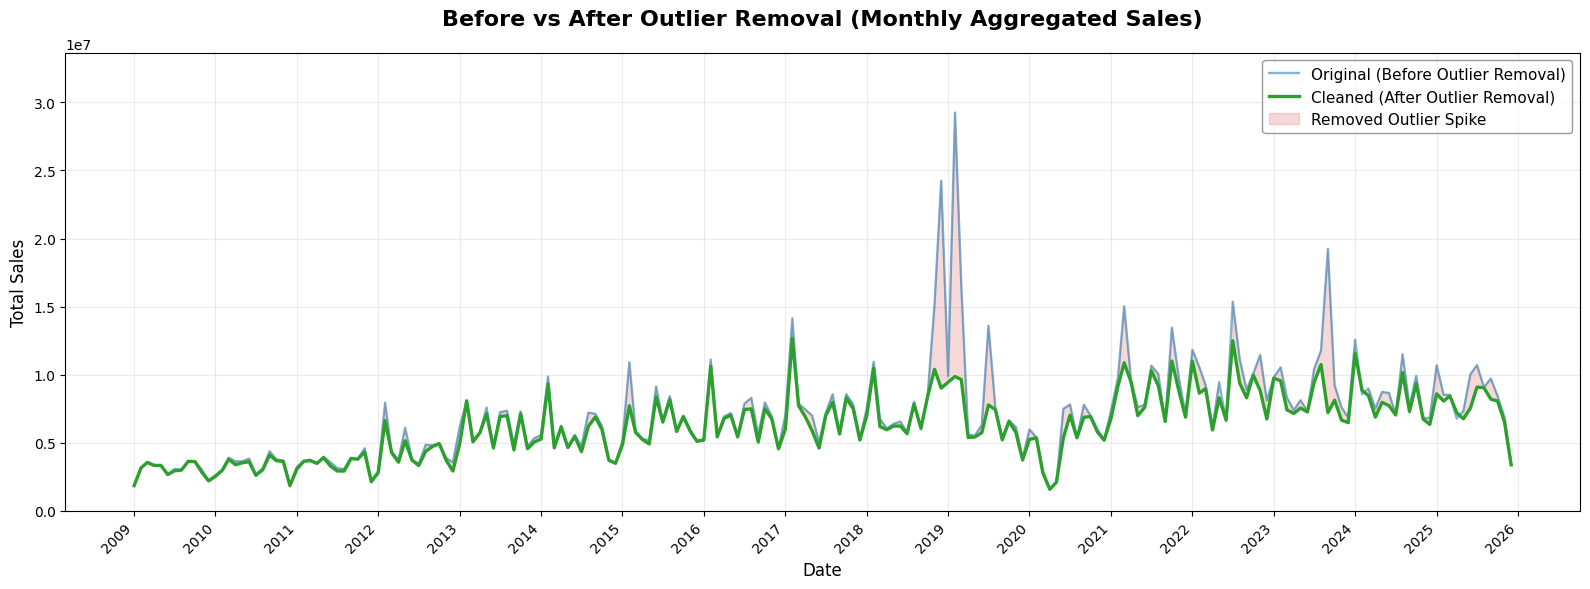

In [45]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure DATE is proper datetime
df_clean['DATE'] = pd.to_datetime(df_clean['DATE'])
df_clean = df_clean.sort_values('DATE')

# Aggregate at monthly level
agg = (
    df_clean
    .set_index('DATE')
    .resample('MS')  # Month start
    .agg({
        'SALES_COUNT': 'sum',
        'SALES_COUNT_CLEANED': 'sum'
    })
    .fillna(0)
)

# Difference between raw and cleaned (spikes removed)
agg['diff'] = agg['SALES_COUNT'] - agg['SALES_COUNT_CLEANED']

# --- PLOT ---
plt.figure(figsize=(16, 6))

# Original data
plt.plot(
    agg.index, agg['SALES_COUNT'],
    label='Original (Before Outlier Removal)',
    linewidth=1.7, alpha=0.55, color='tab:blue'
)

# Cleaned data
plt.plot(
    agg.index, agg['SALES_COUNT_CLEANED'],
    label='Cleaned (After Outlier Removal)',
    linewidth=2.4, color='tab:green'
)

# Highlight the removed portion (spikes)
plt.fill_between(
    agg.index,
    agg['SALES_COUNT'],
    agg['SALES_COUNT_CLEANED'],
    where=(agg['SALES_COUNT'] > agg['SALES_COUNT_CLEANED']),
    color='tab:red',
    alpha=0.18,
    label='Removed Outlier Spike'
)

# Title + Labels
plt.title(
    "Before vs After Outlier Removal (Monthly Aggregated Sales)",
    fontsize=16, fontweight='bold', pad=20
)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)

# Grid & Legend
plt.grid(alpha=0.25)
plt.legend(
    frameon=True, fontsize=11,
    facecolor='white', edgecolor='gray'
)

# Format x-axis for readability
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate(rotation=45)

# Adjust Y range dynamically
plt.ylim(
    0,
    max(agg['SALES_COUNT'].max(), agg['SALES_COUNT_CLEANED'].max()) * 1.15
)

plt.tight_layout()
plt.show()


/tmp/ipykernel_16661/4022722877.py:99: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


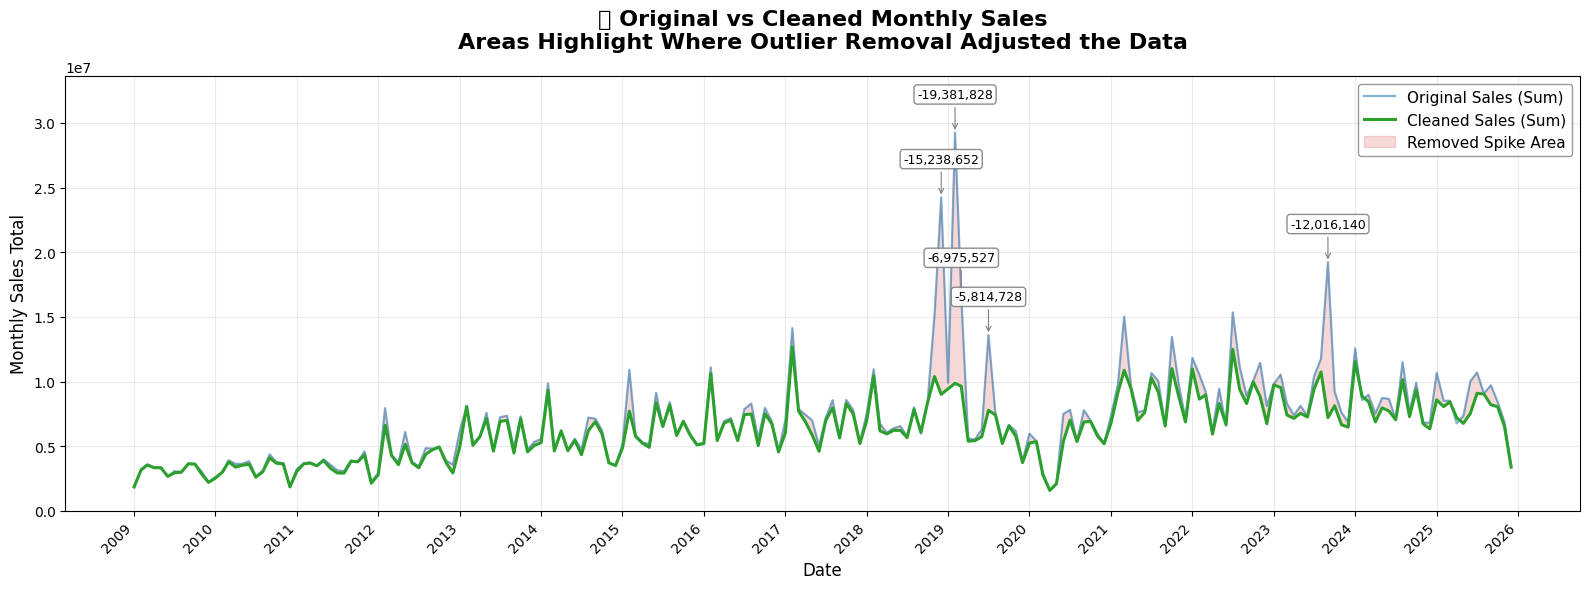

In [46]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure datetime
df_clean['DATE'] = pd.to_datetime(df_clean['DATE'])
df_clean = df_clean.sort_values('DATE')

# Aggregate by month
agg = (
    df_clean
    .set_index('DATE')
    .resample('MS')  # Month-start
    .agg({
        'SALES_COUNT': 'sum',
        'SALES_COUNT_CLEANED': 'sum'
    })
    .fillna(0)
)

# Compute diffs
agg['diff'] = agg['SALES_COUNT'] - agg['SALES_COUNT_CLEANED']

# Find top cleaned spikes
top = agg['diff'].nlargest(5)

# Figure
plt.figure(figsize=(16, 6))

# --- Plot Original & Cleaned ---
plt.plot(
    agg.index, agg['SALES_COUNT'],
    label='Original Sales (Sum)',
    linewidth=1.6, alpha=0.55, color='tab:blue'
)
plt.plot(
    agg.index, agg['SALES_COUNT_CLEANED'],
    label='Cleaned Sales (Sum)',
    linewidth=2.2, color='tab:green'
)

# --- Highlight cleaned spike areas ---
plt.fill_between(
    agg.index,
    agg['SALES_COUNT'],
    agg['SALES_COUNT_CLEANED'],
    where=(agg['SALES_COUNT'] >= agg['SALES_COUNT_CLEANED']),
    interpolate=True,
    alpha=0.18,
    color='tab:red',
    label='Removed Spike Area'
)

# --- Annotate biggest removals ---
for dt, val in top.items():
    y_val = agg.loc[dt, 'SALES_COUNT']
    plt.annotate(
        f"-{int(val):,}",
        xy=(dt, y_val),
        xytext=(0, 25),
        textcoords='offset points',
        ha='center',
        fontsize=9,
        bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='gray', alpha=0.9),
        arrowprops=dict(
            arrowstyle='->',
            lw=0.8,
            color='gray'
        )
    )

# --- Visual Improvements ---
plt.title(
    "📉 Original vs Cleaned Monthly Sales\n"
    "Areas Highlight Where Outlier Removal Adjusted the Data",
    fontsize=16, fontweight='bold', pad=20
)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Monthly Sales Total", fontsize=12)

plt.grid(True, alpha=0.25)

plt.legend(
    frameon=True, fontsize=11,
    facecolor='white', edgecolor='gray'
)

# Format x-axis ticks
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate(rotation=45)

# Dynamic Y scale
plt.ylim(
    0,
    max(agg['SALES_COUNT'].max(), agg['SALES_COUNT_CLEANED'].max()) * 1.15
)

plt.tight_layout()
plt.show()


# Before Vs After outlier removal

In [47]:
print("Yearly Summary of Sales Before and After Outlier Removal:" )
print()
# Ensure DATE column is datetime
df_clean['DATE'] = pd.to_datetime(df_clean['DATE'])

# Extract YEAR if not present
df_clean['YEAR'] = df_clean['DATE'].dt.year

# Aggregate yearly totals
yearly_summary = (
    df_clean.groupby('YEAR')
    .agg(
        SALES_BEFORE = ('SALES_COUNT', 'sum'),
        SALES_AFTER  = ('SALES_COUNT_CLEANED', 'sum')
    )
)

# Add difference column
yearly_summary['DIFFERENCE'] = yearly_summary['SALES_BEFORE'] - yearly_summary['SALES_AFTER']

# Format for readability (optional)
yearly_summary['SALES_BEFORE'] = yearly_summary['SALES_BEFORE'].astype(int)
yearly_summary['SALES_AFTER'] = yearly_summary['SALES_AFTER'].astype(int)
yearly_summary['DIFFERENCE'] = yearly_summary['DIFFERENCE'].astype(int)

print(yearly_summary)


Yearly Summary of Sales Before and After Outlier Removal:

      SALES_BEFORE  SALES_AFTER  DIFFERENCE
YEAR                                       
2009      36603935     36136633      467301
2010      40179259     38757277     1421981
2011      42469572     41044946     1424625
2012      54351628     50166405     4185222
2013      74337708     70748406     3589301
2014      69344256     66123241     3221014
2015      80471950     75264469     5207480
2016      82670167     79307824     3362342
2017      91683700     85440689     6243010
2018     111851867     89464029    22387837
2019     116388216     82009039    34379177
2020      64708250     59611467     5096782
2021     114773670    103646960    11126710
2022     118824775    105268477    13556297
2023     116628419     97344574    19283844
2024     104827631     98387315     6440316
2025     100123520     90928824     9194696


In [48]:
df_clean.head(10)

,DATE,REGION,COUNTRY,SALESORG,SILHOUETTE,GENDER,SPORT,MONTH,YEAR,SALES_COUNT,SALES_COUNT_CLEANED,OUTLIER_FLAG
2173,2009-01-01,EMEA,United Kingdom,EMEA,3930,Male,Others,1,2009,161.0,161.0,False
76800,2009-01-01,North America,Canada,Canada,920,Others,Others,1,2009,851.0,851.0,False
62989,2009-01-01,Emerging Markets,USA,Others,Others,Male,Baseball,1,2009,102.0,102.0,False
9078,2009-01-01,EMEA,United Kingdom,EMEA,Apparel,Male,SP-None,1,2009,1840.0,1840.0,False
4167,2009-01-01,EMEA,United Kingdom,EMEA,920,Male,Others,1,2009,2455.0,2455.0,False
35470,2009-01-01,Emerging Markets,Hong Kong,Others,5950,Male,SP-None,1,2009,144.0,144.0,False
97321,2009-01-01,North America,USA,United States,920,Male,Others,1,2009,55996.0,55996.0,False
93295,2009-01-01,North America,USA,United States,3930,Male,Others,1,2009,15076.0,15076.0,False
2779,2009-01-01,EMEA,United Kingdom,EMEA,5950,Male,Basketball,1,2009,179.0,179.0,False
9341,2009-01-01,EMEA,United Kingdom,EMEA,Apparel,Others,Others,1,2009,9360.0,9360.0,False


# FEATURE ENGINEERING

In [21]:
import numpy as np

# =========================================================
# FEATURE ENGINEERING — Using Outlier-Cleaned Data (df_clean)
# =========================================================

# 1. Start from the STL-cleaned dataset
df_fe = df_clean.copy()

# 2. Define cleaned target column
df_fe["SALES_COUNT_CLEAN"] = df_fe["SALES_COUNT_CLEANED"]

# 3. Grouping columns for time series
group_cols = ["REGION", "COUNTRY", "SALESORG",
              "SILHOUETTE", "GENDER", "SPORT"]

# Ensure proper ordering for lag/rolling ops
df_fe = df_fe.sort_values(group_cols + ["DATE"])
grp = df_fe.groupby(group_cols, group_keys=False)

# =========================================================
# 4. LAG FEATURES
# =========================================================
LAGS = [1, 3, 6, 12, 24]

for lag in LAGS:
    df_fe[f"lag_{lag}"] = grp["SALES_COUNT_CLEAN"].shift(lag)

# =========================================================
# 5. ROLLING WINDOW FEATURES
# =========================================================
# Always use group-wise rolling with shift(1) to avoid leakage
df_fe["rolling_3"] = grp["SALES_COUNT_CLEAN"].shift(1).rolling(3).mean()
df_fe["rolling_6"] = grp["SALES_COUNT_CLEAN"].shift(1).rolling(6).mean()

# =========================================================
# 6. YEAR-ON-YEAR CHANGE (YoY)
# =========================================================
df_fe["yoy_change"] = (
    df_fe["SALES_COUNT_CLEAN"] - df_fe["lag_12"]
) / (df_fe["lag_12"] + 1e-6)

# Clamp extreme values
df_fe["yoy_change"] = df_fe["yoy_change"].clip(-5, 5)

# =========================================================
# 7. CYCLICAL FEATURES FOR MONTH
# =========================================================
df_fe["month_sin"] = np.sin(2 * np.pi * df_fe["MONTH"] / 12)
df_fe["month_cos"] = np.cos(2 * np.pi * df_fe["MONTH"] / 12)

# =========================================================
# 8. LOG TRANSFORMATION (variance stabilization)
# =========================================================
df_fe["log_sales"] = np.log1p(df_fe["SALES_COUNT_CLEAN"])

# =========================================================
# 9. DROP NA ROWS FOR ALL LAG FEATURES
# =========================================================
lag_cols = [f"lag_{l}" for l in LAGS]
df_fe = df_fe.dropna(subset=lag_cols).reset_index(drop=True)

print("Feature engineering complete. Final shape:", df_fe.shape)
df_fe.head()


Feature engineering complete. Final shape: (86410, 24)


,DATE,REGION,COUNTRY,SALESORG,SILHOUETTE,GENDER,SPORT,MONTH,YEAR,SALES_COUNT,...,lag_3,lag_6,lag_12,lag_24,rolling_3,rolling_6,yoy_change,month_sin,month_cos,log_sales
0,2013-07-01,EMEA,Germany,Others,3930,Male,Baseball,7,2013,2133.0,...,615.0,476.0,589.0,20.00000,761.666667,808.833333,2.621392,-0.5,-0.866025,7.665753
1,2013-08-01,EMEA,Germany,Others,3930,Male,Baseball,8,2013,1258.0,...,612.0,655.0,2366.0,12.00000,1267.666667,1085.000000,-0.468301,-0.866025,-0.5,7.138073
2,2013-09-01,EMEA,Germany,Others,3930,Male,Baseball,9,2013,1253.0,...,1058.0,1437.0,307.0,63.45098,1483.000000,1185.500000,3.081433,-1.0,-0.0,7.134094
3,2013-10-01,EMEA,Germany,Others,3930,Male,Baseball,10,2013,440.0,...,2133.0,615.0,1405.0,76.00000,1548.000000,1154.833333,-0.686833,-0.866025,0.5,6.089045
4,2013-11-01,EMEA,Germany,Others,3930,Male,Baseball,11,2013,310.0,...,1258.0,612.0,887.0,114.00000,983.666667,1125.666667,-0.650507,-0.5,0.866025,5.739793


In [50]:
print(df_fe.columns.tolist())

['DATE', 'REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT', 'MONTH', 'YEAR', 'SALES_COUNT', 'SALES_COUNT_CLEANED', 'OUTLIER_FLAG', 'SALES_COUNT_CLEAN', 'lag_1', 'lag_3', 'lag_6', 'lag_12', 'lag_24', 'rolling_3', 'rolling_6', 'yoy_change', 'month_sin', 'month_cos', 'log_sales']


# Group data into clean, monthly-level segments
# Sum the sales
# Average the ML features
# Produce a dataset ready for forecasting

In [22]:
# Columns that must be aggregated by SUM (sales)
sum_cols = ["SALES_COUNT", "SALES_COUNT_CLEAN"]

# Columns that should be aggregated by MEAN (all numerical features except identifiers & sums)
exclude_cols = [
    "REGION", "COUNTRY", "SALESORG", "SILHOUETTE",
    "GENDER", "SPORT", "YEAR", "MONTH", "DATE",
    "SALES_COUNT", "SALES_COUNT_CLEAN"
]

mean_cols = [col for col in df_fe.columns if col not in exclude_cols]

# Groupby keys
group_keys = ["REGION", "COUNTRY", "SALESORG",
              "SILHOUETTE", "GENDER", "SPORT",
              "YEAR", "MONTH"]

# Aggregations
df_grouped = df_fe.groupby(group_keys).agg(
    {**{c: "sum" for c in sum_cols},
     **{c: "mean" for c in mean_cols}}
).reset_index()

print("Grouped dataset shape:", df_grouped.shape)
df_grouped.head()


Grouped dataset shape: (78986, 23)


,REGION,COUNTRY,SALESORG,SILHOUETTE,GENDER,SPORT,YEAR,MONTH,SALES_COUNT,SALES_COUNT_CLEAN,...,lag_3,lag_6,lag_12,lag_24,rolling_3,rolling_6,yoy_change,month_sin,month_cos,log_sales
0,EMEA,Germany,Others,3930,Male,Baseball,2013,7,2133.0,2133.0,...,615.0,476.0,589.0,20.00000,761.666667,808.833333,2.621392,-0.5,-0.866025,7.665753
1,EMEA,Germany,Others,3930,Male,Baseball,2013,8,1258.0,1258.0,...,612.0,655.0,2366.0,12.00000,1267.666667,1085.000000,-0.468301,-0.866025,-0.5,7.138073
2,EMEA,Germany,Others,3930,Male,Baseball,2013,9,1253.0,1253.0,...,1058.0,1437.0,307.0,63.45098,1483.000000,1185.500000,3.081433,-1.0,-0.0,7.134094
3,EMEA,Germany,Others,3930,Male,Baseball,2013,10,440.0,440.0,...,2133.0,615.0,1405.0,76.00000,1548.000000,1154.833333,-0.686833,-0.866025,0.5,6.089045
4,EMEA,Germany,Others,3930,Male,Baseball,2013,11,310.0,310.0,...,1258.0,612.0,887.0,114.00000,983.666667,1125.666667,-0.650507,-0.5,0.866025,5.739793


# 2024

# Create DATE column in df_grouped

In [23]:
df_grouped["DATE"] = pd.to_datetime(
    dict(year=df_grouped["YEAR"], month=df_grouped["MONTH"], day=1)
)
print("DATE column reconstructed.")


DATE column reconstructed.


# TRAIN --> Everything BEFORE 2024 goes to train
# TEST -->  Selects exactly 2024 data and Ensures 12 months of test

In [24]:
train = df_grouped[df_grouped["DATE"] < "2024-01-01"].reset_index(drop=True)

test  = df_grouped[
    (df_grouped["DATE"] >= "2024-01-01") &
    (df_grouped["DATE"] <= "2024-12-31")
].reset_index(drop=True)

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (63637, 24)
Test shape: (7799, 24)


In [25]:
df_grouped.columns

Index(['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT',
       'YEAR', 'MONTH', 'SALES_COUNT', 'SALES_COUNT_CLEAN',
       'SALES_COUNT_CLEANED', 'OUTLIER_FLAG', 'lag_1', 'lag_3', 'lag_6',
       'lag_12', 'lag_24', 'rolling_3', 'rolling_6', 'yoy_change', 'month_sin',
       'month_cos', 'log_sales', 'DATE'],
      dtype='object')

# Features trained for 2024 - Feature List

In [55]:
target = "SALES_COUNT_CLEAN"

# Categorical columns that CatBoost will handle
cat_cols = ["REGION", "COUNTRY", "SALESORG", 
            "SILHOUETTE", "GENDER", "SPORT"]

# Columns to exclude from feature set
exclude = ["SALES_COUNT", "SALES_COUNT_CLEAN", "SALES_COUNT_CLEANED",
           "DATE", "YEAR", "MONTH"]

# Build feature list
feature_cols = [
    col for col in df_grouped.columns
    if col not in exclude
]

X_train = train[feature_cols]
y_train = train[target]

X_test  = test[feature_cols]
y_test  = test[target]

print(train["DATE"].min(), train["DATE"].max())
print(test["DATE"].min(), test["DATE"].max())

print("Num Features:", len(feature_cols))
print("Feature List:", feature_cols)


2009-10-01 00:00:00 2023-12-01 00:00:00
2024-01-01 00:00:00 2024-12-01 00:00:00
Num Features: 18
Feature List: ['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT', 'OUTLIER_FLAG', 'lag_1', 'lag_3', 'lag_6', 'lag_12', 'lag_24', 'rolling_3', 'rolling_6', 'yoy_change', 'month_sin', 'month_cos', 'log_sales']


In [56]:
# from catboost import CatBoostRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import numpy as np

# # Target variable
# target = "SALES_COUNT_CLEAN"

# # Categorical features we want CatBoost to treat as categories
# cat_cols = ["REGION", "COUNTRY", "SALESORG", "SILHOUETTE", "GENDER", "SPORT"]

# # Make sure these columns exist in df_grouped
# print("Categorical columns present:", [c for c in cat_cols if c in df_grouped.columns])

# # Rebuild feature columns:
# # - keep all except target, raw sales, DATE
# feature_cols = [
#     col for col in df_grouped.columns
#     if col not in [target, "SALES_COUNT", "DATE", "log_sales"]
# ]

# print("Number of feature columns:", len(feature_cols))
# print("Feature columns:", feature_cols)

# # Rebuild X_train, X_test using feature_cols
# X_train = train[feature_cols]
# y_train = train[target]

# X_test  = test[feature_cols]
# y_test  = test[target]

# # Indices of categorical features in X_train (CatBoost needs indices, not names)
# cat_feature_indices = [X_train.columns.get_loc(c) for c in cat_cols if c in X_train.columns]
# print("Categorical feature indices:", cat_feature_indices)


# Final Feature Columns:

In [57]:
target = "SALES_COUNT_CLEAN"

# Columns to exclude
exclude = [
    target,                 # target column
    "SALES_COUNT",          # raw sales
    "SALES_COUNT_CLEANED",  # duplicate cleaned column
    "OUTLIER_FLAG",         # meaningless after grouping
    "DATE",                 # datetime
    "YEAR",                 # raw numeric year
    "MONTH"                 # raw numeric month
    "log_sales"            # log-transformed target
]

# Build final feature list
feature_cols = [
    col for col in df_grouped.columns
    if col not in exclude
]

print("Final Feature Columns:", feature_cols)
print("Number of Features:", len(feature_cols))



Final Feature Columns: ['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT', 'MONTH', 'lag_1', 'lag_3', 'lag_6', 'lag_12', 'lag_24', 'rolling_3', 'rolling_6', 'yoy_change', 'month_sin', 'month_cos', 'log_sales']
Number of Features: 18


# Train/Test sets

In [58]:
# ------------------------------
# 5. Train/Test sets
# ------------------------------
X_train = train[feature_cols]
y_train = train[target]

X_test  = test[feature_cols]
y_test  = test[target]

# ------------------------------
# 6. CatBoost categorical feature indices
# ------------------------------
cat_feature_indices = [
    X_train.columns.get_loc(c)
    for c in cat_cols
    if c in X_train.columns
]

print("Categorical feature indices:", cat_feature_indices)


Categorical feature indices: [0, 1, 2, 3, 4, 5]


# ########## CI Changes from here:#####################

# Training 3 Catboost Models

# P50 model → median forecast

In [59]:
model_p50 = CatBoostRegressor(
    loss_function="RMSE",
    depth=8,
    learning_rate=0.05,
    n_estimators=1000,
    random_seed=42,
    subsample=0.8,
    colsample_bylevel=0.8,
    od_type="Iter",
    od_wait=50,
    verbose=100
)

model_p50.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    cat_features=cat_feature_indices,
    use_best_model=True
)


0:	learn: 79034.8003884	test: 64648.1119987	best: 64648.1119987 (0)	total: 126ms	remaining: 2m 5s
100:	learn: 20647.4719097	test: 26374.8021757	best: 26342.9871128 (99)	total: 5.52s	remaining: 49.1s
200:	learn: 17602.4252557	test: 25069.8369402	best: 25053.4483896 (199)	total: 10.7s	remaining: 42.5s
300:	learn: 15723.2170471	test: 24856.0344443	best: 24773.7057657 (286)	total: 15.9s	remaining: 37s
400:	learn: 14300.3852548	test: 24672.9101764	best: 24644.0925069 (392)	total: 21.1s	remaining: 31.5s
500:	learn: 13195.8025932	test: 24524.3661417	best: 24508.0393556 (497)	total: 26.8s	remaining: 26.7s
600:	learn: 11872.5764661	test: 24437.1945785	best: 24404.0166972 (579)	total: 32.3s	remaining: 21.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 24404.0167
bestIteration = 579

Shrink model to first 580 iterations.


# P05 model → 5th percentile (lower bound)

In [60]:
model_p05 = CatBoostRegressor(
    loss_function="Quantile:alpha=0.05",
    depth=8,
    learning_rate=0.05,
    n_estimators=1000,
    random_seed=42,
    subsample=0.8,
    colsample_bylevel=0.8,
    verbose=100
)

model_p05.fit(
    X_train, y_train,
    cat_features=cat_feature_indices
)


0:	learn: 755.9036408	total: 53.3ms	remaining: 53.2s
100:	learn: 669.1473873	total: 5.26s	remaining: 46.9s
200:	learn: 610.1063690	total: 10.8s	remaining: 42.8s
300:	learn: 537.1937632	total: 16.3s	remaining: 37.8s
400:	learn: 456.2295149	total: 21.8s	remaining: 32.6s
500:	learn: 352.2397583	total: 27.2s	remaining: 27.1s
600:	learn: 279.1996339	total: 32.8s	remaining: 21.8s
700:	learn: 239.0783885	total: 38.2s	remaining: 16.3s
800:	learn: 209.7115421	total: 43.6s	remaining: 10.8s
900:	learn: 202.3575316	total: 48.2s	remaining: 5.3s
999:	learn: 199.7198515	total: 52.9s	remaining: 0us


# P95 model → 95th percentile (upper bound)

In [61]:
model_p95 = CatBoostRegressor(
    loss_function="Quantile:alpha=0.95",
    depth=8,
    learning_rate=0.05,
    n_estimators=1000,
    random_seed=42,
    subsample=0.8,
    colsample_bylevel=0.8,
    verbose=100
)

model_p95.fit(
    X_train, y_train,
    cat_features=cat_feature_indices
)


0:	learn: 8728.2621017	total: 50ms	remaining: 50s
100:	learn: 753.5300215	total: 5.26s	remaining: 46.8s
200:	learn: 695.5815738	total: 10.4s	remaining: 41.3s
300:	learn: 623.7327746	total: 16.3s	remaining: 37.9s
400:	learn: 596.0399748	total: 21.7s	remaining: 32.4s
500:	learn: 552.1580958	total: 26.9s	remaining: 26.8s
600:	learn: 535.0482784	total: 32.2s	remaining: 21.4s
700:	learn: 514.8862014	total: 37.3s	remaining: 15.9s
800:	learn: 501.7824317	total: 42.4s	remaining: 10.5s
900:	learn: 493.6565096	total: 47s	remaining: 5.16s
999:	learn: 491.7720741	total: 51.2s	remaining: 0us


In [62]:
test["FORECAST_P50"] = model_p50.predict(X_test)
test["FORECAST_P05"] = model_p05.predict(X_test)
test["FORECAST_P95"] = model_p95.predict(X_test)

test["CI_LOWER"] = test["FORECAST_P05"]
test["CI_UPPER"] = test["FORECAST_P95"]
test["CI_WIDTH"] = test["FORECAST_P95"] - test["FORECAST_P05"]

print("CI UPPER:", test["CI_UPPER"].head())
print("CI WIDTH:", test["CI_WIDTH"].head())


CI UPPER: 0     2391.430437
1     7013.367548
2    12609.113175
3    10051.043892
4     8284.374041
Name: CI_UPPER, dtype: float64
CI WIDTH: 0    1211.873149
1    3381.393391
2     719.558485
3    6846.501176
4    5920.597492
Name: CI_WIDTH, dtype: float64


In [63]:
results_2024 = test[
    ["DATE","REGION","COUNTRY","SALESORG","SILHOUETTE","GENDER","SPORT",
     "SALES_COUNT_CLEAN",
     "FORECAST_P50","FORECAST_P05","FORECAST_P95",
     "CI_LOWER","CI_UPPER","CI_WIDTH"]
].copy()

results_2024.rename(columns={
    "SALES_COUNT_CLEAN": "ACTUAL_SALES"
}, inplace=True)


In [64]:
results_2024.head(12)


,DATE,REGION,COUNTRY,SALESORG,SILHOUETTE,GENDER,SPORT,ACTUAL_SALES,FORECAST_P50,FORECAST_P05,FORECAST_P95,CI_LOWER,CI_UPPER,CI_WIDTH
0,2024-01-01,EMEA,Germany,Others,940,Male,Others,1200.0,1812.378426,1179.557288,2391.430437,1179.557288,2391.430437,1211.873149
1,2024-02-01,EMEA,Germany,Others,940,Male,Others,4030.0,4726.819817,3631.974156,7013.367548,3631.974156,7013.367548,3381.393391
2,2024-03-01,EMEA,Germany,Others,940,Male,Others,12305.0,12176.756838,11889.554690,12609.113175,11889.554690,12609.113175,719.558485
3,2024-04-01,EMEA,Germany,Others,940,Male,Others,3421.0,4866.935552,3204.542716,10051.043892,3204.542716,10051.043892,6846.501176
4,2024-05-01,EMEA,Germany,Others,940,Male,Others,2500.0,4356.523673,2363.776549,8284.374041,2363.776549,8284.374041,5920.597492
5,2024-06-01,EMEA,Germany,Others,940,Male,Others,860.0,2993.356521,835.425696,6308.915250,835.425696,6308.915250,5473.489553
6,2024-07-01,EMEA,Germany,Others,940,Male,Others,5840.0,4254.465455,5515.341988,8206.459215,5515.341988,8206.459215,2691.117227
7,2024-08-01,EMEA,Germany,Others,940,Male,Others,12630.0,15881.023935,12464.774294,23319.062697,12464.774294,23319.062697,10854.288403
8,2024-10-01,EMEA,Germany,Others,940,Male,Others,1000.0,3338.651542,903.540751,4496.517190,903.540751,4496.517190,3592.976438
9,2024-11-01,EMEA,Germany,Others,940,Male,Others,4450.0,7642.876780,4314.215834,9490.419807,4314.215834,9490.419807,5176.203973


# Metrics

In [65]:
# Evaluate using p50 model (main forecast model)
y_pred = model_p50.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-6))) * 100
r2   = r2_score(y_test, y_pred)

print("CatBoost P50 Model Performance on Test Set:")
print(f"  RMSE : {rmse:,.2f}")
print(f"  MAE  : {mae:,.2f}")
print(f"  MAPE : {mape:,.2f}%")
print(f"  R²   : {r2:,.4f}")


CatBoost P50 Model Performance on Test Set:
  RMSE : 24,404.02
  MAE  : 2,438.12
  MAPE : 782.43%
  R²   : 0.8688


# NEW FEATURE IMPORTANCE

In [66]:
# # Feature importance using main model (p50)
# feature_importances = model_p50.get_feature_importance()
# fi_df = (
#     pd.DataFrame({"feature": X_train.columns, "importance": feature_importances})
#     .sort_values("importance", ascending=False)
# )

# plt.figure(figsize=(10, 8))
# plt.barh(fi_df["feature"].head(20)[::-1], fi_df["importance"].head(20)[::-1])
# plt.title("Top 20 Feature Importances - CatBoost (P50 Model)")
# plt.tight_layout()
# plt.show()


# builds evaluation dataframe.

In [67]:
# --- MAIN FORECAST (P50) ---
test["FORECAST_P50"] = model_p50.predict(X_test)

# --- QUANTILES ---
test["FORECAST_P05"] = model_p05.predict(X_test)
test["FORECAST_P95"] = model_p95.predict(X_test)

# --- CONFIDENCE INTERVAL ---
test["CI_LOWER"] = test["FORECAST_P05"]
test["CI_UPPER"] = test["FORECAST_P95"]
test["CI_WIDTH"] = test["FORECAST_P95"] - test["FORECAST_P05"]

# --- BUILD RESULTS DF ---
results_2024 = test[
    ["DATE","REGION","COUNTRY","SALESORG","SILHOUETTE","GENDER","SPORT",
     "SALES_COUNT_CLEAN",        # actual 2024
     "FORECAST_P50", "FORECAST_P05", "FORECAST_P95",
     "CI_LOWER", "CI_UPPER", "CI_WIDTH"]
].copy()

# rename actual column
results_2024.rename(columns={"SALES_COUNT_CLEAN":"ACTUAL_SALES"}, inplace=True)

# --- CALCULATE ERRORS (BASED ON P50) ---
results_2024["ERROR"] = results_2024["ACTUAL_SALES"] - results_2024["FORECAST_P50"]
results_2024["APE"] = (
    abs(results_2024["ERROR"]) / (results_2024["ACTUAL_SALES"] + 1e-6)
) * 100

results_2024.head(20)


,DATE,REGION,COUNTRY,SALESORG,SILHOUETTE,GENDER,SPORT,ACTUAL_SALES,FORECAST_P50,FORECAST_P05,FORECAST_P95,CI_LOWER,CI_UPPER,CI_WIDTH,ERROR,APE
0,2024-01-01,EMEA,Germany,Others,940,Male,Others,1200.0,1812.378426,1179.557288,2391.430437,1179.557288,2391.430437,1211.873149,-612.378426,51.031535
1,2024-02-01,EMEA,Germany,Others,940,Male,Others,4030.0,4726.819817,3631.974156,7013.367548,3631.974156,7013.367548,3381.393391,-696.819817,17.290814
2,2024-03-01,EMEA,Germany,Others,940,Male,Others,12305.0,12176.756838,11889.554690,12609.113175,11889.554690,12609.113175,719.558485,128.243162,1.042204
3,2024-04-01,EMEA,Germany,Others,940,Male,Others,3421.0,4866.935552,3204.542716,10051.043892,3204.542716,10051.043892,6846.501176,-1445.935552,42.266459
4,2024-05-01,EMEA,Germany,Others,940,Male,Others,2500.0,4356.523673,2363.776549,8284.374041,2363.776549,8284.374041,5920.597492,-1856.523673,74.260947
5,2024-06-01,EMEA,Germany,Others,940,Male,Others,860.0,2993.356521,835.425696,6308.915250,835.425696,6308.915250,5473.489553,-2133.356521,248.064711
6,2024-07-01,EMEA,Germany,Others,940,Male,Others,5840.0,4254.465455,5515.341988,8206.459215,5515.341988,8206.459215,2691.117227,1585.534545,27.149564
7,2024-08-01,EMEA,Germany,Others,940,Male,Others,12630.0,15881.023935,12464.774294,23319.062697,12464.774294,23319.062697,10854.288403,-3251.023935,25.740490
8,2024-10-01,EMEA,Germany,Others,940,Male,Others,1000.0,3338.651542,903.540751,4496.517190,903.540751,4496.517190,3592.976438,-2338.651542,233.865154
9,2024-11-01,EMEA,Germany,Others,940,Male,Others,4450.0,7642.876780,4314.215834,9490.419807,4314.215834,9490.419807,5176.203973,-3192.876780,71.750040


# NEW PLOT --> 

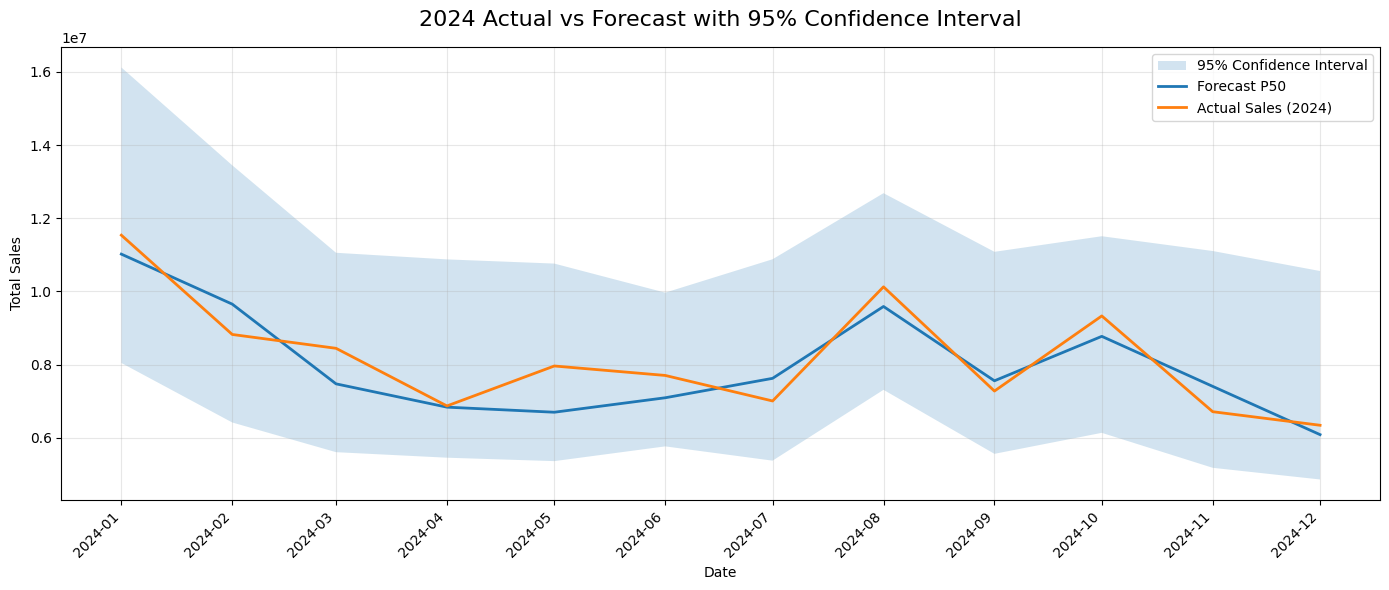

In [68]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Aggregate monthly actual & forecasts
monthly_agg = (
    results_2024
    .groupby("DATE")
    .agg({
        "ACTUAL_SALES": "sum",
        "FORECAST_P50": "sum",
        "FORECAST_P05": "sum",
        "FORECAST_P95": "sum"
    })
    .reset_index()
    .sort_values("DATE")
)

plt.figure(figsize=(14, 6))

# --- CONFIDENCE INTERVAL SHADE ---
plt.fill_between(
    monthly_agg["DATE"],
    monthly_agg["FORECAST_P05"],
    monthly_agg["FORECAST_P95"],
    alpha=0.2,
    label="95% Confidence Interval"
)

# --- P50 Forecast ---
plt.plot(
    monthly_agg["DATE"],
    monthly_agg["FORECAST_P50"],
    label="Forecast P50",
    linewidth=2
)

# --- Actual ---
plt.plot(
    monthly_agg["DATE"],
    monthly_agg["ACTUAL_SALES"],
    label="Actual Sales (2024)",
    linewidth=2
)

# --- Formatting ---
plt.title("2024 Actual vs Forecast with 95% Confidence Interval", fontsize=16, pad=15)
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.grid(alpha=0.3)
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate(rotation=45)

plt.tight_layout()
plt.show()


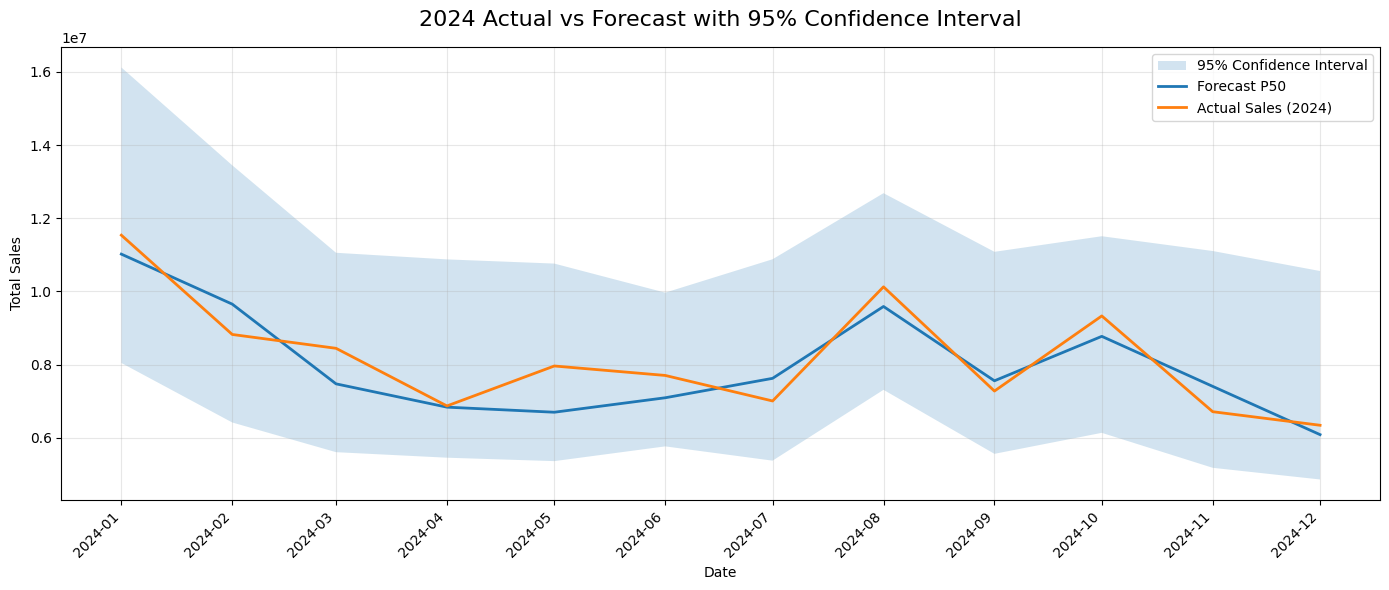

In [69]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Aggregate monthly actual & forecasts
monthly_agg = (
    results_2024
    .groupby("DATE")
    .agg({
        "ACTUAL_SALES": "sum",
        "FORECAST_P50": "sum",
        "FORECAST_P05": "sum",
        "FORECAST_P95": "sum"
    })
    .reset_index()
    .sort_values("DATE")
)

plt.figure(figsize=(14, 6))

# --- CONFIDENCE INTERVAL SHADE ---
plt.fill_between(
    monthly_agg["DATE"],
    monthly_agg["FORECAST_P05"],
    monthly_agg["FORECAST_P95"],
    alpha=0.2,
    label="95% Confidence Interval"
)

# --- P50 Forecast ---
plt.plot(
    monthly_agg["DATE"],
    monthly_agg["FORECAST_P50"],
    label="Forecast P50",
    linewidth=2
)

# --- Actual ---
plt.plot(
    monthly_agg["DATE"],
    monthly_agg["ACTUAL_SALES"],
    label="Actual Sales (2024)",
    linewidth=2
)

# --- Formatting ---
plt.title("2024 Actual vs Forecast with 95% Confidence Interval", fontsize=16, pad=15)
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.grid(alpha=0.3)
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate(rotation=45)

plt.tight_layout()
plt.show()


# Predictions

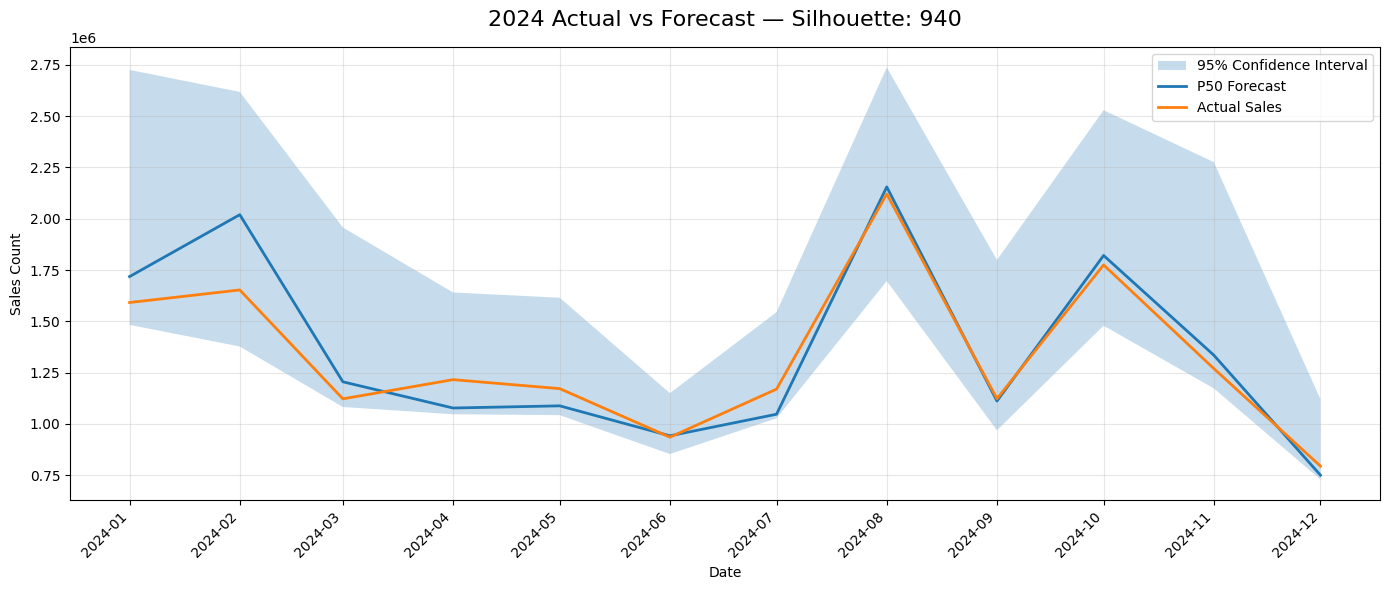

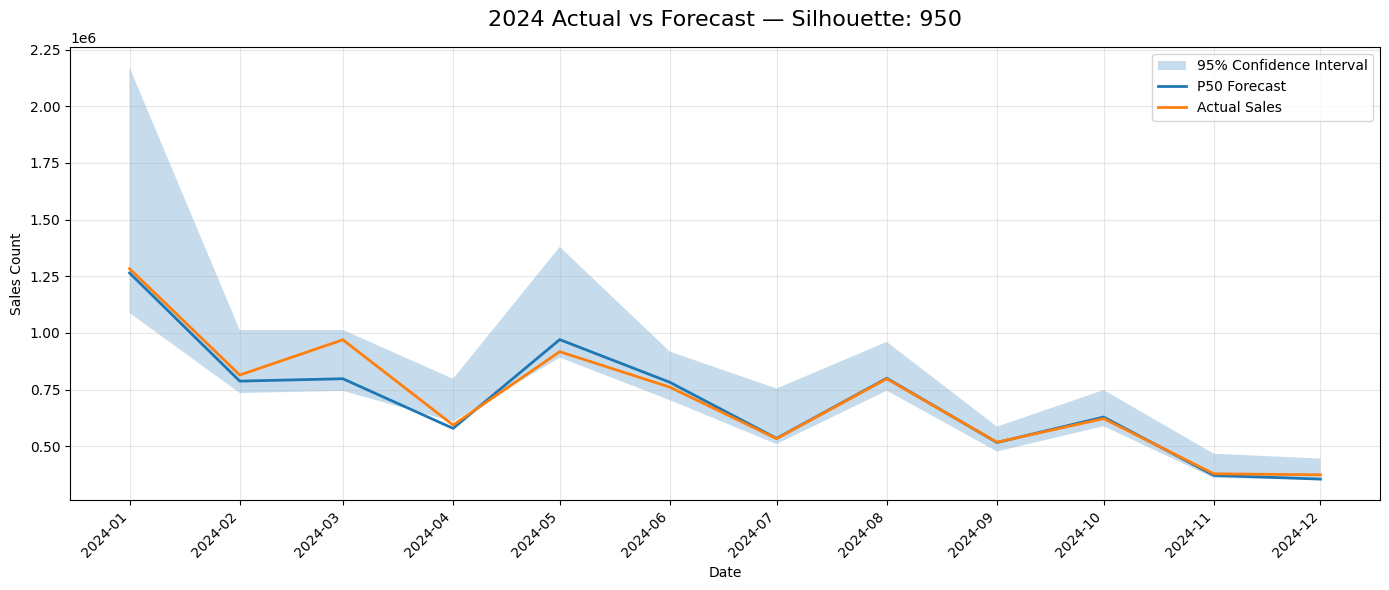

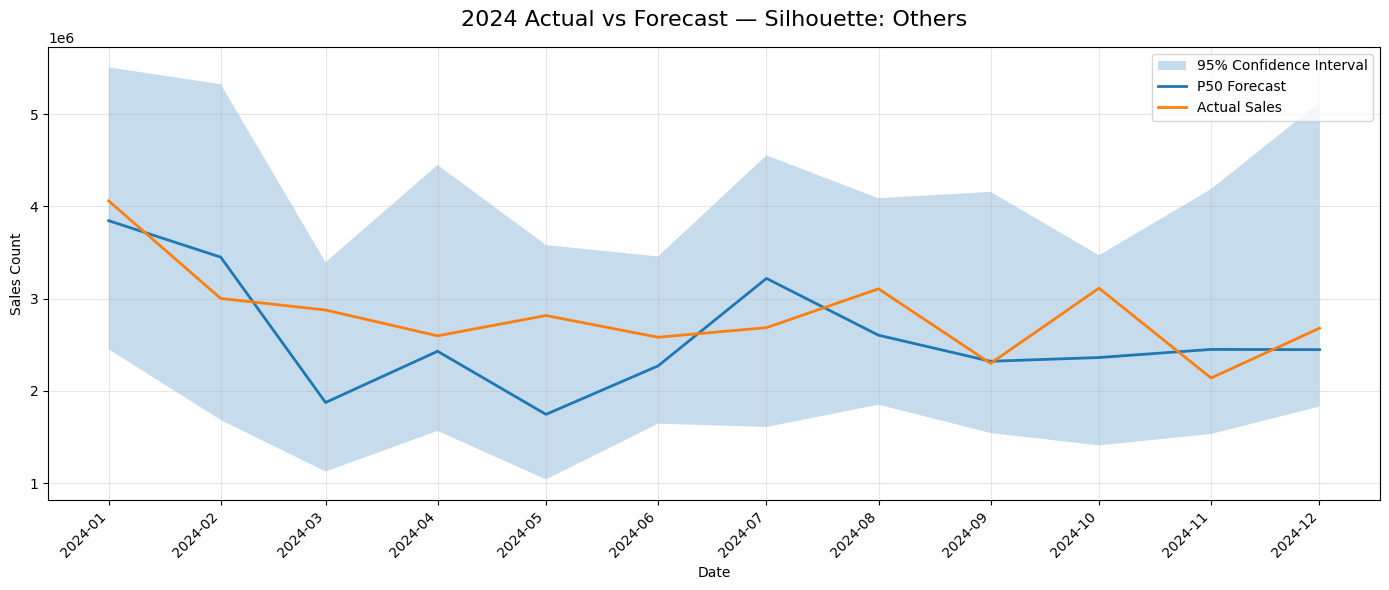

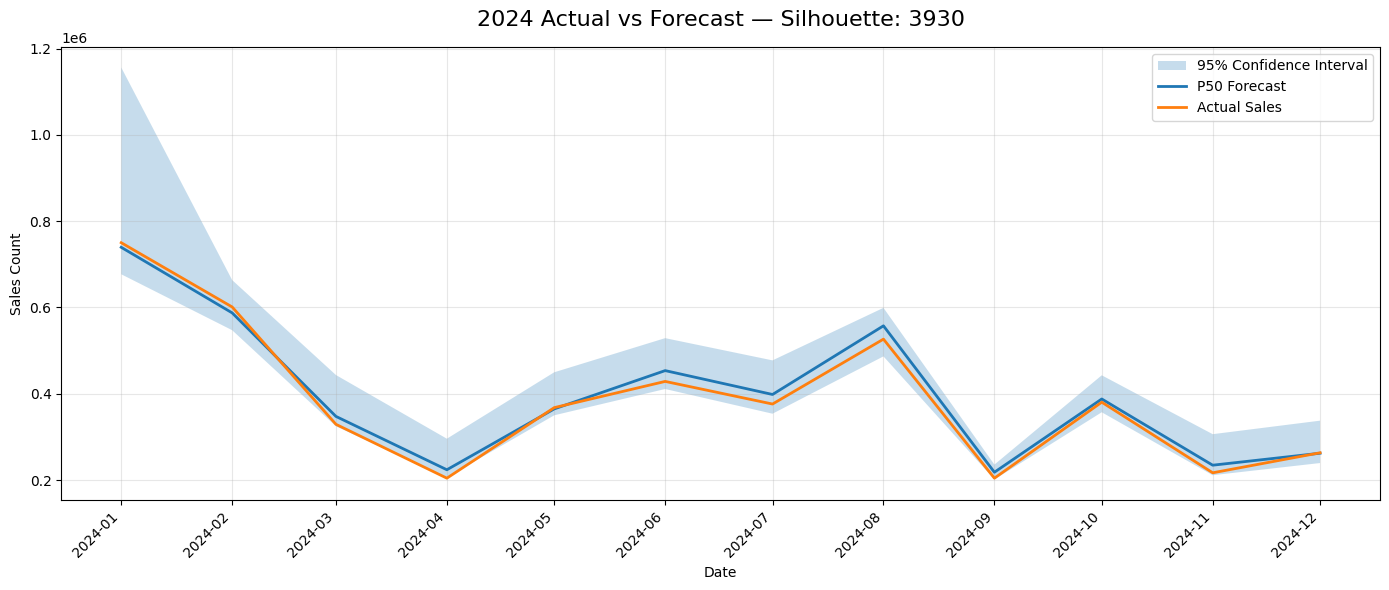

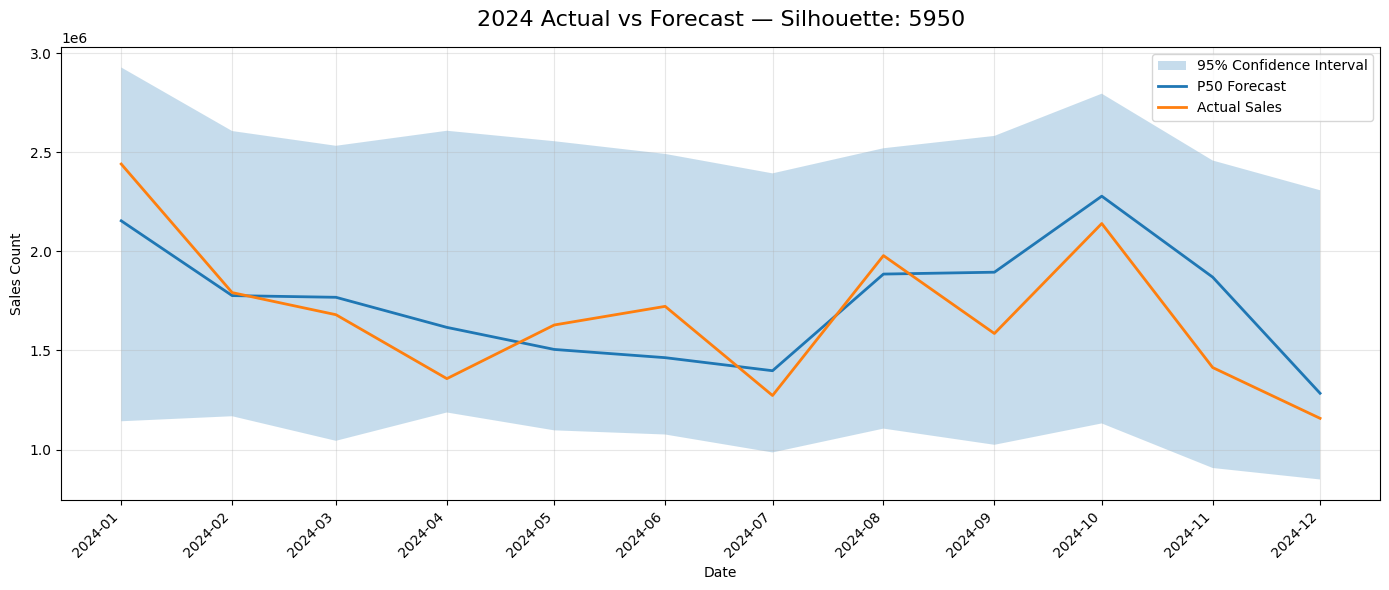

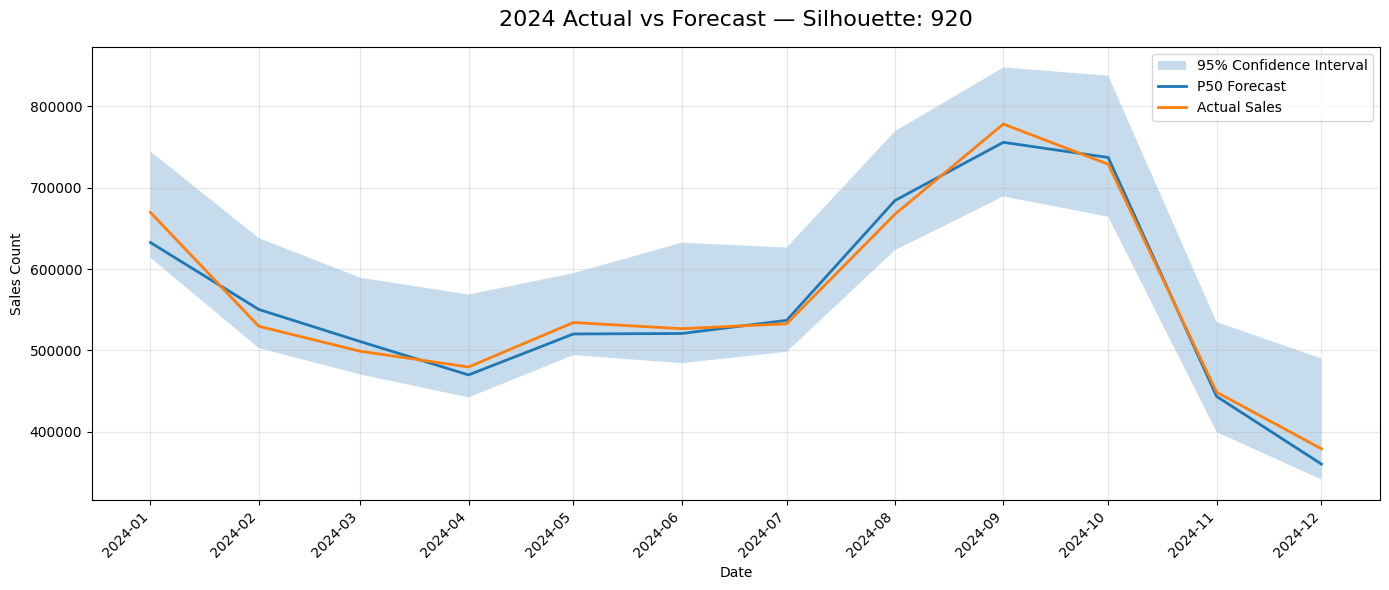

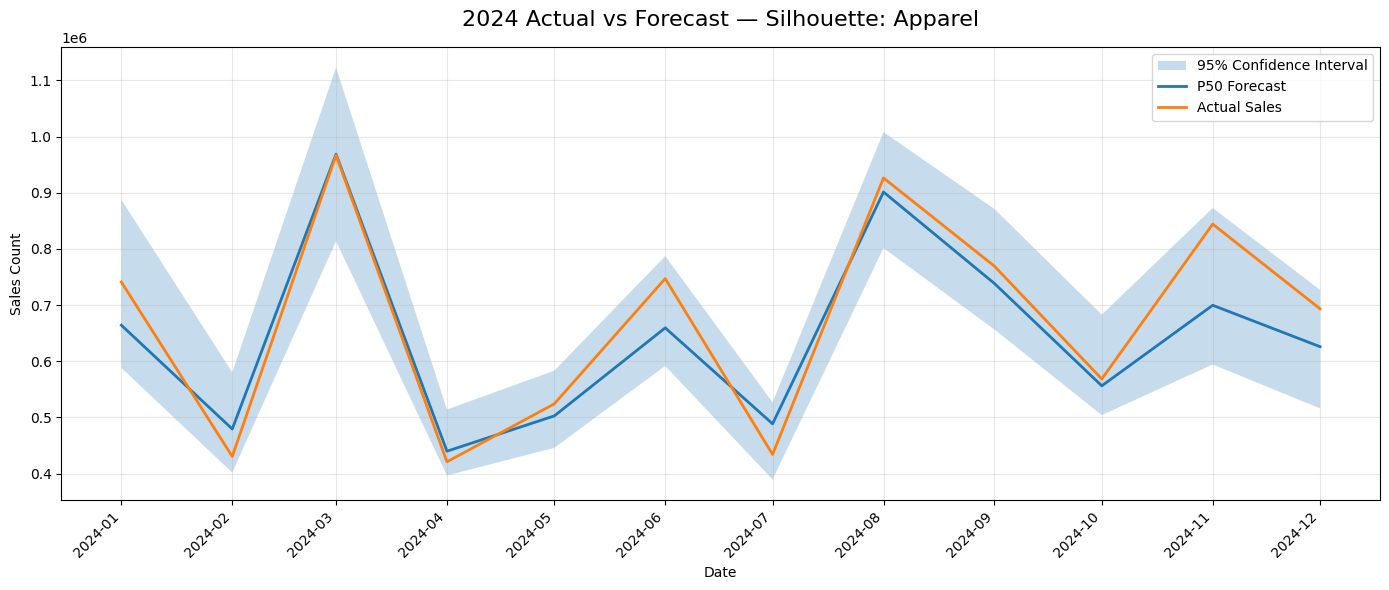

In [70]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ---- Loop through each silhouette ----
silhouettes = results_2024["SILHOUETTE"].unique()

for sil in silhouettes:

    df_sil = results_2024[results_2024["SILHOUETTE"] == sil].copy()
    df_sil = df_sil.sort_values("DATE")

    # ---- Aggregate to monthly ----
    monthly_agg = (
        df_sil.groupby("DATE")
        .agg({
            "ACTUAL_SALES": "sum",
            "FORECAST_P50": "sum",
            "FORECAST_P05": "sum",
            "FORECAST_P95": "sum"
        })
        .reset_index()
    )

    plt.figure(figsize=(14, 6))

    # --- Confidence Interval ---
    plt.fill_between(
        monthly_agg["DATE"],
        monthly_agg["FORECAST_P05"],
        monthly_agg["FORECAST_P95"],
        alpha=0.25,
        label="95% Confidence Interval"
    )

    # --- Forecast (P50) ---
    plt.plot(
        monthly_agg["DATE"],
        monthly_agg["FORECAST_P50"],
        label="P50 Forecast",
        linewidth=2
    )

    # --- Actual Sales ---
    plt.plot(
        monthly_agg["DATE"],
        monthly_agg["ACTUAL_SALES"],
        label="Actual Sales",
        linewidth=2
    )

    # ---- Formatting ----
    plt.title(f"2024 Actual vs Forecast — Silhouette: {sil}", fontsize=16, pad=15)
    plt.xlabel("Date")
    plt.ylabel("Sales Count")
    plt.grid(alpha=0.3)
    plt.legend()

    # Format X-axis
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.gcf().autofmt_xdate(rotation=45)

    plt.tight_layout()
    plt.show()


# Model Metrics for 2024 Forecast:

In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Safe copy to avoid warnings
test = test.copy()

# Use P50 model for accuracy
test["PRED_P50"] = model_p50.predict(X_test)

# Monthly aggregation
results = (
    test.groupby(["DATE"])
        .agg({
            "SALES_COUNT_CLEAN": "sum",
            "PRED_P50": "sum"
        })
        .reset_index()
        .rename(columns={"SALES_COUNT_CLEAN": "ACTUAL_SALES"})
)

y_true = results["ACTUAL_SALES"].values
y_pred = results["PRED_P50"].values

# Metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100
r2   = r2_score(y_true, y_pred)

# Directional accuracy
direction_true = np.sign(np.diff(y_true))
direction_pred = np.sign(np.diff(y_pred))

mask = direction_true != 0
accuracy = np.mean(direction_true[mask] == direction_pred[mask]) * 100

# Output
print("Model Metrics for 2024 Forecast (P50):")
print("--------------------------------------")
print(f"RMSE     : {rmse:,.2f}")
print(f"MAE      : {mae:,.2f}")
print(f"MAPE     : {mape:,.2f}%")
print(f"R2       : {r2:,.4f}")
print(f"Accuracy : {accuracy:,.2f}% ")



Model Metrics for 2024 Forecast (P50):
--------------------------------------
RMSE     : 675,504.73
MAE      : 597,309.88
MAPE     : 7.33%
R2       : 0.7940
Accuracy : 72.73% 


In [130]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Safe copy to avoid warnings
test = test.copy()

# Use P50 model for accuracy
test["PRED_P50"] = model_p50.predict(X_test)

# Monthly aggregation
results = (
    test.groupby(["DATE"])
        .agg({
            "SALES_COUNT_CLEAN": "sum",
            "PRED_P50": "sum"
        })
        .reset_index()
        .rename(columns={"SALES_COUNT_CLEAN": "ACTUAL_SALES"})
)

y_true = results["ACTUAL_SALES"].values
y_pred = results["PRED_P50"].values

# Metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100
wape = (np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))) * 100
r2   = r2_score(y_true, y_pred)

#  accuracy
direction_true = np.sign(np.diff(y_true))
direction_pred = np.sign(np.diff(y_pred))
mask = direction_true != 0
accuracy = np.mean(direction_true[mask] == direction_pred[mask]) * 100

# threshold = 0.10  # 10%
# pct_error = np.abs(y_true - y_pred) / (y_true + 1e-6)
# accuracy = np.mean(pct_error <= threshold) * 100

# Output
print("--------------------------------------")
print("Model Metrics for 2024 Forecast :")
print("--------------------------------------")
print(f"MAPE     : {mape:,.2f}%")
print(f"WAPE     : {wape:,.2f}%")
print(f"R2       : {r2:,.4f}")
print(f"Accuracy : {accuracy:,.2f}% ")

--------------------------------------
Model Metrics for 2024 Forecast :
--------------------------------------
MAPE     : 7.33%
WAPE     : 7.31%
R2       : 0.7940
Accuracy : 72.73% 


# FORECASTING 2025

# 1 FE

In [26]:
import numpy as np

# =========================================================
# FEATURE ENGINEERING — Using Outlier-Cleaned Data (df_clean)
# =========================================================

# 1. Start from the STL-cleaned dataset
df_fe = df_clean.copy()

# 2. Define cleaned target column
df_fe["SALES_COUNT_CLEAN"] = df_fe["SALES_COUNT_CLEANED"]

# 3. Grouping columns for time series
group_cols = ["REGION", "COUNTRY", "SALESORG",
              "SILHOUETTE", "GENDER", "SPORT"]

# Ensure proper ordering for lag/rolling ops
df_fe = df_fe.sort_values(group_cols + ["DATE"])
grp = df_fe.groupby(group_cols, group_keys=False)

# =========================================================
# 4. LAG FEATURES
# =========================================================
LAGS = [1, 3, 6, 12, 24]

for lag in LAGS:
    df_fe[f"lag_{lag}"] = grp["SALES_COUNT_CLEAN"].shift(lag)

# =========================================================
# 5. ROLLING WINDOW FEATURES
# =========================================================
# Always use group-wise rolling with shift(1) to avoid leakage
df_fe["rolling_3"] = grp["SALES_COUNT_CLEAN"].shift(1).rolling(3).mean()
df_fe["rolling_6"] = grp["SALES_COUNT_CLEAN"].shift(1).rolling(6).mean()

# =========================================================
# 6. YEAR-ON-YEAR CHANGE (YoY)
# =========================================================
df_fe["yoy_change"] = (
    df_fe["SALES_COUNT_CLEAN"] - df_fe["lag_12"]
) / (df_fe["lag_12"] + 1e-6)

# Clamp extreme values
df_fe["yoy_change"] = df_fe["yoy_change"].clip(-5, 5)

# =========================================================
# 7. CYCLICAL FEATURES FOR MONTH
# =========================================================
df_fe["month_sin"] = np.sin(2 * np.pi * df_fe["MONTH"] / 12)
df_fe["month_cos"] = np.cos(2 * np.pi * df_fe["MONTH"] / 12)

# =========================================================
# 8. LOG TRANSFORMATION (variance stabilization)
# =========================================================
df_fe["log_sales"] = np.log1p(df_fe["SALES_COUNT_CLEAN"])

# =========================================================
# 9. DROP NA ROWS FOR ALL LAG FEATURES
# =========================================================
lag_cols = [f"lag_{l}" for l in LAGS]
df_fe = df_fe.dropna(subset=lag_cols).reset_index(drop=True)

print("Feature engineering complete. Final shape:", df_fe.shape)
df_fe.head()


Feature engineering complete. Final shape: (86410, 24)


,DATE,REGION,COUNTRY,SALESORG,SILHOUETTE,GENDER,SPORT,MONTH,YEAR,SALES_COUNT,...,lag_3,lag_6,lag_12,lag_24,rolling_3,rolling_6,yoy_change,month_sin,month_cos,log_sales
0,2013-07-01,EMEA,Germany,Others,3930,Male,Baseball,7,2013,2133.0,...,615.0,476.0,589.0,20.00000,761.666667,808.833333,2.621392,-0.5,-0.866025,7.665753
1,2013-08-01,EMEA,Germany,Others,3930,Male,Baseball,8,2013,1258.0,...,612.0,655.0,2366.0,12.00000,1267.666667,1085.000000,-0.468301,-0.866025,-0.5,7.138073
2,2013-09-01,EMEA,Germany,Others,3930,Male,Baseball,9,2013,1253.0,...,1058.0,1437.0,307.0,63.45098,1483.000000,1185.500000,3.081433,-1.0,-0.0,7.134094
3,2013-10-01,EMEA,Germany,Others,3930,Male,Baseball,10,2013,440.0,...,2133.0,615.0,1405.0,76.00000,1548.000000,1154.833333,-0.686833,-0.866025,0.5,6.089045
4,2013-11-01,EMEA,Germany,Others,3930,Male,Baseball,11,2013,310.0,...,1258.0,612.0,887.0,114.00000,983.666667,1125.666667,-0.650507,-0.5,0.866025,5.739793


In [73]:
print(df_fe.columns.tolist())

['DATE', 'REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT', 'MONTH', 'YEAR', 'SALES_COUNT', 'SALES_COUNT_CLEANED', 'OUTLIER_FLAG', 'SALES_COUNT_CLEAN', 'lag_1', 'lag_3', 'lag_6', 'lag_12', 'lag_24', 'rolling_3', 'rolling_6', 'yoy_change', 'month_sin', 'month_cos', 'log_sales']


In [27]:
# Columns that must be aggregated by SUM (sales)
sum_cols = ["SALES_COUNT", "SALES_COUNT_CLEAN"]

# Columns that should be aggregated by MEAN (all numerical features except identifiers & sums)
exclude_cols = [
    "REGION", "COUNTRY", "SALESORG", "SILHOUETTE",
    "GENDER", "SPORT", "YEAR", "MONTH", "DATE",
    "SALES_COUNT", "SALES_COUNT_CLEAN"
]

mean_cols = [col for col in df_fe.columns if col not in exclude_cols]

# Groupby keys
group_keys = ["REGION", "COUNTRY", "SALESORG",
              "SILHOUETTE", "GENDER", "SPORT",
              "YEAR", "MONTH"]

# Aggregations
df_grouped = df_fe.groupby(group_keys).agg(
    {**{c: "sum" for c in sum_cols},
     **{c: "mean" for c in mean_cols}}
).reset_index()

print("Grouped dataset shape:", df_grouped.shape)
df_grouped.head()


Grouped dataset shape: (78986, 23)


,REGION,COUNTRY,SALESORG,SILHOUETTE,GENDER,SPORT,YEAR,MONTH,SALES_COUNT,SALES_COUNT_CLEAN,...,lag_3,lag_6,lag_12,lag_24,rolling_3,rolling_6,yoy_change,month_sin,month_cos,log_sales
0,EMEA,Germany,Others,3930,Male,Baseball,2013,7,2133.0,2133.0,...,615.0,476.0,589.0,20.00000,761.666667,808.833333,2.621392,-0.5,-0.866025,7.665753
1,EMEA,Germany,Others,3930,Male,Baseball,2013,8,1258.0,1258.0,...,612.0,655.0,2366.0,12.00000,1267.666667,1085.000000,-0.468301,-0.866025,-0.5,7.138073
2,EMEA,Germany,Others,3930,Male,Baseball,2013,9,1253.0,1253.0,...,1058.0,1437.0,307.0,63.45098,1483.000000,1185.500000,3.081433,-1.0,-0.0,7.134094
3,EMEA,Germany,Others,3930,Male,Baseball,2013,10,440.0,440.0,...,2133.0,615.0,1405.0,76.00000,1548.000000,1154.833333,-0.686833,-0.866025,0.5,6.089045
4,EMEA,Germany,Others,3930,Male,Baseball,2013,11,310.0,310.0,...,1258.0,612.0,887.0,114.00000,983.666667,1125.666667,-0.650507,-0.5,0.866025,5.739793


# Create proper DATE column after grouping

In [28]:
# Create proper DATE column after grouping
df_grouped["DATE"] = pd.to_datetime(
    dict(
        year=df_grouped["YEAR"],
        month=df_grouped["MONTH"],
        day=1
    )
)


# Train all data before 2025

In [29]:
# Train = all data before 2025
train_2025 = df_grouped[df_grouped["DATE"] < "2025-01-01"].reset_index(drop=True)

# Test = only 2025
test_2025 = df_grouped[
    (df_grouped["DATE"] >= "2025-01-01") &
    (df_grouped["DATE"] <= "2025-12-31")
].reset_index(drop=True)

print("Train shape:", train_2025.shape)
print("Test shape :", test_2025.shape)

print("Train date range:",
      train_2025["DATE"].min(), "→", train_2025["DATE"].max())

print("Test date range :",
      test_2025["DATE"].min(), "→", test_2025["DATE"].max())


Train shape: (71436, 24)
Test shape : (7550, 24)
Train date range: 2009-10-01 00:00:00 → 2024-12-01 00:00:00
Test date range : 2025-01-01 00:00:00 → 2025-12-01 00:00:00


In [30]:
target = "SALES_COUNT_CLEAN"

# Feature columns — same logic as 2024
feature_cols = [
    col for col in df_grouped.columns
    if col not in [
        "SALES_COUNT", "SALES_COUNT_CLEAN", "log_sales"
    ]
]

# -----------------------------
# Build train/test sets for 2025
# -----------------------------
X_train_2025 = train_2025[feature_cols]
y_train_2025 = train_2025[target]

X_test_2025  = test_2025[feature_cols]
y_test_2025  = test_2025[target]

# -----------------------------
# Categorical feature indices
# -----------------------------
cat_cols = ["REGION", "COUNTRY", "SALESORG", "SILHOUETTE", "GENDER", "SPORT"]

cat_feature_indices = [
    X_train_2025.columns.get_loc(c)
    for c in cat_cols
    if c in X_train_2025.columns
]

print("Total feature columns:", len(feature_cols))
print("Categorical feature indices:", cat_feature_indices)


Total feature columns: 21
Categorical feature indices: [0, 1, 2, 3, 4, 5]


# TRAIN FOR 2025 (3-model quantile setup)

In [31]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# =============================
# Model 1: P50 (main forecast)
# =============================
model_p50_2025 = CatBoostRegressor(
    loss_function="RMSE",
    eval_metric="RMSE",
    depth=8,
    learning_rate=0.05,
    n_estimators=1000,
    random_seed=42,
    subsample=0.8,
    colsample_bylevel=0.8,
    od_type="Iter",
    od_wait=50,
    verbose=100
)

model_p50_2025.fit(
    X_train_2025, y_train_2025,
    eval_set=(X_test_2025, y_test_2025),
    cat_features=cat_feature_indices,
    use_best_model=True
)

# =============================
# Model 2: P05 (lower CI bound)
# =============================
model_p05_2025 = CatBoostRegressor(
    loss_function="Quantile:alpha=0.05",
    depth=8,
    learning_rate=0.05,
    n_estimators=1000,
    random_seed=42,
    subsample=0.8,
    colsample_bylevel=0.8,
    verbose=100
)

model_p05_2025.fit(
    X_train_2025, y_train_2025,
    cat_features=cat_feature_indices
)

# =============================
# Model 3: P95 (upper CI bound)
# =============================
model_p95_2025 = CatBoostRegressor(
    loss_function="Quantile:alpha=0.95",
    depth=8,
    learning_rate=0.05,
    n_estimators=1000,
    random_seed=42,
    subsample=0.8,
    colsample_bylevel=0.8,
    verbose=100
)

model_p95_2025.fit(
    X_train_2025, y_train_2025,
    cat_features=cat_feature_indices
)


0:	learn: 77615.6737832	test: 56968.5052813	best: 56968.5052813 (0)	total: 134ms	remaining: 2m 13s
100:	learn: 15571.5542891	test: 21866.6707679	best: 21865.4996958 (99)	total: 6.3s	remaining: 56s
200:	learn: 11744.7653209	test: 19695.9092680	best: 19695.9092680 (200)	total: 12.5s	remaining: 49.7s
300:	learn: 9574.6753528	test: 18849.1441977	best: 18849.1441977 (300)	total: 18s	remaining: 41.9s
400:	learn: 7983.3754433	test: 18240.8653792	best: 18225.4483829 (389)	total: 24.1s	remaining: 36s
500:	learn: 6778.8187676	test: 17968.2578887	best: 17968.2578887 (500)	total: 29.9s	remaining: 29.8s
600:	learn: 5884.0947849	test: 17753.8716048	best: 17753.8716048 (600)	total: 36.1s	remaining: 23.9s
700:	learn: 5158.3136362	test: 17743.6478152	best: 17728.6948574 (688)	total: 42.3s	remaining: 18.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 17728.69486
bestIteration = 688

Shrink model to first 689 iterations.
0:	learn: 738.9644563	total: 68.7ms	remaining: 1m 8s
100:	learn

# Prediction for 2025 WITH CI

In [79]:
# ===========================
# 2025 FORECAST PREDICTIONS
# ===========================

# Main Forecast
test_2025["FORECAST_P50"] = model_p50_2025.predict(X_test_2025)

# Lower CI (5%)
test_2025["FORECAST_P05"] = model_p05_2025.predict(X_test_2025)

# Upper CI (95%)
test_2025["FORECAST_P95"] = model_p95_2025.predict(X_test_2025)

# Confidence Interval
test_2025["CI_LOWER"] = test_2025["FORECAST_P05"]
test_2025["CI_UPPER"] = test_2025["FORECAST_P95"]
test_2025["CI_WIDTH"] = test_2025["FORECAST_P95"] - test_2025["FORECAST_P05"]

# ===========================
# BUILD FINAL RESULTS DF
# ===========================
results_2025 = test_2025[
    ["DATE","REGION","COUNTRY","SALESORG","SILHOUETTE","GENDER","SPORT",
     "SALES_COUNT_CLEAN",
     "FORECAST_P50","FORECAST_P05","FORECAST_P95",
     "CI_LOWER","CI_UPPER","CI_WIDTH"]
].copy()

# Rename for clarity
results_2025.rename(columns={
    "SALES_COUNT_CLEAN": "ACTUAL_SALES"
}, inplace=True)

# Error Metrics
results_2025["ERROR"] = results_2025["ACTUAL_SALES"] - results_2025["FORECAST_P50"]
results_2025["APE"] = (
    abs(results_2025["ERROR"]) / (results_2025["ACTUAL_SALES"] + 1e-6)
) * 100

# Preview
results_2025.head(12)


,DATE,REGION,COUNTRY,SALESORG,SILHOUETTE,GENDER,SPORT,ACTUAL_SALES,FORECAST_P50,FORECAST_P05,FORECAST_P95,CI_LOWER,CI_UPPER,CI_WIDTH,ERROR,APE
0,2025-02-01,EMEA,Germany,Others,920,Male,SP-None,880.0,1032.786923,816.718947,820.108440,816.718947,820.108440,3.389493,-152.786923,17.362150
1,2025-09-01,EMEA,Germany,Others,920,Male,SP-None,650.0,859.520998,633.391500,1028.776743,633.391500,1028.776743,395.385243,-209.520998,32.234000
2,2025-12-01,EMEA,Germany,Others,920,Male,SP-None,600.0,903.598197,578.143168,1187.266764,578.143168,1187.266764,609.123596,-303.598197,50.599699
3,2025-07-01,EMEA,Germany,Others,940,Boys,Others,1500.0,1854.836526,1460.604117,2265.509521,1460.604117,2265.509521,804.905404,-354.836526,23.655768
4,2025-09-01,EMEA,Germany,Others,940,Boys,Others,1200.0,1178.550004,1180.313045,1398.987446,1180.313045,1398.987446,218.674401,21.449996,1.787500
5,2025-10-01,EMEA,Germany,Others,940,Boys,Others,2800.0,3215.846596,2756.470679,3829.158033,2756.470679,3829.158033,1072.687354,-415.846596,14.851664
6,2025-01-01,EMEA,Germany,Others,940,Male,Others,6110.0,7193.628874,5941.799986,8197.389182,5941.799986,8197.389182,2255.589196,-1083.628874,17.735333
7,2025-02-01,EMEA,Germany,Others,940,Male,Others,576.0,1508.220843,502.072901,361.952226,502.072901,361.952226,-140.120675,-932.220843,161.843896
8,2025-03-01,EMEA,Germany,Others,940,Male,Others,2528.0,3536.186816,2280.695844,2251.772447,2280.695844,2251.772447,-28.923397,-1008.186816,39.880808
9,2025-05-01,EMEA,Germany,Others,940,Male,Others,4400.0,4292.194277,4308.968774,4428.734731,4308.968774,4428.734731,119.765957,107.805723,2.450130


In [80]:
# Ensure DATE is datetime
results_2025["DATE"] = pd.to_datetime(results_2025["DATE"])

# Filter ONLY Jan–Oct 2025
results_2025_jan_oct = results_2025[
    (results_2025["DATE"].dt.year == 2025) &
    (results_2025["DATE"].dt.month.isin([1,2,3,4,5,6,7,8,9,10]))
].copy()

# Save to CSV
output_path = "/home/azureuser/cloudfiles/code/Users/aishvary/results_2025_aish.csv"
results_2025_jan_oct.to_csv(output_path, index=False)

print("Saved:", output_path)


Saved: /home/azureuser/cloudfiles/code/Users/aishvary/results_2025_aish.csv


In [81]:
print("Complete")

Complete


# 2025 Actual vs predicted - Total sales

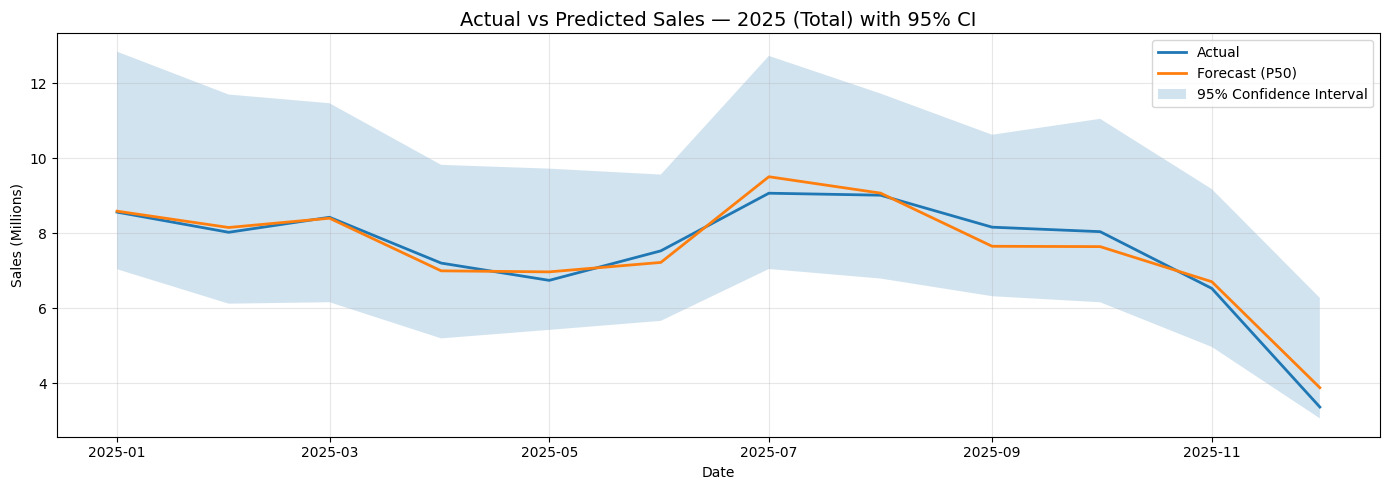

In [82]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Aggregate to monthly totals including CI
results_2025_monthly = (
    results_2025.groupby("DATE")
    .agg({
        "ACTUAL_SALES": "sum",
        "FORECAST_P50": "sum",
        "FORECAST_P05": "sum",
        "FORECAST_P95": "sum"
    })
    .reset_index()
)

plt.figure(figsize=(14,5))

# Actual
plt.plot(
    results_2025_monthly["DATE"],
    results_2025_monthly["ACTUAL_SALES"] / 1_000_000,
    linewidth=2,
    label="Actual",
)

# P50 forecast
plt.plot(
    results_2025_monthly["DATE"],
    results_2025_monthly["FORECAST_P50"] / 1_000_000,
    linewidth=2,
    label="Forecast (P50)",
)

# Shaded CI
plt.fill_between(
    results_2025_monthly["DATE"],
    results_2025_monthly["FORECAST_P05"] / 1_000_000,
    results_2025_monthly["FORECAST_P95"] / 1_000_000,
    alpha=0.2,
    label="95% Confidence Interval"
)

plt.title("Actual vs Predicted Sales — 2025 (Total) with 95% CI", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales (Millions)")


plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [83]:
# # Convert to millions and round for readability
# values_2025 = results_2025_monthly.copy()

# values_2025["ACTUAL_M"] = (values_2025["ACTUAL_SALES"] / 1_000_000).round(2)
# values_2025["P50_M"] = (values_2025["FORECAST_P50"] / 1_000_000).round(2)
# values_2025["P05_M"] = (values_2025["FORECAST_P05"] / 1_000_000).round(2)
# values_2025["P95_M"] = (values_2025["FORECAST_P95"] / 1_000_000).round(2)

# # Select only final reporting columns
# print(values_2025[["DATE", "ACTUAL_M", "P50_M", "P05_M", "P95_M"]])


# PLOT 2025 - Actual vs Predicted Sales - silhouette wise

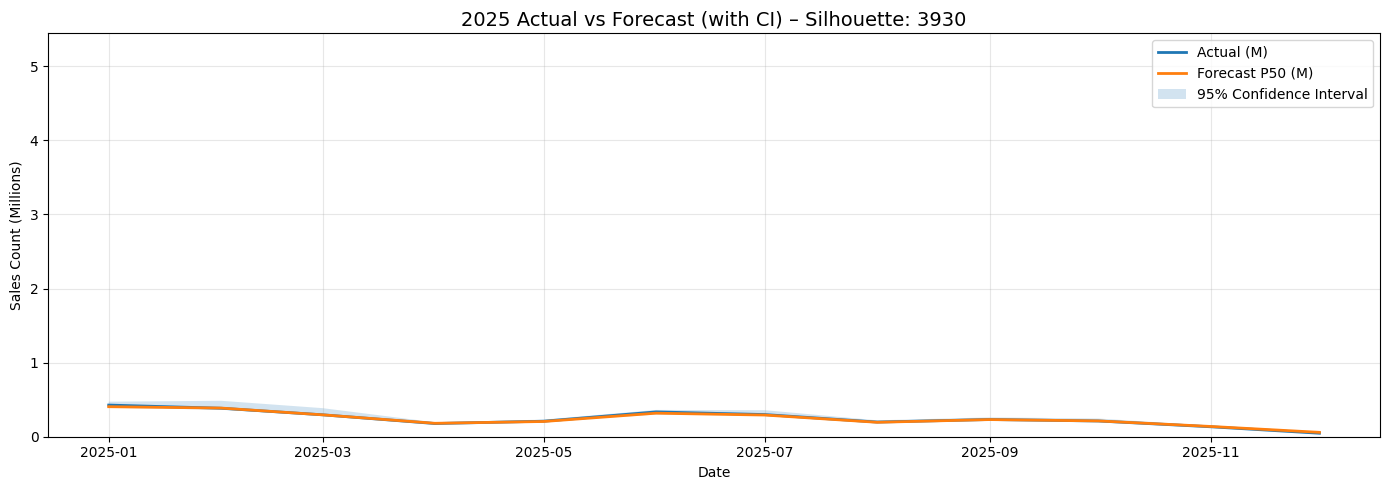

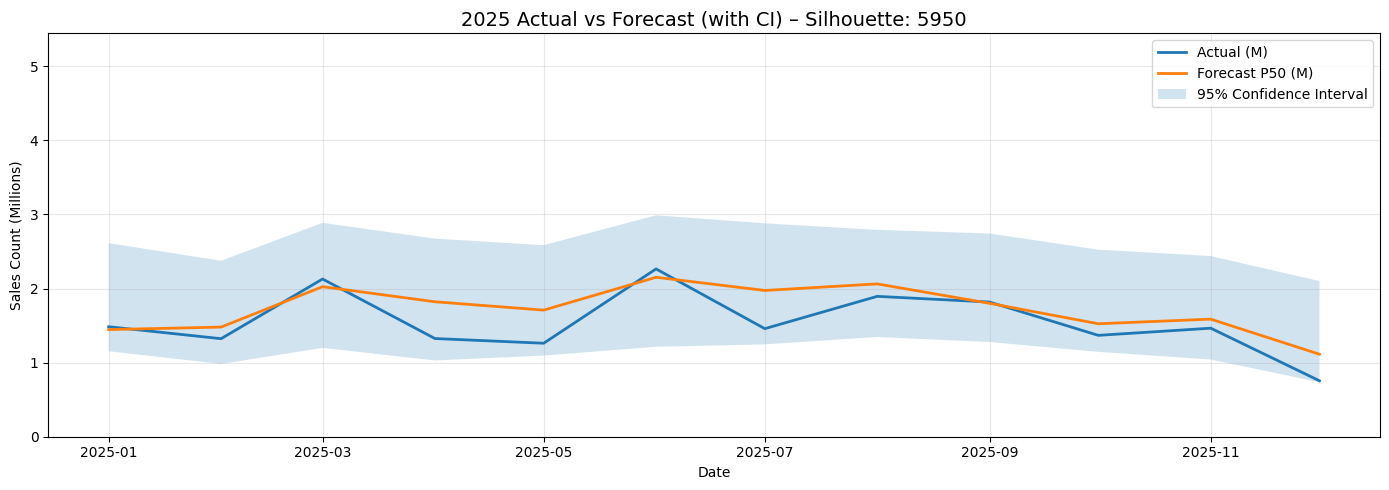

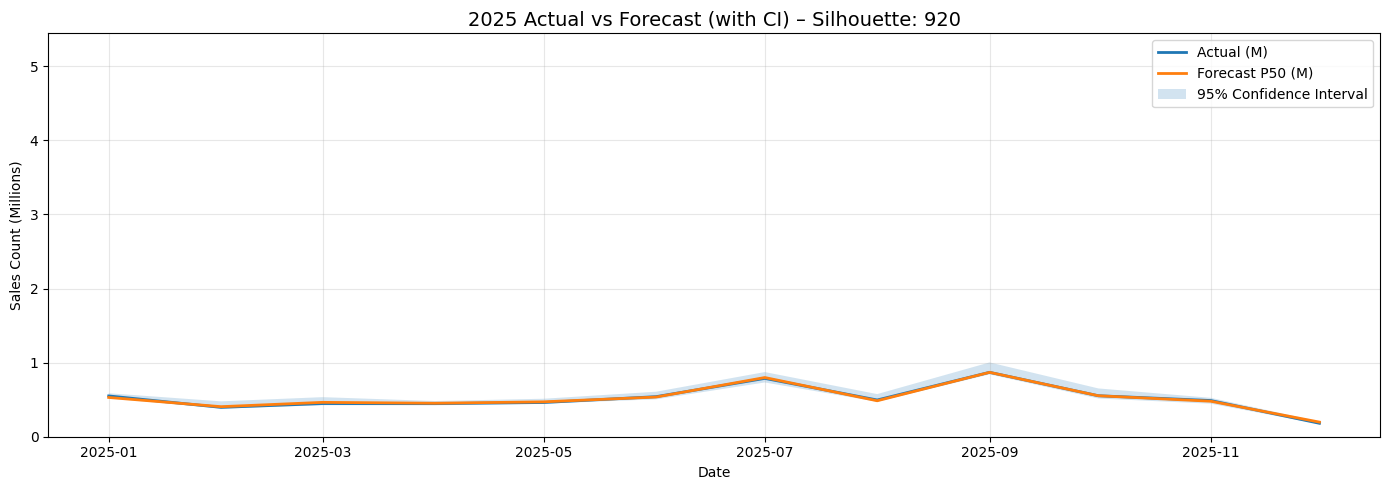

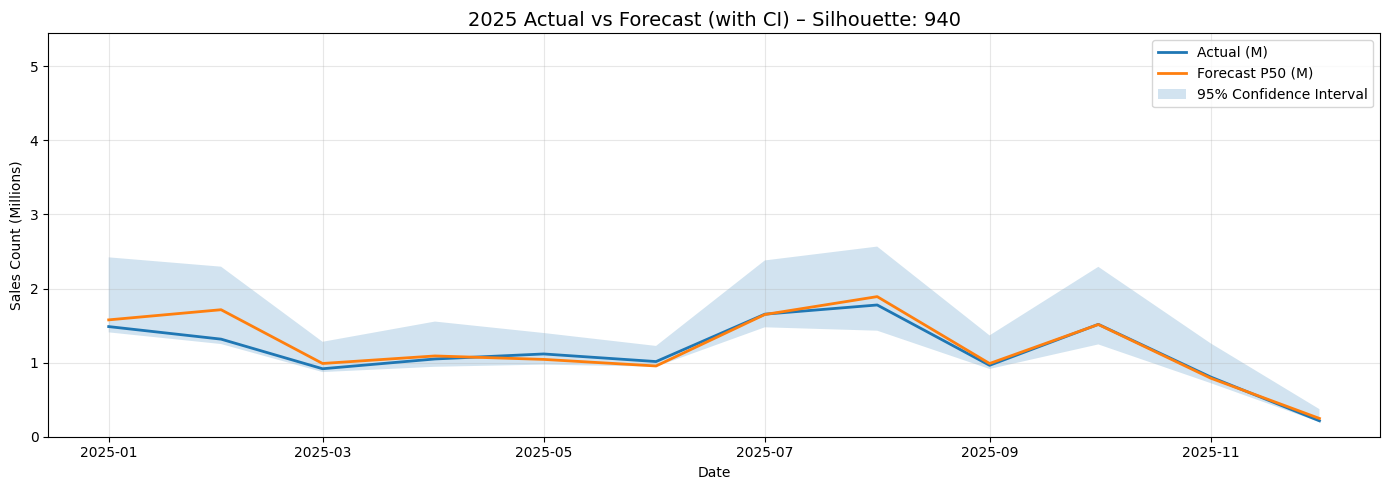

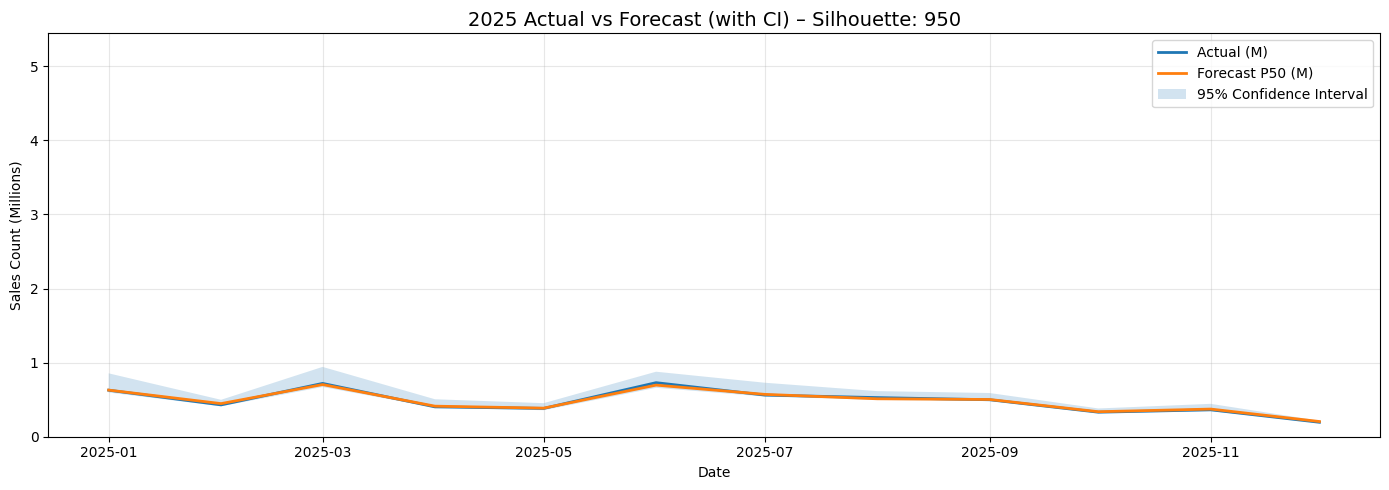

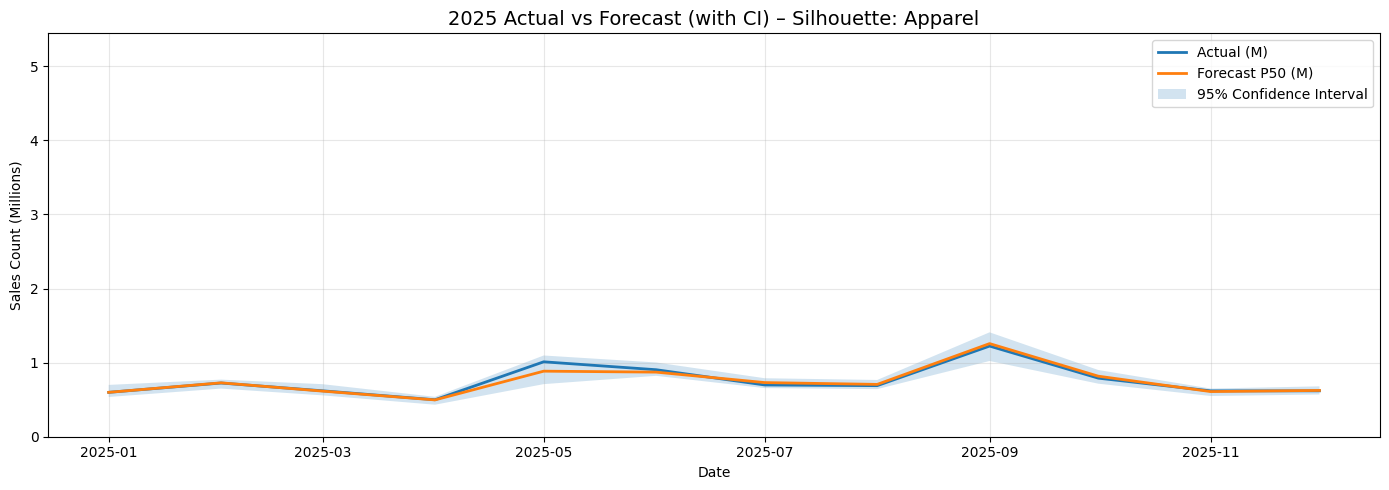

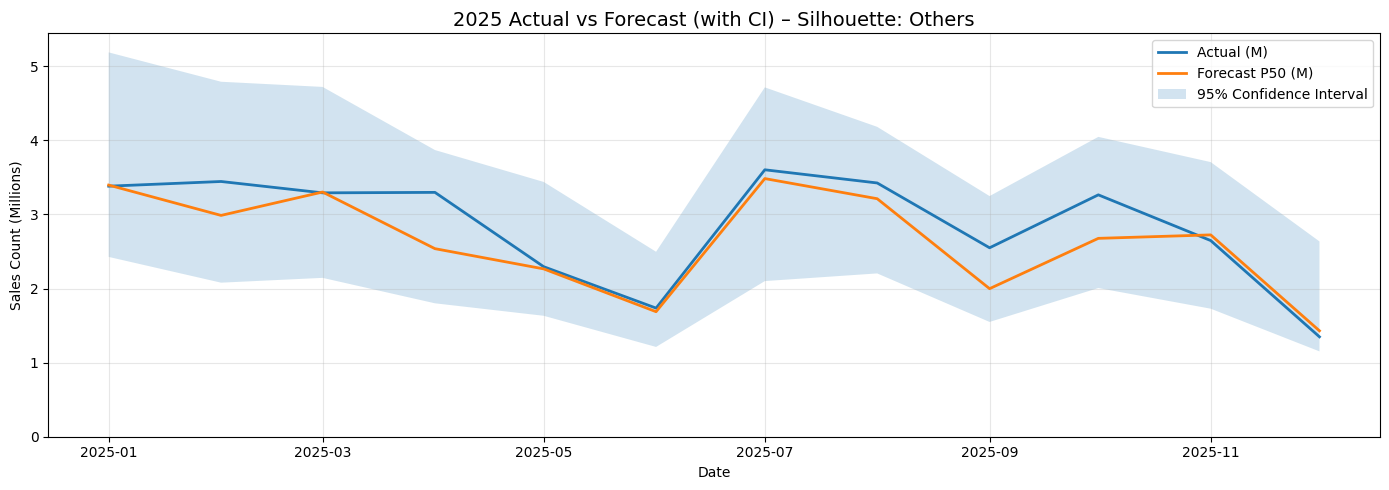

In [84]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ------------------------------
# 1. Aggregate per silhouette + date
# ------------------------------
silhouette_results_2025 = (
    results_2025.groupby(["SILHOUETTE", "DATE"])
    .agg({
        "ACTUAL_SALES": "sum",
        "FORECAST_P50": "sum",
        "FORECAST_P05": "sum",
        "FORECAST_P95": "sum"
    })
    .reset_index()
)

# ------------------------------
# 2. Compute global min/max across ALL DATA (actual + forecast)
# ------------------------------
all_sales_2025 = pd.concat([
    silhouette_results_2025["ACTUAL_SALES"],
    silhouette_results_2025["FORECAST_P50"],
    silhouette_results_2025["FORECAST_P05"],
    silhouette_results_2025["FORECAST_P95"]
])

global_min = all_sales_2025.min()
global_max = all_sales_2025.max()

# Add 5% margin
margin = (global_max - global_min) * 0.05

# Convert to millions for plotting
y_min_limit_M = (global_min - margin) / 1_000_000
y_max_limit_M = (global_max + margin) / 1_000_000
y_min_limit_M = max(0, y_min_limit_M)

# ------------------------------
# 3. Plot per silhouette WITH CI
# ------------------------------
for sil in silhouette_results_2025["SILHOUETTE"].unique():

    df_sil = (
        silhouette_results_2025[silhouette_results_2025["SILHOUETTE"] == sil]
        .sort_values("DATE")
    )

    # Convert values to millions
    actual_M  = df_sil["ACTUAL_SALES"] / 1_000_000
    p50_M     = df_sil["FORECAST_P50"] / 1_000_000
    p05_M     = df_sil["FORECAST_P05"] / 1_000_000
    p95_M     = df_sil["FORECAST_P95"] / 1_000_000

    plt.figure(figsize=(14,5))

    # Actual line
    plt.plot(df_sil["DATE"], actual_M, linewidth=2, label="Actual (M)")

    # Forecast P50
    plt.plot(df_sil["DATE"], p50_M, linewidth=2, label="Forecast P50 (M)")

    # Confidence Interval shading
    plt.fill_between(
        df_sil["DATE"],
        p05_M,
        p95_M,
        alpha=0.2,
        label="95% Confidence Interval"
    )

    plt.title(f"2025 Actual vs Forecast (with CI) – Silhouette: {sil}", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Sales Count (Millions)")

    # Global Y-axis limits for consistency
    plt.ylim(y_min_limit_M, y_max_limit_M)

    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# 2025 Forecast Metrics

In [118]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Extract Numpy arrays
y_true = results_2025["ACTUAL_SALES"].values
y_pred = results_2025["FORECAST_P50"].values   

# ----------------------------
# METRICS
# ----------------------------

# RMSE
rmse_2025 = np.sqrt(mean_squared_error(y_true, y_pred))

# MAE
mae_2025 = mean_absolute_error(y_true, y_pred)

# MAPE
mape_2025 = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100

# R²
r2_2025 = r2_score(y_true, y_pred)

# Directional accuracy
# Compare sign of month-over-month changes
direction_true = np.sign(np.diff(y_true))
direction_pred = np.sign(np.diff(y_pred))

# Avoid cases where actual change = 0
mask = direction_true != 0
directional_accuracy_2025 = np.mean(direction_true[mask] == direction_pred[mask]) * 100

# ----------------------------
# PRINT RESULTS
# ----------------------------
print("=======================================")
print("📊 2025 Forecast Metrics (P50)")
print("=======================================")
print(f"RMSE     : {rmse_2025:,.2f}")
print(f"MAE      : {mae_2025:,.2f}")
# print(f"MAPE     : {mape_2025:,.2f}%")
print(f"R²       : {r2_2025:,.4f}")
print(f"Direction Accuracy : {directional_accuracy_2025:,.2f}%")
print("=======================================\n")


📊 2025 Forecast Metrics (P50)
RMSE     : 17,708.33
MAE      : 1,982.49
R²       : 0.9179
Direction Accuracy : 84.42%



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Extract Numpy arrays
y_true = results_2025["ACTUAL_SALES"].values
y_pred = results_2025["FORECAST_P50"].values   

# ----------------------------
# METRICS
# ----------------------------

# RMSE
rmse_2025 = np.sqrt(mean_squared_error(y_true, y_pred))

# MAE
mae_2025 = mean_absolute_error(y_true, y_pred)

# MAPE
# mape_2025 = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100

# WAPE
wape_2025 = (np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))) * 100

# R²
r2_2025 = r2_score(y_true, y_pred)

# accuracy
# Compare sign of month-over-month changes
direction_true = np.sign(np.diff(y_true))
direction_pred = np.sign(np.diff(y_pred))

# Avoid cases where actual change = 0
mask = direction_true != 0
accuracy_2025 = np.mean(direction_true[mask] == direction_pred[mask]) * 100

# ----------------------------
# PRINT RESULTS
# ----------------------------
print("=======================================")
print("📊 2025 Forecast Metrics")
print("=======================================")
print(f"RMSE     : {rmse_2025:,.2f}")
print(f"MAE      : {mae_2025:,.2f}")
print(f"WAPE     : {wape_2025:,.2f}%")
print(f"R²       : {r2_2025:,.4f}")
print(f"Accuracy : {accuracy_2025:,.2f}%")
print("=======================================\n")

📊 2025 Forecast Metrics
RMSE     : 17,708.33
MAE      : 1,982.49
WAPE     : 16.50%
R²       : 0.9179
Accuracy : 84.42%



# *** FORECAST 2026 ***

In [86]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
import numpy as np

# ----------------------------------------------------
# Use df_fe (AS YOU WROTE), but drop NA lag rows
# ----------------------------------------------------
df_2026 = df_fe.sort_values('DATE').copy()

# Drop NA lag rows (your requested fix for Problem 6)
lag_cols = ['lag_1','lag_3','lag_6','lag_12','lag_24']
df_2026 = df_2026.dropna(subset=lag_cols)

# ----------------------------------------------------
# Your cutoff date (NO CHANGE)
# ----------------------------------------------------
train_cutoff = pd.to_datetime('2025-10-31')
train_df = df_2026[df_2026['DATE'] <= train_cutoff].copy()

# ----------------------------------------------------
# Target column (as you requested)
# ----------------------------------------------------
TARGET = 'SALES_COUNT_CLEAN'

# ----------------------------------------------------
# Categorical features (NO CHANGE)
# ----------------------------------------------------
CAT_FEATURES = [
    'REGION','COUNTRY','SALESORG',
    'SILHOUETTE','GENDER','SPORT'
]

# ----------------------------------------------------
# Feature list (your list, but REMOVED year_sin / year_cos)
# ----------------------------------------------------
FEATURES = CAT_FEATURES + [
    'lag_1','lag_3','lag_6','lag_12','lag_24',
    'rolling_3','rolling_6',
    'yoy_change',
    'month_sin','month_cos'
]

# ----------------------------------------------------
# CatBoost requires categorical indices (REQUIRED FIX)
# ----------------------------------------------------
cat_feature_indices = [
    FEATURES.index(c) for c in CAT_FEATURES
]

# ----------------------------------------------------
# Build train pool (NO CHANGE except correct cat_features)
# ----------------------------------------------------
train_pool = Pool(
    train_df[FEATURES],
    train_df[TARGET],
    cat_features=cat_feature_indices
)



In [87]:
# ============================================
# 2026 MODELS WITH CONFIDENCE INTERVALS
# ============================================

# ---------- P50 model (main forecast) ----------
model_p50_2026 = CatBoostRegressor(
    loss_function="RMSE",
    depth=8,
    learning_rate=0.05,
    n_estimators=1000,
    random_seed=42,
    subsample=0.8,
    colsample_bylevel=0.8,
    od_type="Iter",
    od_wait=50,
    verbose=100
)

model_p50_2026.fit(
    train_pool
)



0:	learn: 73058.7400981	total: 86.6ms	remaining: 1m 26s
100:	learn: 21275.4724930	total: 6.32s	remaining: 56.3s
200:	learn: 19178.0458630	total: 11.5s	remaining: 45.8s
300:	learn: 17743.1117298	total: 17.1s	remaining: 39.7s
400:	learn: 16470.1122261	total: 23.5s	remaining: 35.1s
500:	learn: 15295.0728103	total: 29.8s	remaining: 29.7s
600:	learn: 14156.4865469	total: 36.1s	remaining: 24s
700:	learn: 13150.5151267	total: 42.9s	remaining: 18.3s
800:	learn: 12438.9420471	total: 49.3s	remaining: 12.3s
900:	learn: 11610.1624176	total: 55.7s	remaining: 6.12s
999:	learn: 10881.6006421	total: 1m 1s	remaining: 0us


In [88]:
# ---------- P05 model (lower bound) ----------
model_p05_2026 = CatBoostRegressor(
    loss_function="Quantile:alpha=0.05",
    depth=8,
    learning_rate=0.05,
    n_estimators=1000,
    random_seed=42,
    subsample=0.8,
    colsample_bylevel=0.8,
    verbose=100
)

model_p05_2026.fit(
    train_pool
)



0:	learn: 669.9555310	total: 66.6ms	remaining: 1m 6s
100:	learn: 605.6316423	total: 6.94s	remaining: 1m 1s
200:	learn: 500.6857497	total: 13.9s	remaining: 55.4s
300:	learn: 415.3608296	total: 20.8s	remaining: 48.2s
400:	learn: 349.8865300	total: 27.7s	remaining: 41.4s
500:	learn: 301.0654903	total: 34.6s	remaining: 34.4s
600:	learn: 263.7379736	total: 41.9s	remaining: 27.8s
700:	learn: 232.3306718	total: 48.7s	remaining: 20.8s
800:	learn: 217.8461731	total: 55.5s	remaining: 13.8s
900:	learn: 204.2951411	total: 1m 2s	remaining: 6.84s
999:	learn: 194.7629865	total: 1m 8s	remaining: 0us


In [89]:
# ---------- P95 model (upper bound) ----------
model_p95_2026 = CatBoostRegressor(
    loss_function="Quantile:alpha=0.95",
    depth=8,
    learning_rate=0.05,
    n_estimators=1000,
    random_seed=42,
    subsample=0.8,
    colsample_bylevel=0.8,
    verbose=100
)

model_p95_2026.fit(
    train_pool
)


0:	learn: 7916.8117251	total: 62.9ms	remaining: 1m 2s
100:	learn: 611.2233765	total: 6.89s	remaining: 1m 1s
200:	learn: 557.1496792	total: 13.3s	remaining: 52.9s
300:	learn: 530.2945710	total: 20.1s	remaining: 46.7s
400:	learn: 502.5522730	total: 26.8s	remaining: 40.1s
500:	learn: 487.1786967	total: 33.9s	remaining: 33.7s
600:	learn: 480.7962091	total: 40.9s	remaining: 27.2s
700:	learn: 473.7546803	total: 47.2s	remaining: 20.1s
800:	learn: 469.9468958	total: 57.3s	remaining: 14.2s
900:	learn: 464.4538147	total: 1m 6s	remaining: 7.3s
999:	learn: 461.9782275	total: 1m 13s	remaining: 0us


In [90]:
from tqdm import tqdm
import numpy as np
import pandas as pd

# ---------------------------------------------------------
# 1) USE THE CORRECT DATASET (df_grouped)
# ---------------------------------------------------------
df_hist = df_grouped.copy().sort_values("DATE")

# ---------------------------------------------------------
# 2) APPLY YOUR TRAIN CUTOFF DATE
# ---------------------------------------------------------
train_cutoff = pd.to_datetime("2025-10-31")
df_hist = df_hist[df_hist["DATE"] <= train_cutoff].reset_index(drop=True)

# ---------------------------------------------------------
# 3) CORRECT GROUPING COLUMNS (YOUR PIPELINE)
# ---------------------------------------------------------
group_cols = [
    "REGION",
    "COUNTRY",
    "SALESORG",
    "SILHOUETTE",
    "GENDER",
    "SPORT"
]

# convert to string for stable group keys
for c in group_cols:
    df_hist[c] = df_hist[c].astype(str)

# ---------------------------------------------------------
# 4) GET UNIQUE GROUPS
# ---------------------------------------------------------
groups_df = df_hist[group_cols].drop_duplicates().reset_index(drop=True)
groups_list = [tuple(row) for row in groups_df.values.tolist()]

# ---------------------------------------------------------
# 5) BUILD HISTORY FOR EACH GROUP
# ---------------------------------------------------------
group_hist = {}

for key in tqdm(groups_list, desc="Building group history", unit="group"):

    # build mask for the group
    mask = np.ones(len(df_hist), dtype=bool)
    for col, val in zip(group_cols, key):
        mask &= (df_hist[col] == val)

    sub = df_hist.loc[mask].copy()

    if sub.empty:
        group_hist[key] = pd.Series(dtype=float)
        continue

    # sorted history
    sub = sub.sort_values("DATE")

    # FINAL: correct target column
    series = sub.set_index("DATE")["SALES_COUNT_CLEAN"].astype(float)

    group_hist[key] = series.copy()

# ---------------------------------------------------------
# 6) MEDIAN FILLER IF ANY GROUP LACKS HISTORY
# ---------------------------------------------------------
median_fill = float(df_hist["SALES_COUNT_CLEAN"].median())

# ---------------------------------------------------------
# 7) CYCLICAL MONTH FEATURE (NO YEAR ENCODING)
# ---------------------------------------------------------
def cyclical_month(dt):
    m = dt.month
    month_sin = np.sin(2*np.pi*(m-1)/12)
    month_cos = np.cos(2*np.pi*(m-1)/12)
    return month_sin, month_cos

print("\nGroup history construction complete.")
print(f"Total groups prepared: {len(group_hist)}")


Building group history: 100%|██████████| 894/894 [00:27<00:00, 32.08group/s]


Group history construction complete.
Total groups prepared: 894


In [91]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from catboost import Pool

# ------------------------------------------
# FORECAST RANGE
# ------------------------------------------
future_start = pd.to_datetime('2025-11-01')
future_end   = pd.to_datetime('2026-12-01')
future_dates = pd.date_range(future_start, future_end, freq='MS')

pred_records = []

# --------------------------------------------------------------------
# Helper: safe lag getter
# --------------------------------------------------------------------
def safe_get_lag(hist_series: pd.Series, date: pd.Timestamp, months: int):
    if hist_series is None or hist_series.empty:
        return np.nan
    target = date - pd.DateOffset(months=months)
    if target in hist_series.index:
        val = hist_series.loc[target]
        return float(val.squeeze()) if isinstance(val, (pd.Series, pd.DataFrame)) else float(val)
    return np.nan

# --------------------------------------------------------------------
# Helper: cyclical month
# --------------------------------------------------------------------
def cyclical_month(dt):
    m = dt.month
    return np.sin(2*np.pi*(m-1)/12), np.cos(2*np.pi*(m-1)/12)

# --------------------------------------------------------------------
# MAIN ITERATIVE FORECAST LOOP — NOW WITH CI
# --------------------------------------------------------------------
for current_date in tqdm(future_dates, desc='Forecast months', unit='month'):
    batch_rows = []

    for key in groups_list:

        hist = group_hist.get(key, pd.Series(dtype=float))

        if not hist.empty and not np.issubdtype(hist.index.dtype, np.datetime64):
            hist.index = pd.to_datetime(hist.index)

        # ---- LAGS ----
        lag_1  = safe_get_lag(hist, current_date, 1)
        lag_3  = safe_get_lag(hist, current_date, 3)
        lag_6  = safe_get_lag(hist, current_date, 6)
        lag_12 = safe_get_lag(hist, current_date, 12)
        lag_24 = safe_get_lag(hist, current_date, 24)

        # ---- ROLLING ----
        end_1   = current_date - pd.DateOffset(months=1)
        start_3 = current_date - pd.DateOffset(months=3)
        start_6 = current_date - pd.DateOffset(months=6)

        try:
            window3 = hist.loc[start_3:end_1].mean()
            window3 = float(window3) if not pd.isna(window3) else np.nan
        except:
            window3 = np.nan

        try:
            window6 = hist.loc[start_6:end_1].mean()
            window6 = float(window6) if not pd.isna(window6) else np.nan
        except:
            window6 = np.nan

        # ---- MONTH FEATURES ----
        month_sin, month_cos = cyclical_month(current_date)

        # ---- YOY ----
        if not pd.isna(lag_1) and not pd.isna(lag_12):
            yoy_change = (lag_1 - lag_12) / (lag_12 + 1e-6)
        else:
            yoy_change = 0.0

        # ---- BUILD FEATURES ----
        row = {col: val for col, val in zip(group_cols, key)}
        row.update({
            'DATE': current_date,
            'lag_1':  lag_1  if not pd.isna(lag_1)  else median_fill,
            'lag_3':  lag_3  if not pd.isna(lag_3)  else median_fill,
            'lag_6':  lag_6  if not pd.isna(lag_6)  else median_fill,
            'lag_12': lag_12 if not pd.isna(lag_12) else median_fill,
            'lag_24': lag_24 if not pd.isna(lag_24) else median_fill,
            'rolling_3': window3 if not pd.isna(window3) else median_fill,
            'rolling_6': window6 if not pd.isna(window6) else median_fill,
            'month_sin': month_sin,
            'month_cos': month_cos,
            'yoy_change': yoy_change
        })

        batch_rows.append(row)

    # -------------------------------
    # PREPARE BATCH FOR MODEL
    # -------------------------------
    batch = pd.DataFrame(batch_rows)
    for c in group_cols:
        batch[c] = batch[c].astype(str)

    X_batch = batch[FEATURES].copy().fillna(median_fill)
    batch_pool = Pool(X_batch, cat_features=cat_feature_indices)

    # -------------------------------
    # THREE PREDICTIONS: p50, p05, p95
    # -------------------------------
    pred_p50 = model_p50_2026.predict(batch_pool)
    pred_p05 = model_p05_2026.predict(batch_pool)
    pred_p95 = model_p95_2026.predict(batch_pool)

    # -------------------------------
    # UPDATE HISTORY USING ONLY p50
    # -------------------------------
    for i in range(len(batch)):

        rec_key  = tuple(batch.loc[i, group_cols].values)
        rec_date = batch.loc[i, 'DATE']

        if rec_key not in group_hist:
            group_hist[rec_key] = pd.Series(dtype=float)

        # p50 goes into history for iterative forecasting
        group_hist[rec_key].at[rec_date] = float(pred_p50[i])

        # Append final output
        pred_records.append({
            **{col: batch.loc[i, col] for col in group_cols},
            'DATE': rec_date,
            'FORECAST_P50': float(pred_p50[i]),
            'FORECAST_P05': float(pred_p05[i]),
            'FORECAST_P95': float(pred_p95[i]),
            'CI_LOWER': float(pred_p05[i]),
            'CI_UPPER': float(pred_p95[i]),
            'CI_WIDTH': float(pred_p95[i] - pred_p05[i]),
        })

# -------------------------------
# FINAL FORECAST DATAFRAME
# -------------------------------
forecast_2026 = pd.DataFrame(pred_records)
forecast_2026 = forecast_2026.sort_values(['DATE'] + group_cols).reset_index(drop=True)

print("Forecasting complete.")
print("Rows:", len(forecast_2026))


Forecast months: 100%|██████████| 14/14 [00:33<00:00,  2.38s/month]

Forecasting complete.
Rows: 12516


In [92]:
# ⭐ Final forecast from your iterative loop
forecast_df = forecast_2026.copy()

# Sort nicely for downstream loads (Snowflake, Power BI, etc.)
forecast_df = forecast_df.sort_values(['DATE'] + group_cols).reset_index(drop=True)

# Save CSV — this file now contains:
# FORECAST_P50, FORECAST_P05, FORECAST_P95, CI_LOWER, CI_UPPER, CI_WIDTH
output_path = "/home/azureuser/cloudfiles/code/Users/aishvary/forecast_2026_aish.csv"

forecast_df.to_csv(output_path, index=False)

print(f"Saved forecast_2026_aish.csv — rows: {len(forecast_df)}")


Saved forecast_2026_aish.csv — rows: 12516


In [93]:
forecast_df.columns
print("Columns forecasted")

Columns forecasted


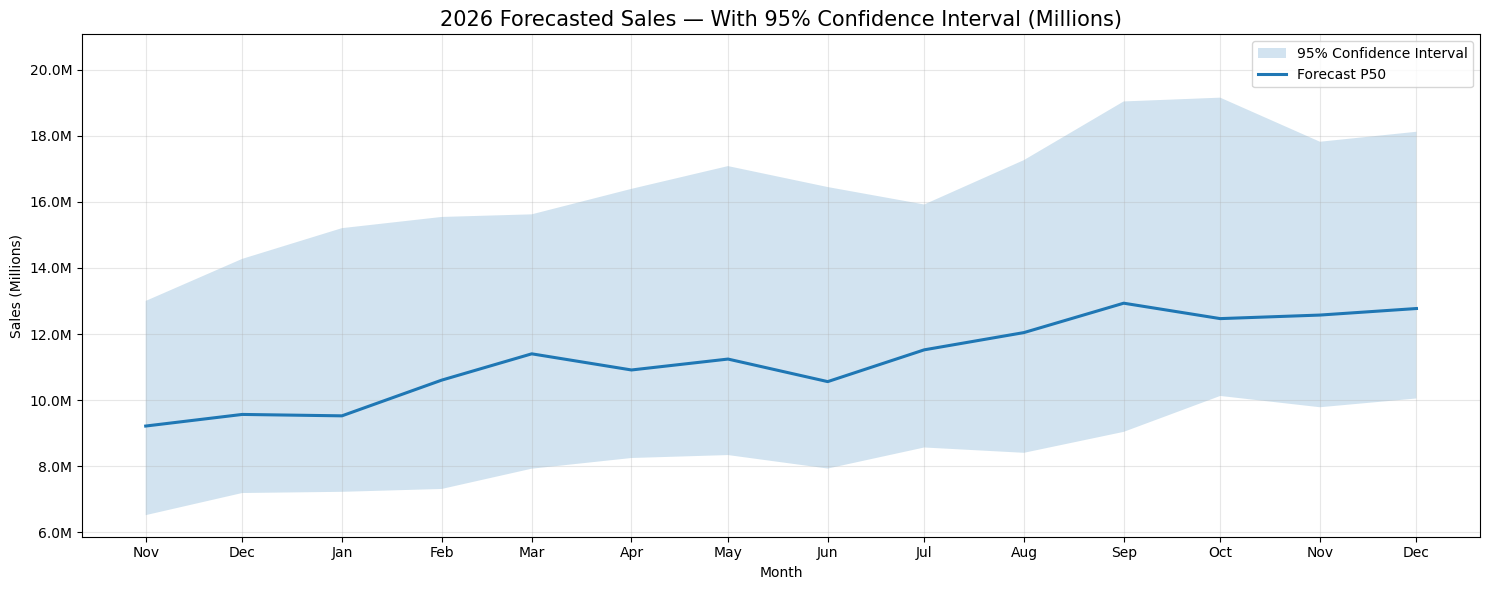

In [94]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

# Aggregate to monthly totals
fc_agg = (
    forecast_df
    .groupby("DATE")
    .agg({
        "FORECAST_P50": "sum",
        "FORECAST_P05": "sum",
        "FORECAST_P95": "sum"
    })
    .reset_index()
)

# Convert to millions
fc_agg["P50_M"] = fc_agg["FORECAST_P50"] / 1_000_000
fc_agg["P05_M"] = fc_agg["FORECAST_P05"] / 1_000_000
fc_agg["P95_M"] = fc_agg["FORECAST_P95"] / 1_000_000

plt.figure(figsize=(15,6))

# Shaded CI band (in millions)
plt.fill_between(
    fc_agg["DATE"],
    fc_agg["P05_M"],
    fc_agg["P95_M"],
    alpha=0.2,
    label="95% Confidence Interval"
)

# Main forecast line (P50 in millions)
plt.plot(
    fc_agg["DATE"],
    fc_agg["P50_M"],
    linewidth=2.2,
    label="Forecast P50"
)

# --- FORMAT Y-AXIS IN MILLIONS (1M, 2M, 3M) ---
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.1f}M'))

# Start Y-axis at 1M if values exceed that
y_min = max(1.0, fc_agg["P05_M"].min() * 0.9)
y_max = fc_agg["P95_M"].max() * 1.1
plt.ylim(y_min, y_max)

plt.title("2026 Forecasted Sales — With 95% Confidence Interval (Millions)", fontsize=15)
plt.xlabel("Month")
plt.ylabel("Sales (Millions)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
# --- ENHANCEMENT: Format X-Axis to show Month names ---

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b')) # %b is the locale's abbreviated month name
ax.xaxis.set_major_locator(mdates.MonthLocator()) # Ensure a tick for every month
plt.show()


# Full Sales History (2009-2026) with 2026 Forecast Overlay

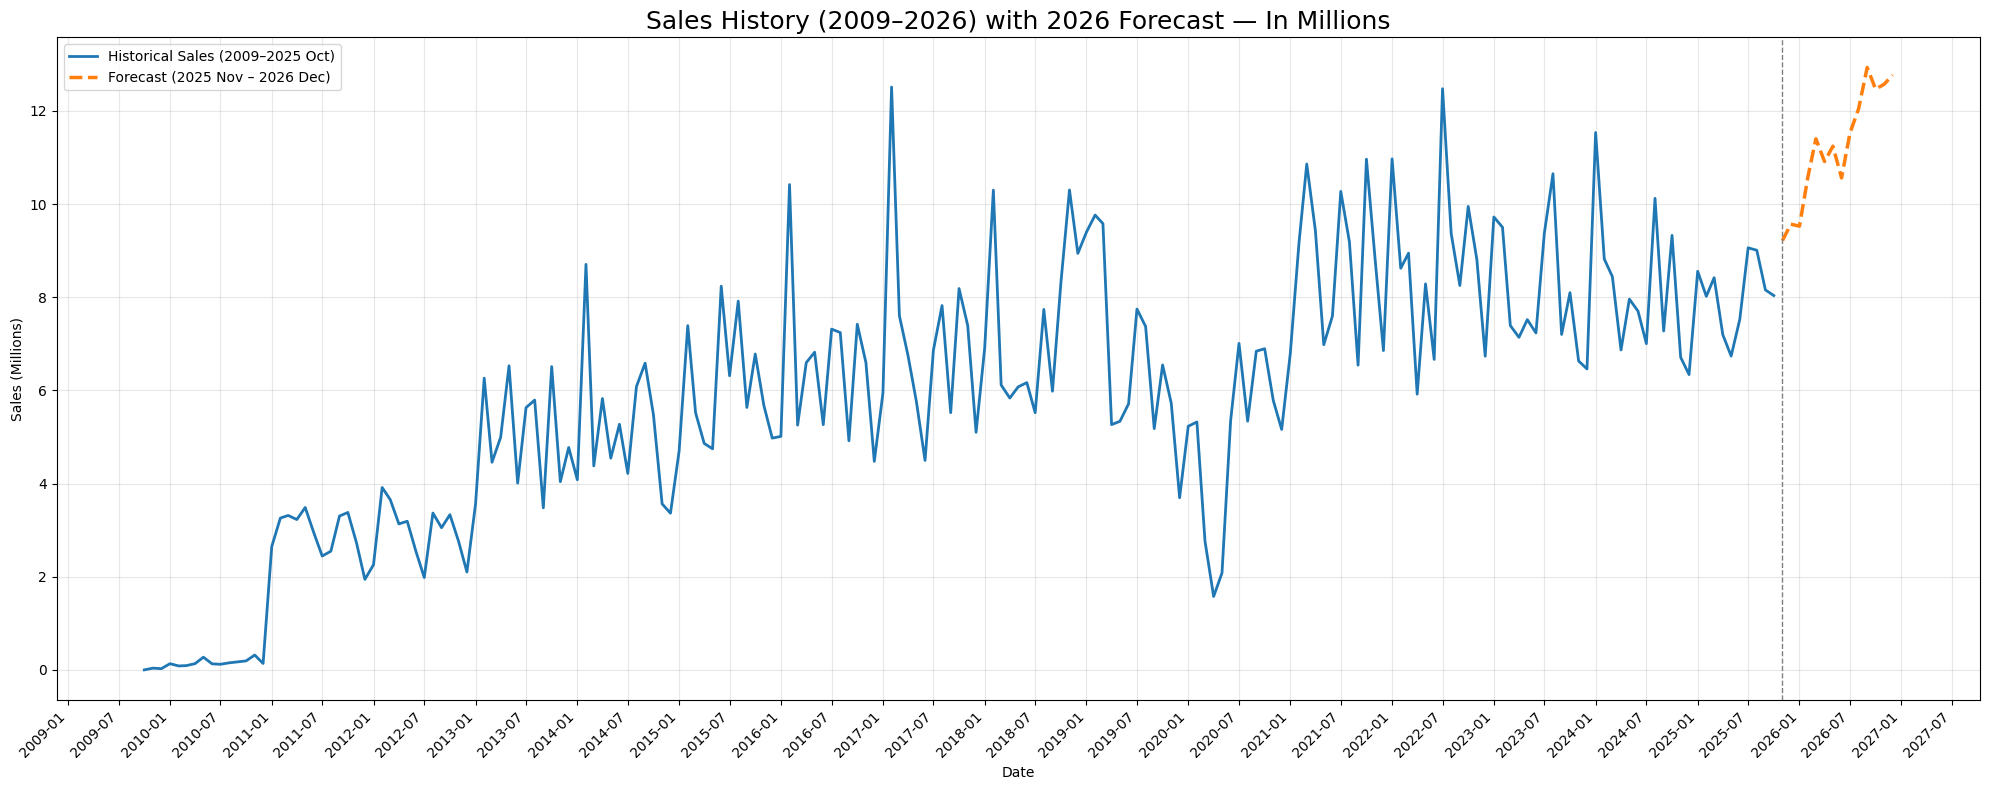

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- 1. HISTORICAL DATA (actuals until 2025 Oct) ---
actuals_full = (
    df_grouped.groupby("DATE")["SALES_COUNT_CLEAN"]
    .sum()
    .reset_index()
    .rename(columns={"SALES_COUNT_CLEAN": "Total_Sales"})
)

actuals_full["Total_Sales_M"] = actuals_full["Total_Sales"] / 1_000_000
actuals_full = actuals_full[actuals_full["DATE"] <= "2025-10-01"]


# --- 2. FORECAST DATA (2025 Nov – 2026 Dec) ---
forecast_monthly = (
    forecast_df.groupby("DATE")["FORECAST_P50"]
    .sum()
    .reset_index()
    .rename(columns={"FORECAST_P50": "Total_Sales"})
)

forecast_monthly["Total_Sales_M"] = forecast_monthly["Total_Sales"] / 1_000_000


# --- 3. Combine ---
combined_plot_df = pd.concat([actuals_full, forecast_monthly], ignore_index=True)
combined_plot_df = combined_plot_df.sort_values("DATE").reset_index(drop=True)


# --- 4. Plot ---
plt.figure(figsize=(20, 8))

# Actual
plt.plot(
    actuals_full["DATE"], actuals_full["Total_Sales_M"],
    label="Historical Sales (2009–2025 Oct)",
    linewidth=2
)

# Forecast
plt.plot(
    forecast_monthly["DATE"], forecast_monthly["Total_Sales_M"],
    label="Forecast (2025 Nov – 2026 Dec)",
    linewidth=2.5,
    linestyle='--'
)

# Cutoff line
plt.axvline(x=pd.to_datetime("2025-10-31"), color="gray", linestyle="--", linewidth=1)

plt.title("Sales History (2009–2026) with 2026 Forecast — In Millions", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Sales (Millions)")
plt.grid(alpha=0.3)
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate(rotation=45)

plt.tight_layout()
plt.show()


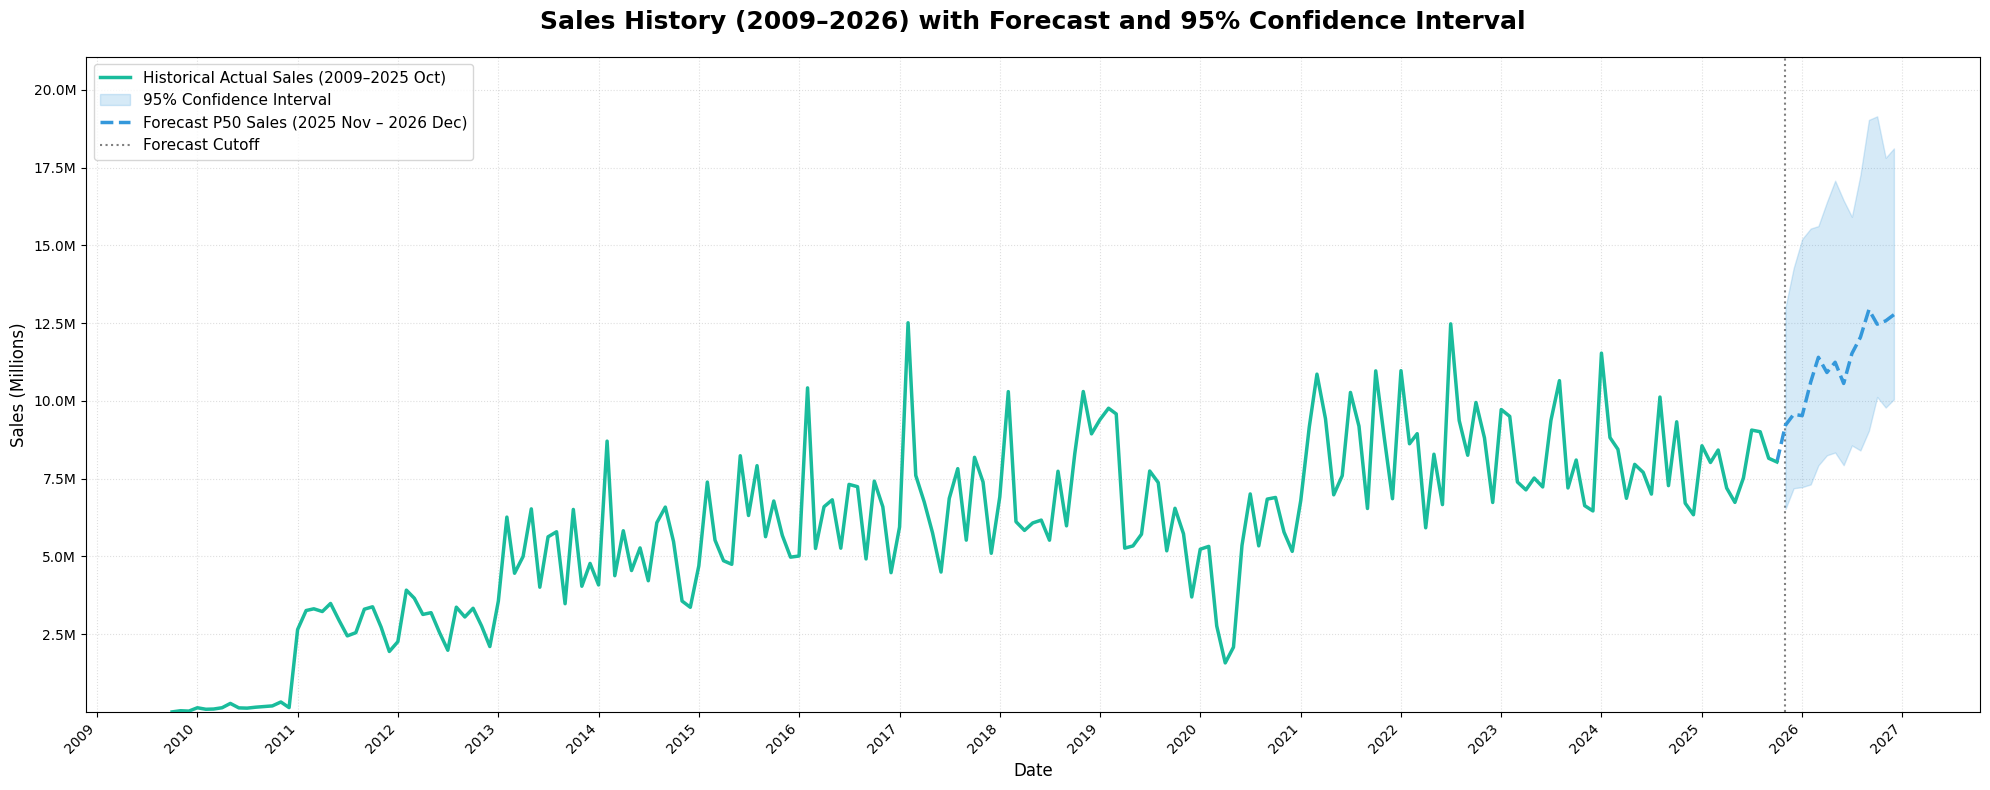

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np

# --- Data Preparation ---

# 1. Prepare Historical (Actual) Data (2009-01 to 2025-10)
# Assuming df_grouped and SALES_COUNT_CLEAN are available and correct for historical data
actuals_full = (
    df_grouped.groupby("DATE")["SALES_COUNT_CLEAN"]
    .sum()
    .reset_index()
    .rename(columns={"SALES_COUNT_CLEAN": "Total_Sales"})
)
actuals_full["Total_Sales_M"] = actuals_full["Total_Sales"] / 1_000_000
actuals_full["Source"] = "Actual"

train_cutoff = pd.to_datetime('2025-10-01')
actuals_full = actuals_full[actuals_full["DATE"] <= train_cutoff]


# 2. Forecast Data (2025-11 to 2026-12) - Aggregating P50, P05, P95
# This block is essential for the confidence interval!
forecast_ci = (
    forecast_df
    .groupby("DATE")
    .agg({
        "FORECAST_P50": "sum",
        "FORECAST_P05": "sum",
        "FORECAST_P95": "sum"
    })
    .reset_index()
)

# Convert to Millions and rename P50 to match 'Total_Sales_M'
forecast_ci["Total_Sales"] = forecast_ci["FORECAST_P50"]
forecast_ci["Total_Sales_M"] = forecast_ci["Total_Sales"] / 1_000_000
forecast_ci["P05_M"] = forecast_ci["FORECAST_P05"] / 1_000_000
forecast_ci["P95_M"] = forecast_ci["FORECAST_P95"] / 1_000_000
forecast_ci["Source"] = "Forecast"


# 3. Combine for plotting
# We only need to combine the historical data with the P50 forecast for the line plot
combined_plot_df = pd.concat(
    [actuals_full, forecast_ci.drop(columns=["FORECAST_P05", "FORECAST_P95", "Total_Sales", "P05_M", "P95_M"])],
    ignore_index=True
).sort_values("DATE").reset_index(drop=True)

# -------------------------------------------------------------
# --- 4. Plotting (Historical Line + Forecast Line + CI Band) ---
# -------------------------------------------------------------

plt.figure(figsize=(20, 8))
ax = plt.gca() # Get the current axes once

cutoff_date_point = pd.to_datetime('2025-10-01')
forecast_start = pd.to_datetime('2025-11-01')

# --- PLOT 1: Historical Segment ---
actual_segment = combined_plot_df[
    combined_plot_df["DATE"] <= cutoff_date_point
]
plt.plot(
    actual_segment["DATE"],
    actual_segment["Total_Sales_M"],
    label="Historical Actual Sales (2009–2025 Oct)",
    linewidth=2.5,
    color="#1abc9c", # Teal color
    zorder=5
)

# --- PLOT 2: Forecast Confidence Interval (CI) Band ---
plt.fill_between(
    forecast_ci["DATE"],
    forecast_ci["P05_M"],
    forecast_ci["P95_M"],
    alpha=0.2,
    color="#3498db", # Light Blue for the CI
    label="95% Confidence Interval",
    zorder=3 # Put it behind the line
)

# --- PLOT 3: Forecast Line Segment (P50) ---
forecast_segment = combined_plot_df[
    combined_plot_df["DATE"] >= forecast_start
]
# Attach last actual point for smooth continuity
last_actual = actual_segment[actual_segment["DATE"] == cutoff_date_point]
if not last_actual.empty:
    forecast_segment = pd.concat(
        [last_actual, forecast_segment]
    ).drop_duplicates(subset=["DATE"]).sort_values("DATE")

plt.plot(
    forecast_segment["DATE"],
    forecast_segment["Total_Sales_M"],
    label="Forecast P50 Sales (2025 Nov – 2026 Dec)",
    linewidth=2.5,
    linestyle='--',
    color="#3498db", # Blue for the forecast line
    zorder=4
)

# --- PLOT 4: Cutoff Line ---
plt.axvline(
    x=pd.to_datetime('2025-10-31'),
    color='gray',
    linestyle=':',
    linewidth=1.5,
    label="Forecast Cutoff"
)

# -------------------------
# --- Formatting and Aesthetics ---
# -------------------------

plt.title(
    "Sales History (2009–2026) with Forecast and 95% Confidence Interval",
    fontsize=18,
    weight="bold",
    pad=20
)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales (Millions)", fontsize=12)
plt.grid(alpha=0.4, linestyle=':')

plt.legend(fontsize=11, loc='upper left')

# FORMAT Y-AXIS AS 1M, 2M, 3M, ...
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.1f}M"))

# Set clean bounds
y_min = max(0, actuals_full["Total_Sales_M"].min() * 0.9)
y_max = forecast_ci["P95_M"].max() * 1.1
plt.ylim(y_min, y_max)

# X axis formatting (yearly ticks)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gcf().autofmt_xdate(rotation=45)

plt.tight_layout()
plt.show()

# 2027 Forecast

In [97]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
import numpy as np

# ----------------------------------------------------
# Use df_fe (feature engineered), drop NA lag rows
# ----------------------------------------------------
df_2027 = df_fe.sort_values('DATE').copy()

lag_cols = ['lag_1','lag_3','lag_6','lag_12','lag_24']
df_2027 = df_2027.dropna(subset=lag_cols)

# ----------------------------------------------------
# TRAIN CUTOFF (same as 2026 → last actual month)
# ----------------------------------------------------
train_cutoff = pd.to_datetime('2025-10-31')

train_df = df_2027[df_2027['DATE'] <= train_cutoff].copy()

print("Training rows for 2027 model:", train_df.shape)
print("Training date range:", train_df['DATE'].min(), "→", train_df['DATE'].max())

# ----------------------------------------------------
# Target (same as 2026)
# ----------------------------------------------------
TARGET = 'SALES_COUNT_CLEAN'

# ----------------------------------------------------
# Categorical features
# ----------------------------------------------------
CAT_FEATURES = [
    'REGION','COUNTRY','SALESORG',
    'SILHOUETTE','GENDER','SPORT'
]

# ----------------------------------------------------
# Numerical features (same as 2026 model)
# ----------------------------------------------------
FEATURES = CAT_FEATURES + [
    'lag_1','lag_3','lag_6','lag_12','lag_24',
    'rolling_3','rolling_6',
    'yoy_change',
    'month_sin','month_cos'
]

# ----------------------------------------------------
# CatBoost categorical feature indices
# ----------------------------------------------------
cat_feature_indices = [FEATURES.index(c) for c in CAT_FEATURES]

# ----------------------------------------------------
# Train Pool
# ----------------------------------------------------
train_pool = Pool(
    train_df[FEATURES],
    train_df[TARGET],
    cat_features=cat_feature_indices
)




Training rows for 2027 model: (85107, 24)
Training date range: 2009-10-01 00:00:00 → 2025-10-01 00:00:00


In [98]:
# -------------------------------
# 2027 — THREE MODEL SETUP
# -------------------------------

model_p50_2027 = CatBoostRegressor(
    loss_function="RMSE",
    depth=6,
    learning_rate=0.05,
    iterations=1000,
    random_seed=42,
    verbose=100
)

model_p05_2027 = CatBoostRegressor(
    loss_function="Quantile:alpha=0.05",
    depth=6,
    learning_rate=0.05,
    iterations=1000,
    random_seed=42,
    verbose=100
)

model_p95_2027 = CatBoostRegressor(
    loss_function="Quantile:alpha=0.95",
    depth=6,
    learning_rate=0.05,
    iterations=1000,
    random_seed=42,
    verbose=100
)

# Fit all 3 models
model_p50_2027.fit(train_pool)
model_p05_2027.fit(train_pool)
model_p95_2027.fit(train_pool)


0:	learn: 72989.1747880	total: 48.4ms	remaining: 48.4s
100:	learn: 23441.4109330	total: 5.08s	remaining: 45.2s
200:	learn: 21667.2978247	total: 8.95s	remaining: 35.6s
300:	learn: 20228.6170702	total: 12.9s	remaining: 30s
400:	learn: 19310.1423032	total: 16.9s	remaining: 25.3s
500:	learn: 18494.3401510	total: 21.3s	remaining: 21.2s
600:	learn: 17614.2647269	total: 25.8s	remaining: 17.1s
700:	learn: 16573.3515812	total: 30.5s	remaining: 13s
800:	learn: 15836.0620843	total: 35.3s	remaining: 8.77s
900:	learn: 15312.8787572	total: 39.9s	remaining: 4.38s
999:	learn: 14837.1129015	total: 44.4s	remaining: 0us
0:	learn: 670.2823961	total: 55.8ms	remaining: 55.8s
100:	learn: 622.2184264	total: 5.86s	remaining: 52.2s
200:	learn: 545.0252044	total: 11.5s	remaining: 45.9s
300:	learn: 466.3913751	total: 17.2s	remaining: 40s
400:	learn: 389.1754030	total: 23s	remaining: 34.3s
500:	learn: 319.6819091	total: 29.6s	remaining: 29.5s
600:	learn: 280.9061235	total: 35.4s	remaining: 23.5s
700:	learn: 239.31

In [99]:
from tqdm import tqdm
import numpy as np
import pandas as pd

# ---------------------------------------------------------
# 1) USE THE CORRECT DATASET (df_grouped from your pipeline)
# ---------------------------------------------------------
df_hist_2027 = df_grouped.copy().sort_values("DATE")

# ---------------------------------------------------------
# 2) APPLY TRAIN CUTOFF (same as 2026 — last actual month)
# ---------------------------------------------------------
train_cutoff = pd.to_datetime("2025-10-31")
df_hist_2027 = df_hist_2027[df_hist_2027["DATE"] <= train_cutoff].reset_index(drop=True)

print("Historical rows available for 2027 history:", df_hist_2027.shape)
print("Historical date range:", df_hist_2027["DATE"].min(), "→", df_hist_2027["DATE"].max())

# ---------------------------------------------------------
# 3) GROUPING COLUMNS (your pipeline)
# ---------------------------------------------------------
group_cols = [
    "REGION",
    "COUNTRY",
    "SALESORG",
    "SILHOUETTE",
    "GENDER",
    "SPORT"
]

# convert to string to ensure stable keys
for c in group_cols:
    df_hist_2027[c] = df_hist_2027[c].astype(str)

# ---------------------------------------------------------
# 4) UNIQUE GROUP LIST
# ---------------------------------------------------------
groups_df = df_hist_2027[group_cols].drop_duplicates().reset_index(drop=True)
groups_list = [tuple(row) for row in groups_df.values.tolist()]

print("Total unique groups:", len(groups_list))

# ---------------------------------------------------------
# 5) BUILD HISTORY FOR EACH GROUP
# ---------------------------------------------------------
group_hist_2027 = {}

for key in tqdm(groups_list, desc="Building 2027 group history", unit="group"):

    mask = np.ones(len(df_hist_2027), dtype=bool)
    for col, val in zip(group_cols, key):
        mask &= (df_hist_2027[col] == val)

    sub = df_hist_2027.loc[mask].copy()

    if sub.empty:
        group_hist_2027[key] = pd.Series(dtype=float)
        continue

    # sort chronologically
    sub = sub.sort_values("DATE")

    # Correct target: SALES_COUNT_CLEAN (same as 2026 workflow)
    series = sub.set_index("DATE")["SALES_COUNT_CLEAN"].astype(float)

    group_hist_2027[key] = series.copy()

# ---------------------------------------------------------
# 6) MEDIAN FILL (for missing lags, rolling windows)
# ---------------------------------------------------------
median_fill_2027 = float(df_hist_2027["SALES_COUNT_CLEAN"].median())

# ---------------------------------------------------------
# 7) CYCLICAL MONTH FEATURE (NO year encoding)
# ---------------------------------------------------------
def cyclical_month(dt):
    m = dt.month
    month_sin = np.sin(2*np.pi*(m-1)/12)
    month_cos = np.cos(2*np.pi*(m-1)/12)
    return month_sin, month_cos

print("\nGroup history construction complete for 2027.")
print(f"Total groups prepared: {len(group_hist_2027)}")


Historical rows available for 2027 history: (77829, 24)
Historical date range: 2009-10-01 00:00:00 → 2025-10-01 00:00:00
Total unique groups: 894


Building 2027 group history: 100%|██████████| 894/894 [00:26<00:00, 33.16group/s]


Group history construction complete for 2027.
Total groups prepared: 894


In [100]:
from tqdm import tqdm
import numpy as np
import pandas as pd

# ---------------------------------------------------------
# 1) USE THE CORRECT DATASET (df_grouped from your pipeline)
# ---------------------------------------------------------
df_hist_2027 = df_grouped.copy().sort_values("DATE")

# ---------------------------------------------------------
# 2) APPLY TRAIN CUTOFF (same as 2026 — last actual month)
# ---------------------------------------------------------
train_cutoff = pd.to_datetime("2025-10-31")
df_hist_2027 = df_hist_2027[df_hist_2027["DATE"] <= train_cutoff].reset_index(drop=True)

print("Historical rows available for 2027 history:", df_hist_2027.shape)
print("Historical date range:", df_hist_2027["DATE"].min(), "→", df_hist_2027["DATE"].max())

# ---------------------------------------------------------
# 3) GROUPING COLUMNS (your pipeline)
# ---------------------------------------------------------
group_cols = [
    "REGION",
    "COUNTRY",
    "SALESORG",
    "SILHOUETTE",
    "GENDER",
    "SPORT"
]

# convert to string to ensure stable keys
for c in group_cols:
    df_hist_2027[c] = df_hist_2027[c].astype(str)

# ---------------------------------------------------------
# 4) UNIQUE GROUP LIST
# ---------------------------------------------------------
groups_df = df_hist_2027[group_cols].drop_duplicates().reset_index(drop=True)
groups_list = [tuple(row) for row in groups_df.values.tolist()]

print("Total unique groups:", len(groups_list))

# ---------------------------------------------------------
# 5) BUILD HISTORY FOR EACH GROUP
# ---------------------------------------------------------
group_hist_2027 = {}

for key in tqdm(groups_list, desc="Building 2027 group history", unit="group"):

    mask = np.ones(len(df_hist_2027), dtype=bool)
    for col, val in zip(group_cols, key):
        mask &= (df_hist_2027[col] == val)

    sub = df_hist_2027.loc[mask].copy()

    if sub.empty:
        group_hist_2027[key] = pd.Series(dtype=float)
        continue

    # sort chronologically
    sub = sub.sort_values("DATE")

    # Correct target: SALES_COUNT_CLEAN (same as 2026 workflow)
    series = sub.set_index("DATE")["SALES_COUNT_CLEAN"].astype(float)

    group_hist_2027[key] = series.copy()

# ---------------------------------------------------------
# 6) MEDIAN FILL (for missing lags, rolling windows)
# ---------------------------------------------------------
median_fill_2027 = float(df_hist_2027["SALES_COUNT_CLEAN"].median())

# ---------------------------------------------------------
# 7) CYCLICAL MONTH FEATURE (NO year encoding)
# ---------------------------------------------------------
def cyclical_month(dt):
    m = dt.month
    month_sin = np.sin(2*np.pi*(m-1)/12)
    month_cos = np.cos(2*np.pi*(m-1)/12)
    return month_sin, month_cos

print("\nGroup history construction complete for 2027.")
print(f"Total groups prepared: {len(group_hist_2027)}")


Historical rows available for 2027 history: (77829, 24)
Historical date range: 2009-10-01 00:00:00 → 2025-10-01 00:00:00
Total unique groups: 894


Building 2027 group history:  16%|█▌        | 144/894 [00:04<00:24, 30.01group/s]

Building 2027 group history: 100%|██████████| 894/894 [00:27<00:00, 32.87group/s]


Group history construction complete for 2027.
Total groups prepared: 894


In [101]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from catboost import Pool

# =====================================================
# 0) PRE-STEP: ADD 2026 P50 FORECASTS INTO group_hist_2027
# =====================================================

forecast_2026["DATE"] = pd.to_datetime(forecast_2026["DATE"])

# Use only P50 into history for recursive forecasting
for idx, row in forecast_2026.iterrows():
    key = tuple(row[c] for c in group_cols)
    date = row["DATE"]
    val  = float(row["FORECAST_P50"])

    if key not in group_hist_2027:
        group_hist_2027[key] = pd.Series(dtype=float)

    group_hist_2027[key].at[date] = val

print("2026 forecasts (P50) inserted into group_hist_2027.")


# =====================================================
# 1) FORECAST PERIOD FOR 2027
# =====================================================
future_start = pd.to_datetime("2027-01-01")
future_end   = pd.to_datetime("2027-12-01")
future_dates = pd.date_range(future_start, future_end, freq="MS")

pred_records_2027 = []

# =====================================================
# 2) SAFE LAG FUNCTION
# =====================================================
def safe_get_lag(hist_series: pd.Series, date: pd.Timestamp, months: int):
    if hist_series is None or hist_series.empty:
        return np.nan
    target = date - pd.DateOffset(months=months)
    if target in hist_series.index:
        return float(hist_series.loc[target])
    return np.nan

# =====================================================
# 3) CYCLICAL MONTH FEATURE
# =====================================================
def cyclical_month(dt):
    m = dt.month
    sin = np.sin(2*np.pi*(m-1)/12)
    cos = np.cos(2*np.pi*(m-1)/12)
    return sin, cos


# =====================================================
# 4) MAIN FORECAST LOOP with 3 models (p05 / p50 / p95)
# =====================================================
for current_date in tqdm(future_dates, desc="Forecasting 2027 months", unit="month"):

    batch_rows = []

    for key in groups_list:

        hist = group_hist_2027.get(key, pd.Series(dtype=float))

        if not hist.empty:
            hist.index = pd.to_datetime(hist.index)

        # -------------------------
        # LAGS
        # -------------------------
        lag_1  = safe_get_lag(hist, current_date, 1)
        lag_3  = safe_get_lag(hist, current_date, 3)
        lag_6  = safe_get_lag(hist, current_date, 6)
        lag_12 = safe_get_lag(hist, current_date, 12)
        lag_24 = safe_get_lag(hist, current_date, 24)

        # -------------------------
        # ROLLING WINDOWS
        # -------------------------
        end_1 = current_date - pd.DateOffset(months=1)
        start_3 = current_date - pd.DateOffset(months=3)
        start_6 = current_date - pd.DateOffset(months=6)

        try:
            rolling_3 = float(hist.loc[start_3:end_1].mean())
        except:
            rolling_3 = np.nan

        try:
            rolling_6 = float(hist.loc[start_6:end_1].mean())
        except:
            rolling_6 = np.nan

        # -------------------------
        # Cyclical month
        # -------------------------
        month_sin, month_cos = cyclical_month(current_date)

        # -------------------------
        # YOY CHANGE
        # -------------------------
        if not pd.isna(lag_1) and not pd.isna(lag_12):
            yoy_change = (lag_1 - lag_12) / (lag_12 + 1e-6)
        else:
            yoy_change = 0.0

        # -------------------------
        # BUILD ROW
        # -------------------------
        row = {col: val for col, val in zip(group_cols, key)}
        row.update({
            "DATE": current_date,
            "lag_1":  lag_1  if not pd.isna(lag_1)  else median_fill_2027,
            "lag_3":  lag_3  if not pd.isna(lag_3)  else median_fill_2027,
            "lag_6":  lag_6  if not pd.isna(lag_6)  else median_fill_2027,
            "lag_12": lag_12 if not pd.isna(lag_12) else median_fill_2027,
            "lag_24": lag_24 if not pd.isna(lag_24) else median_fill_2027,
            "rolling_3": rolling_3 if not pd.isna(rolling_3) else median_fill_2027,
            "rolling_6": rolling_6 if not pd.isna(rolling_6) else median_fill_2027,
            "month_sin": month_sin,
            "month_cos": month_cos,
            "yoy_change": yoy_change
        })

        batch_rows.append(row)

    batch = pd.DataFrame(batch_rows)

    # Ensure string categories
    for c in group_cols:
        batch[c] = batch[c].astype(str)

    X_batch = batch[FEATURES].fillna(median_fill_2027)

    pool_batch = Pool(X_batch, cat_features=cat_feature_indices)

    # -------------------------
    # Predict using all 3 models
    # -------------------------
    pred_p50 = model_p50_2027.predict(pool_batch)
    pred_p05 = model_p05_2027.predict(pool_batch)
    pred_p95 = model_p95_2027.predict(pool_batch)

    # -------------------------
    # WRITE P50 BACK INTO HISTORY
    # -------------------------
    for i in range(len(batch)):
        rec_key = tuple(batch.loc[i, group_cols].values)
        rec_date = batch.loc[i, "DATE"]

        p50 = float(pred_p50[i])
        p05 = float(pred_p05[i])
        p95 = float(pred_p95[i])

        if rec_key not in group_hist_2027:
            group_hist_2027[rec_key] = pd.Series(dtype=float)

        group_hist_2027[rec_key].at[rec_date] = p50  # ONLY P50 goes to history

        pred_records_2027.append({
            **{col: batch.loc[i, col] for col in group_cols},
            "DATE": rec_date,
            "FORECAST_P50": p50,
            "FORECAST_P05": p05,
            "FORECAST_P95": p95,
            "CI_LOWER": p05,
            "CI_UPPER": p95,
            "CI_WIDTH": p95 - p05
        })


# =====================================================
# 5) FINAL FORECAST DF
# =====================================================
forecast_2027 = pd.DataFrame(pred_records_2027)
forecast_2027 = forecast_2027.sort_values(["DATE"] + group_cols).reset_index(drop=True)

print("🌟 2027 Forecast with Confidence Intervals complete.")
print("Rows:", len(forecast_2027))


2026 forecasts (P50) inserted into group_hist_2027.


Forecasting 2027 months: 100%|██████████| 12/12 [00:30<00:00,  2.51s/month]

🌟 2027 Forecast with Confidence Intervals complete.
Rows: 10728


In [102]:
# =========================================================
# Finalize 2027 Forecast Dataframe
# =========================================================

# Copy
forecast_df_2027 = forecast_2027.copy()

# Sort rows
forecast_df_2027 = forecast_df_2027.sort_values(
    ['DATE'] + group_cols
).reset_index(drop=True)

# Reorder columns for consistency with 2025 & 2026
final_cols_2027 = [
    "REGION", "COUNTRY", "SALESORG",
    "SILHOUETTE", "GENDER", "SPORT",
    "DATE",
    "FORECAST_P50", "FORECAST_P05", "FORECAST_P95",
    "CI_LOWER", "CI_UPPER", "CI_WIDTH"
]

# Keep only required columns
forecast_df_2027 = forecast_df_2027[final_cols_2027]

# Save CSV
output_path_2027 = "/home/azureuser/cloudfiles/code/Users/aishvary/forecast_2027_aish.csv"
forecast_df_2027.to_csv(output_path_2027, index=False)

print(f"Saved forecast_2027_aish.csv — rows: {len(forecast_df_2027)}")


Saved forecast_2027_aish.csv — rows: 10728


In [103]:
forecast_df_2027.columns


Index(['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT',
       'DATE', 'FORECAST_P50', 'FORECAST_P05', 'FORECAST_P95', 'CI_LOWER',
       'CI_UPPER', 'CI_WIDTH'],
      dtype='object')

# Monthly Sales for 2027

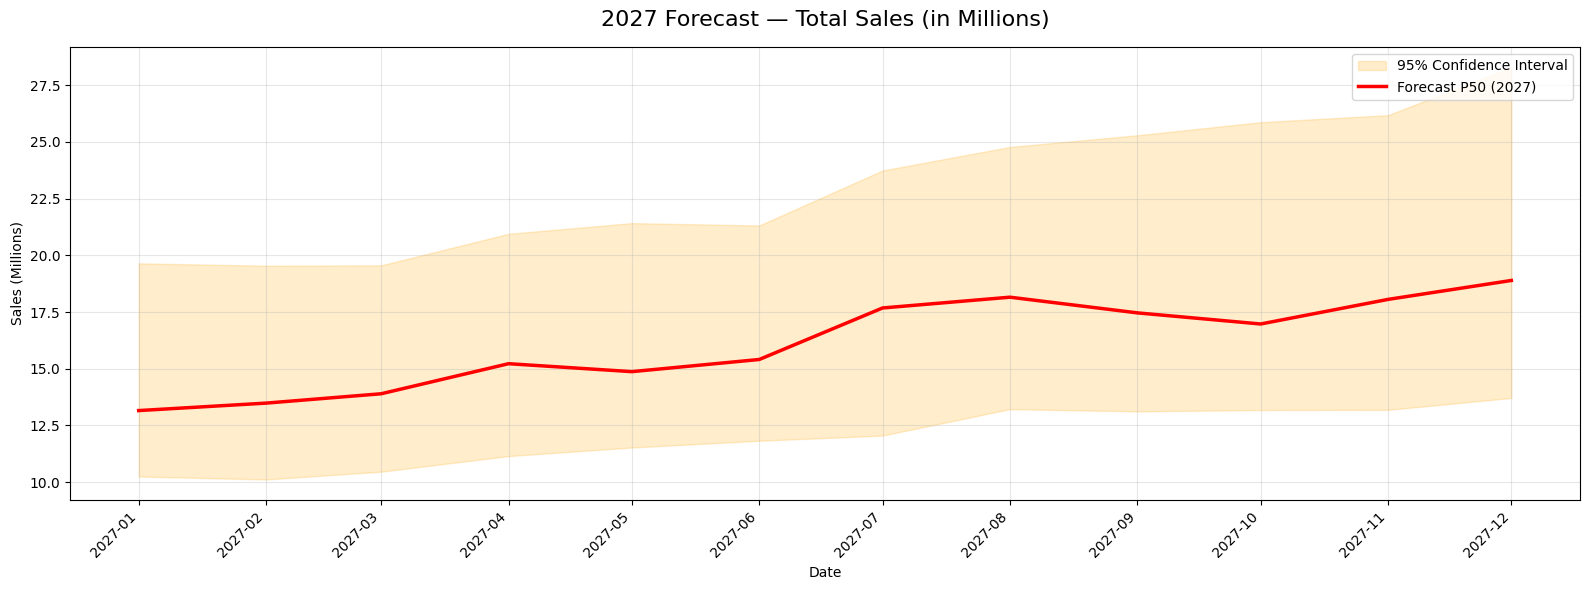

In [104]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# -------------------------------------------------------
# 1. Aggregate 2027 forecast to monthly totals
# -------------------------------------------------------
fc_2027 = (
    forecast_df_2027
    .groupby("DATE")[["FORECAST_P50", "FORECAST_P05", "FORECAST_P95"]]
    .sum()
    .reset_index()
    .sort_values("DATE")
)

# Convert to millions
fc_2027["P50_M"] = fc_2027["FORECAST_P50"] / 1_000_000
fc_2027["P05_M"] = fc_2027["FORECAST_P05"] / 1_000_000
fc_2027["P95_M"] = fc_2027["FORECAST_P95"] / 1_000_000

# -------------------------------------------------------
# 2. Plot
# -------------------------------------------------------
plt.figure(figsize=(16, 6))

# Confidence interval shading
plt.fill_between(
    fc_2027["DATE"],
    fc_2027["P05_M"],
    fc_2027["P95_M"],
    color="orange",
    alpha=0.2,
    label="95% Confidence Interval"
)

# P50 forecast line
plt.plot(
    fc_2027["DATE"],
    fc_2027["P50_M"],
    color="red",
    linewidth=2.5,
    label="Forecast P50 (2027)"
)

plt.title("2027 Forecast — Total Sales (in Millions)", fontsize=16, pad=15)
plt.xlabel("Date")
plt.ylabel("Sales (Millions)")

plt.grid(True, alpha=0.3)

plt.legend()

# Format x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate(rotation=45)

plt.tight_layout()
plt.show()


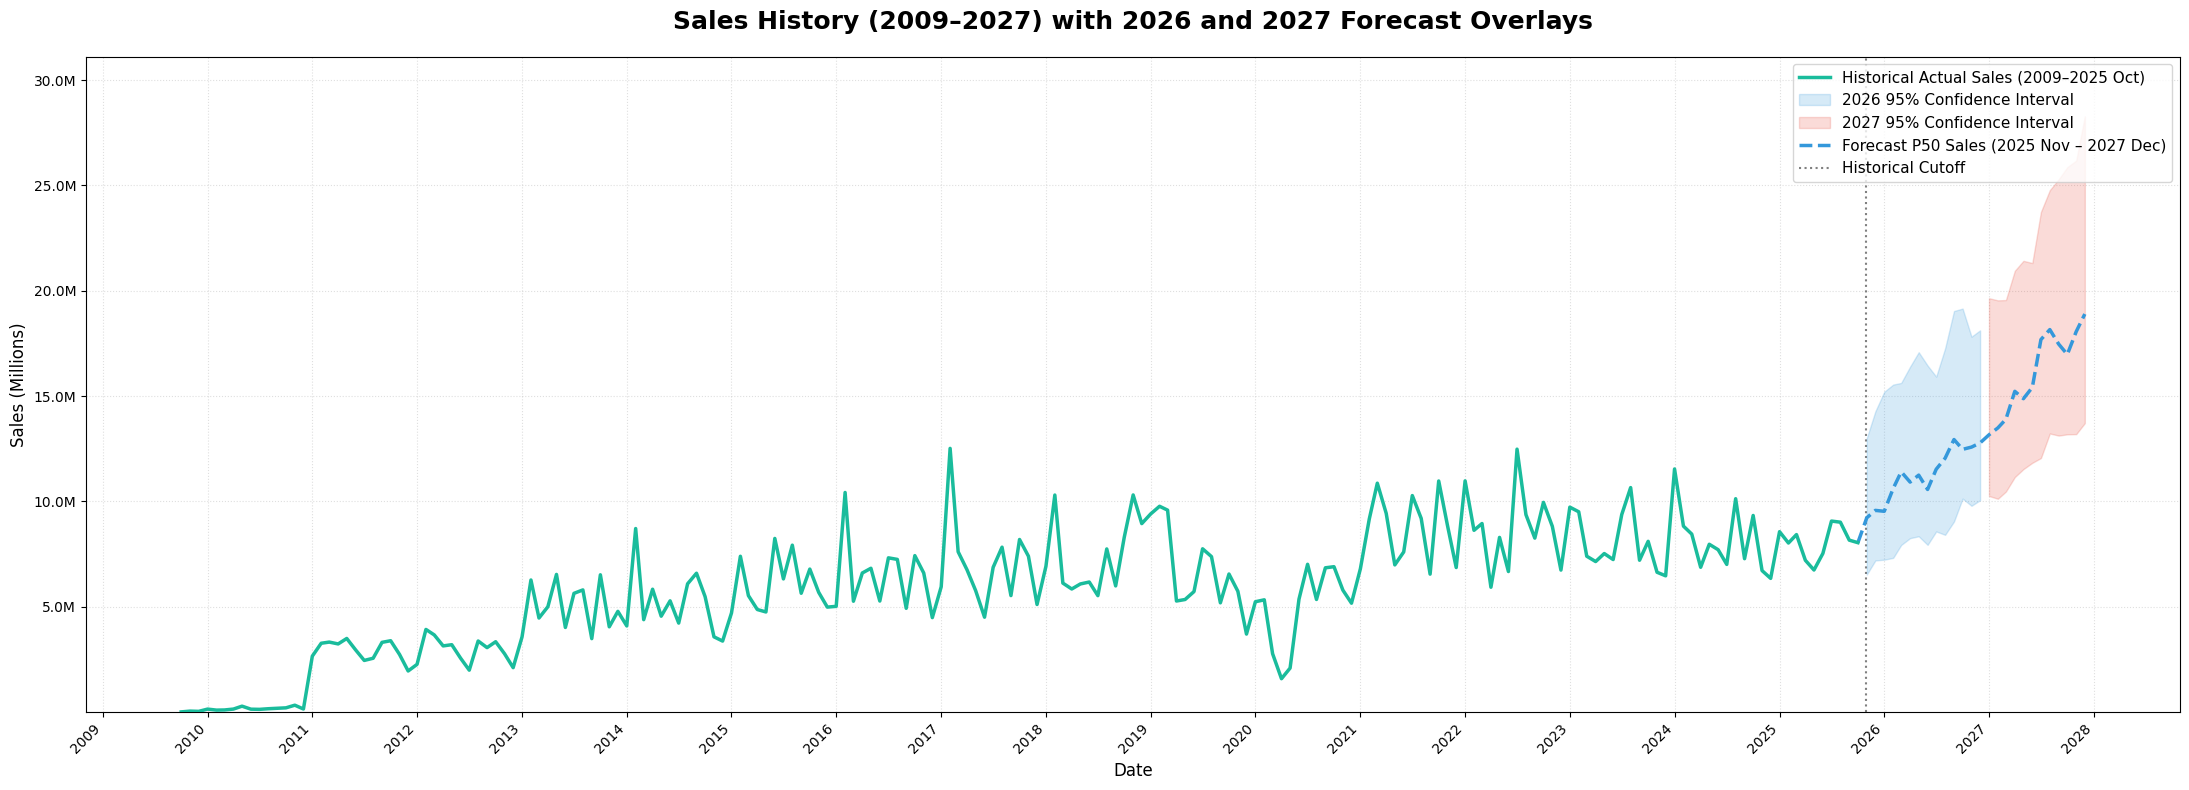

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np

# --- 1. Prepare Historical (Actual) Data (2009-01 to 2025-10) ---

# Assuming 'df_grouped' and 'SALES_COUNT_CLEAN' are correct for historical data
actuals_full = (
    df_grouped.groupby("DATE")["SALES_COUNT_CLEAN"]
    .sum()
    .reset_index()
    .rename(columns={"SALES_COUNT_CLEAN": "Total_Sales"})
)
actuals_full["Total_Sales_M"] = actuals_full["Total_Sales"] / 1_000_000
actuals_full["Source"] = "Actual"

train_cutoff = pd.to_datetime('2025-10-01')
actuals_full = actuals_full[actuals_full["DATE"] <= train_cutoff]


# --- 2. Prepare 2026 Forecast Data (2025-11 to 2026-12) ---

forecast_ci_2026 = (
    forecast_df
    .groupby("DATE")
    .agg({
        "FORECAST_P50": "sum",
        "FORECAST_P05": "sum",
        "FORECAST_P95": "sum"
    })
    .reset_index()
)
forecast_ci_2026["P50_M"] = forecast_ci_2026["FORECAST_P50"] / 1_000_000
forecast_ci_2026["P05_M"] = forecast_ci_2026["FORECAST_P05"] / 1_000_000
forecast_ci_2026["P95_M"] = forecast_ci_2026["FORECAST_P95"] / 1_000_000


# --- 3. Prepare 2027 Forecast Data (2027-01 to 2027-12) ---

forecast_ci_2027 = (
    forecast_df_2027
    .groupby("DATE")[["FORECAST_P50", "FORECAST_P05", "FORECAST_P95"]]
    .sum()
    .reset_index()
    .sort_values("DATE")
)
forecast_ci_2027["P50_M"] = forecast_ci_2027["FORECAST_P50"] / 1_000_000
forecast_ci_2027["P05_M"] = forecast_ci_2027["FORECAST_P05"] / 1_000_000
forecast_ci_2027["P95_M"] = forecast_ci_2027["FORECAST_P95"] / 1_000_000


# --- 4. Combine P50 Forecast Segments for Smooth Plotting ---

# Create a combined P50 series for a continuous forecast line (2025-11 to 2027-12)
combined_p50_forecast = pd.concat([
    forecast_ci_2026[["DATE", "P50_M"]].rename(columns={"P50_M": "Total_Sales_M"}),
    forecast_ci_2027[["DATE", "P50_M"]].rename(columns={"P50_M": "Total_Sales_M"})
]).sort_values("DATE").reset_index(drop=True)


# -------------------------------------------------------------
# --- 5. Plotting (Historical + 2026 CI + 2027 CI + Continuous P50 Line) ---
# -------------------------------------------------------------

plt.figure(figsize=(22, 8))
ax = plt.gca()

cutoff_date_point = pd.to_datetime('2025-10-01')

# --- PLOT 1: Historical Segment (Teal) ---
actual_segment = actuals_full[actuals_full["DATE"] <= cutoff_date_point]

plt.plot(
    actual_segment["DATE"],
    actual_segment["Total_Sales_M"],
    label="Historical Actual Sales (2009–2025 Oct)",
    linewidth=2.5,
    color="#1abc9c", # Teal
    zorder=5
)

# --- PLOT 2: 2026 Forecast Confidence Interval (Blue) ---
plt.fill_between(
    forecast_ci_2026["DATE"],
    forecast_ci_2026["P05_M"],
    forecast_ci_2026["P95_M"],
    alpha=0.2,
    color="#3498db", # Light Blue
    label="2026 95% Confidence Interval",
    zorder=3
)

# --- PLOT 3: 2027 Forecast Confidence Interval (Red/Orange) ---
plt.fill_between(
    forecast_ci_2027["DATE"],
    forecast_ci_2027["P05_M"],
    forecast_ci_2027["P95_M"],
    alpha=0.2,
    color="#e74c3c", # Red/Orange
    label="2027 95% Confidence Interval",
    zorder=3
)


# --- PLOT 4: Continuous P50 Forecast Line (Blue Dashed) ---
# Attach last actual point to the combined forecast segment for continuity
last_actual = actual_segment[actual_segment["DATE"] == cutoff_date_point]
if not last_actual.empty:
    continuous_forecast_segment = pd.concat(
        [last_actual[["DATE", "Total_Sales_M"]], combined_p50_forecast]
    ).drop_duplicates(subset=["DATE"]).sort_values("DATE")

plt.plot(
    continuous_forecast_segment["DATE"],
    continuous_forecast_segment["Total_Sales_M"],
    label="Forecast P50 Sales (2025 Nov – 2027 Dec)",
    linewidth=2.5,
    linestyle='--',
    color="#3498db", # Use Blue for the overall forecast line
    zorder=4
)

# --- PLOT 5: Cutoff Line ---
plt.axvline(
    x=pd.to_datetime('2025-10-31'),
    color='gray',
    linestyle=':',
    linewidth=1.5,
    label="Historical Cutoff"
)

# -------------------------
# --- Formatting and Aesthetics ---
# -------------------------

plt.title(
    "Sales History (2009–2027) with 2026 and 2027 Forecast Overlays",
    fontsize=18,
    weight="bold",
    pad=20
)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales (Millions)", fontsize=12)
plt.grid(alpha=0.4, linestyle=':')

# Use 'upper right' for the legend to avoid overlapping the initial data
plt.legend(fontsize=11, loc='upper right') 

# FORMAT Y-AXIS AS 1M, 2M, 3M, ...
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.1f}M"))

# Set clean bounds based on all data
y_min = max(0, actuals_full["Total_Sales_M"].min() * 0.9)
# Use the max of the P95 from both 2026 and 2027 for the upper bound
y_max = max(forecast_ci_2026["P95_M"].max(), forecast_ci_2027["P95_M"].max()) * 1.1
plt.ylim(y_min, y_max)

# X axis formatting (yearly ticks)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gcf().autofmt_xdate(rotation=45)

plt.tight_layout()
plt.show()

# 2028

# Training Prep for 2028 CatBoost

In [106]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
import numpy as np

# ======================================================
# 1. Use df_fe (feature engineered + cleaned dataset)
# ======================================================
df_2028 = df_fe.sort_values("DATE").copy()

# Drop NA lag rows (always required)
lag_cols = ["lag_1","lag_3","lag_6","lag_12","lag_24"]
df_2028 = df_2028.dropna(subset=lag_cols)

# ======================================================
# 2. TRAIN CUTOFF FOR 2028
#    Include actual + 2026 forecast + 2027 forecast
# ======================================================
train_cutoff = pd.to_datetime("2027-12-31")
train_df = df_2028[df_2028["DATE"] <= train_cutoff].copy()

# ======================================================
# 3. TARGET COLUMN
# ======================================================
TARGET = "SALES_COUNT_CLEAN"

# ======================================================
# 4. CATEGORICAL FEATURES
# ======================================================
CAT_FEATURES = [
    "REGION","COUNTRY","SALESORG",
    "SILHOUETTE","GENDER","SPORT"
]

# ======================================================
# 5. FEATURE LIST (same as 2026/2027)
# ======================================================
FEATURES = CAT_FEATURES + [
    "lag_1","lag_3","lag_6","lag_12","lag_24",
    "rolling_3","rolling_6",
    "yoy_change",
    "month_sin","month_cos"
]

# Ensure categorical strings
for c in CAT_FEATURES:
    train_df[c] = train_df[c].astype(str)

cat_feature_indices = [FEATURES.index(c) for c in CAT_FEATURES]

train_pool = Pool(
    train_df[FEATURES],
    train_df[TARGET],
    cat_features=cat_feature_indices
)



In [107]:
# ======================================================
# 6. TRAIN 3 MODELS (P50 / P05 / P95)
# ======================================================

model_p50_2028 = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=6,
    loss_function="RMSE",
    random_seed=42,
    verbose=100
)
model_p50_2028.fit(train_pool)

model_p05_2028 = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=6,
    loss_function="Quantile:alpha=0.05",
    random_seed=42,
    verbose=100
)
model_p05_2028.fit(train_pool)

model_p95_2028 = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=6,
    loss_function="Quantile:alpha=0.95",
    random_seed=42,
    verbose=100
)
model_p95_2028.fit(train_pool)

print("2028 P50, P05, P95 models trained successfully.")


0:	learn: 72588.8073359	total: 71.1ms	remaining: 2m 22s
100:	learn: 23268.0972997	total: 4.95s	remaining: 1m 32s
200:	learn: 21093.3479178	total: 9.41s	remaining: 1m 24s
300:	learn: 19847.9515300	total: 13.9s	remaining: 1m 18s
400:	learn: 18958.6980898	total: 18.5s	remaining: 1m 13s
500:	learn: 18179.9025003	total: 22.8s	remaining: 1m 8s
600:	learn: 17376.2275030	total: 27.5s	remaining: 1m 3s
700:	learn: 16681.9510500	total: 32.3s	remaining: 59.8s
800:	learn: 16036.9516101	total: 37.3s	remaining: 55.8s
900:	learn: 15445.6994461	total: 41.7s	remaining: 50.8s
1000:	learn: 14802.3554365	total: 46.7s	remaining: 46.6s
1100:	learn: 14195.1928867	total: 51.7s	remaining: 42.2s
1200:	learn: 13734.5861503	total: 56.5s	remaining: 37.6s


1300:	learn: 13383.8665133	total: 1m 1s	remaining: 33s
1400:	learn: 13012.4833911	total: 1m 6s	remaining: 28.4s
1500:	learn: 12682.5802392	total: 1m 11s	remaining: 23.7s
1600:	learn: 12391.5818645	total: 1m 16s	remaining: 19s
1700:	learn: 12092.3506409	total: 1m 21s	remaining: 14.2s
1800:	learn: 11835.7442956	total: 1m 25s	remaining: 9.47s
1900:	learn: 11534.2714848	total: 1m 30s	remaining: 4.71s
1999:	learn: 11273.1070121	total: 1m 35s	remaining: 0us
0:	learn: 665.9806899	total: 61.5ms	remaining: 2m 2s
100:	learn: 616.4941963	total: 5.97s	remaining: 1m 52s
200:	learn: 557.7545562	total: 11.9s	remaining: 1m 46s
300:	learn: 470.6937447	total: 17.7s	remaining: 1m 39s
400:	learn: 409.0774925	total: 25.6s	remaining: 1m 41s
500:	learn: 350.5595753	total: 31.4s	remaining: 1m 33s
600:	learn: 312.1858763	total: 37s	remaining: 1m 26s
700:	learn: 277.4320608	total: 42.8s	remaining: 1m 19s
800:	learn: 243.9396470	total: 48.9s	remaining: 1m 13s
900:	learn: 223.9361705	total: 54.7s	remaining: 1m 6s

In [108]:
from tqdm import tqdm
import numpy as np
import pandas as pd

# ---------------------------------------------------------
# 1. Combine ACTUAL + FORECASTED DATA for 2025-2027
# ---------------------------------------------------------

df_hist = df_grouped.copy()                    # actual + 2025 predictions
df_hist["DATE"] = pd.to_datetime(df_hist["DATE"])

# Add 2026 predictions
df_fc_2026 = forecast_2026.copy()
df_fc_2026["DATE"] = pd.to_datetime(df_fc_2026["DATE"])
df_fc_2026 = df_fc_2026[df_fc_2026["DATE"].dt.year == 2026]

# Use ONLY P50 as the base series
df_fc_2026["SALES_COUNT_CLEAN"] = df_fc_2026["FORECAST_P50"]

# Add 2027 predictions
df_fc_2027 = forecast_2027.copy()
df_fc_2027["DATE"] = pd.to_datetime(df_fc_2027["DATE"])
df_fc_2027 = df_fc_2027[df_fc_2027["DATE"].dt.year == 2027]

df_fc_2027["SALES_COUNT_CLEAN"] = df_fc_2027["FORECAST_P50"]


# Combine all into one historical dataset
df_hist_full = pd.concat([df_hist, df_fc_2026, df_fc_2027], ignore_index=True)

# Keep only data up to 2027-12-31
df_hist_full = df_hist_full[df_hist_full["DATE"] <= "2027-12-31"]
df_hist_full = df_hist_full.sort_values("DATE").reset_index(drop=True)

print("Final combined historical rows:", df_hist_full.shape)
print("Date range:", df_hist_full["DATE"].min(), "→", df_hist_full["DATE"].max())

# ---------------------------------------------------------
# 2. Correct grouping columns
# ---------------------------------------------------------
group_cols = [
    "REGION",
    "COUNTRY",
    "SALESORG",
    "SILHOUETTE",
    "GENDER",
    "SPORT"
]

# Convert to strings for stable keys
for c in group_cols:
    df_hist_full[c] = df_hist_full[c].astype(str)

# ---------------------------------------------------------
# 3. Unique groups
# ---------------------------------------------------------
groups_df = df_hist_full[group_cols].drop_duplicates().reset_index(drop=True)
groups_list = [tuple(row) for row in groups_df.values.tolist()]

print("Total unique groups:", len(groups_list))

# ---------------------------------------------------------
# 4. Build history dict for each group
# ---------------------------------------------------------
group_hist = {}

for key in tqdm(groups_list, desc="Building 2028 group history", unit="group"):

    mask = np.ones(len(df_hist_full), dtype=bool)
    for col, val in zip(group_cols, key):
        mask &= (df_hist_full[col] == val)

    sub = df_hist_full.loc[mask].copy()

    if sub.empty:
        group_hist[key] = pd.Series(dtype=float)
        continue

    sub = sub.sort_values("DATE")

    series = sub.set_index("DATE")["SALES_COUNT_CLEAN"].astype(float)

    group_hist[key] = series.copy()

print("\nGroup history construction complete for 2028.")
print("Total groups prepared:", len(group_hist))

# ---------------------------------------------------------
# 5. Median filler for missing lags
# ---------------------------------------------------------
median_fill = float(df_hist_full["SALES_COUNT_CLEAN"].median())

print("Median filler value:", median_fill)


Final combined historical rows: (100434, 30)
Date range: 2009-10-01 00:00:00 → 2027-12-01 00:00:00
Total unique groups: 899


Building 2028 group history: 100%|██████████| 899/899 [00:34<00:00, 26.23group/s]


Group history construction complete for 2028.
Total groups prepared: 899
Median filler value: 903.4330863965424


In [109]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from catboost import Pool

# =====================================================
# 1) Forecast period for 2028
# =====================================================
future_dates_2028 = pd.date_range(
    start=pd.to_datetime("2028-01-01"),
    end=pd.to_datetime("2028-12-01"),
    freq="MS"
)

pred_records_2028 = []

# =====================================================
# 2) SAFE LAG FUNCTION
# =====================================================
def safe_get_lag(hist_series: pd.Series, date: pd.Timestamp, months: int):
    if hist_series is None or hist_series.empty:
        return np.nan
    target = date - pd.DateOffset(months=months)
    if target in hist_series.index:
        return float(hist_series.loc[target])
    return np.nan

# =====================================================
# 3) CYCLICAL MONTH FEATURE
# =====================================================
def cyclical_month(dt):
    m = dt.month
    return (
        np.sin(2*np.pi*(m-1)/12),
        np.cos(2*np.pi*(m-1)/12)
    )

# =====================================================
# 4) MAIN FORECAST LOOP FOR 2028 (p05, p50, p95)
# =====================================================
for current_date in tqdm(future_dates_2028, desc="Forecasting 2028 months", unit="month"):

    batch_rows = []

    for key in groups_list:

        hist = group_hist.get(key, pd.Series(dtype=float))

        if not hist.empty:
            hist.index = pd.to_datetime(hist.index)

        # -------------------------
        # LAGS
        # -------------------------
        lag_1  = safe_get_lag(hist, current_date, 1)
        lag_3  = safe_get_lag(hist, current_date, 3)
        lag_6  = safe_get_lag(hist, current_date, 6)
        lag_12 = safe_get_lag(hist, current_date, 12)
        lag_24 = safe_get_lag(hist, current_date, 24)

        # -------------------------
        # ROLLING WINDOWS
        # -------------------------
        end_1 = current_date - pd.DateOffset(months=1)
        start_3 = current_date - pd.DateOffset(months=3)
        start_6 = current_date - pd.DateOffset(months=6)

        try:
            rolling_3 = float(hist.loc[start_3:end_1].mean())
        except:
            rolling_3 = np.nan

        try:
            rolling_6 = float(hist.loc[start_6:end_1].mean())
        except:
            rolling_6 = np.nan

        # -------------------------
        # Cyclical month
        # -------------------------
        month_sin, month_cos = cyclical_month(current_date)

        # -------------------------
        # YoY change
        # -------------------------
        if not pd.isna(lag_1) and not pd.isna(lag_12):
            yoy_change = (lag_1 - lag_12) / (lag_12 + 1e-6)
        else:
            yoy_change = 0.0

        # -------------------------
        # BUILD ROW
        # -------------------------
        row = {c: v for c, v in zip(group_cols, key)}
        row.update({
            "DATE": current_date,
            "lag_1":  lag_1  if not pd.isna(lag_1)  else median_fill,
            "lag_3":  lag_3  if not pd.isna(lag_3)  else median_fill,
            "lag_6":  lag_6  if not pd.isna(lag_6)  else median_fill,
            "lag_12": lag_12 if not pd.isna(lag_12) else median_fill,
            "lag_24": lag_24 if not pd.isna(lag_24) else median_fill,
            "rolling_3": rolling_3 if not pd.isna(rolling_3) else median_fill,
            "rolling_6": rolling_6 if not pd.isna(rolling_6) else median_fill,
            "month_sin": month_sin,
            "month_cos": month_cos,
            "yoy_change": yoy_change
        })

        batch_rows.append(row)

    # Convert to DataFrame
    batch = pd.DataFrame(batch_rows)

    # Ensure category dtypes
    for c in group_cols:
        batch[c] = batch[c].astype(str)

    # Prepare X
    X_batch = batch[FEATURES].fillna(median_fill)

    pool_batch = Pool(X_batch, cat_features=cat_feature_indices)

    # -------------------------
    # Predict p05, p50, p95
    # -------------------------
    pred_p50 = model_p50_2028.predict(pool_batch)
    pred_p05 = model_p05_2028.predict(pool_batch)
    pred_p95 = model_p95_2028.predict(pool_batch)

    # -------------------------
    # Recursive update: ONLY P50 goes into history
    # -------------------------
    for i in range(len(batch)):
        rec_key  = tuple(batch.loc[i, group_cols].values)
        rec_date = batch.loc[i, "DATE"]

        p50 = float(pred_p50[i])
        p05 = float(pred_p05[i])
        p95 = float(pred_p95[i])

        if rec_key not in group_hist:
            group_hist[rec_key] = pd.Series(dtype=float)

        # Update recursive history with P50 only
        group_hist[rec_key].at[rec_date] = p50

        # Save forecast row
        pred_records_2028.append({
            **{col: batch.loc[i, col] for col in group_cols},
            "DATE": rec_date,
            "FORECAST_P50": p50,
            "FORECAST_P05": p05,
            "FORECAST_P95": p95,
            "CI_LOWER": p05,
            "CI_UPPER": p95,
            "CI_WIDTH": p95 - p05
        })

# =====================================================
# 5) FINAL 2028 FORECAST DF
# =====================================================
forecast_2028 = pd.DataFrame(pred_records_2028)
forecast_2028 = forecast_2028.sort_values(["DATE"] + group_cols).reset_index(drop=True)

print("🌟 2028 Forecast with Confidence Intervals complete.")
print("Rows:", len(forecast_2028))


Forecasting 2028 months:  50%|█████     | 6/12 [00:15<00:15,  2.55s/month]

Forecasting 2028 months: 100%|██████████| 12/12 [00:31<00:00,  2.59s/month]

🌟 2028 Forecast with Confidence Intervals complete.
Rows: 10788


In [110]:
# Ensure final dataframe is named correctly
forecast_df_2028 = forecast_2028.copy()

# Sort for clean final output
forecast_df_2028 = forecast_df_2028.sort_values(['DATE'] + group_cols).reset_index(drop=True)

# Save CSV
output_path_2028 = "/home/azureuser/cloudfiles/code/Users/aishvary/forecast_2028_aish.csv"
forecast_df_2028.to_csv(output_path_2028, index=False)

print(f"Saved forecast_2028_aish.csv — rows: {len(forecast_df_2028)}")


Saved forecast_2028_aish.csv — rows: 10788


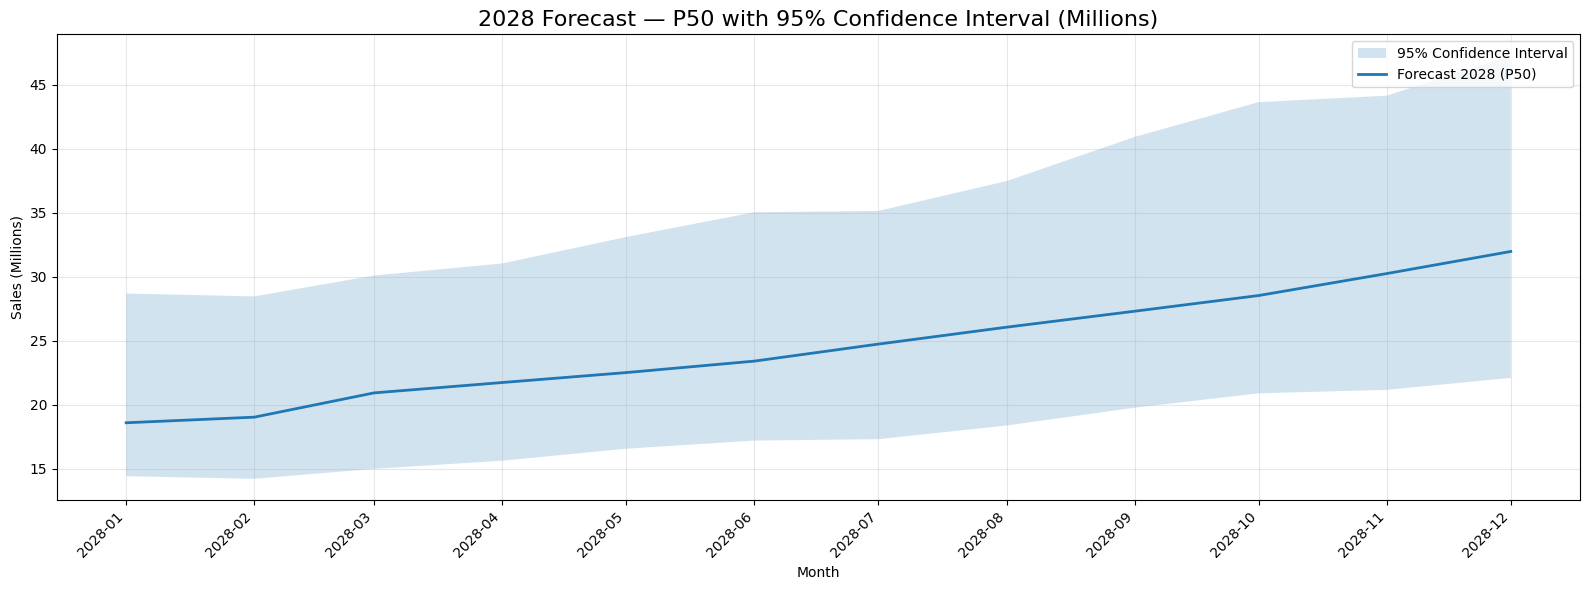

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ---- Prepare data ----
df_2028_plot = forecast_df_2028.copy()

monthly_2028 = (
    df_2028_plot.groupby("DATE")
    .agg({
        "FORECAST_P50": "sum",
        "FORECAST_P05": "sum",
        "FORECAST_P95": "sum"
    })
    .reset_index()
)

# Convert to millions
monthly_2028["P50_M"] = monthly_2028["FORECAST_P50"] / 1_000_000
monthly_2028["P05_M"] = monthly_2028["FORECAST_P05"] / 1_000_000
monthly_2028["P95_M"] = monthly_2028["FORECAST_P95"] / 1_000_000

# ---- Plot ----
plt.figure(figsize=(16,6))

# Shaded CI region
plt.fill_between(
    monthly_2028["DATE"],
    monthly_2028["P05_M"],
    monthly_2028["P95_M"],
    alpha=0.2,
    label="95% Confidence Interval"
)

# P50 forecast line
plt.plot(
    monthly_2028["DATE"],
    monthly_2028["P50_M"],
    linewidth=2,
    label="Forecast 2028 (P50)"
)

plt.title("2028 Forecast — P50 with 95% Confidence Interval (Millions)", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Sales (Millions)")
plt.grid(alpha=0.3)
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate(rotation=45)

plt.tight_layout()
plt.show()


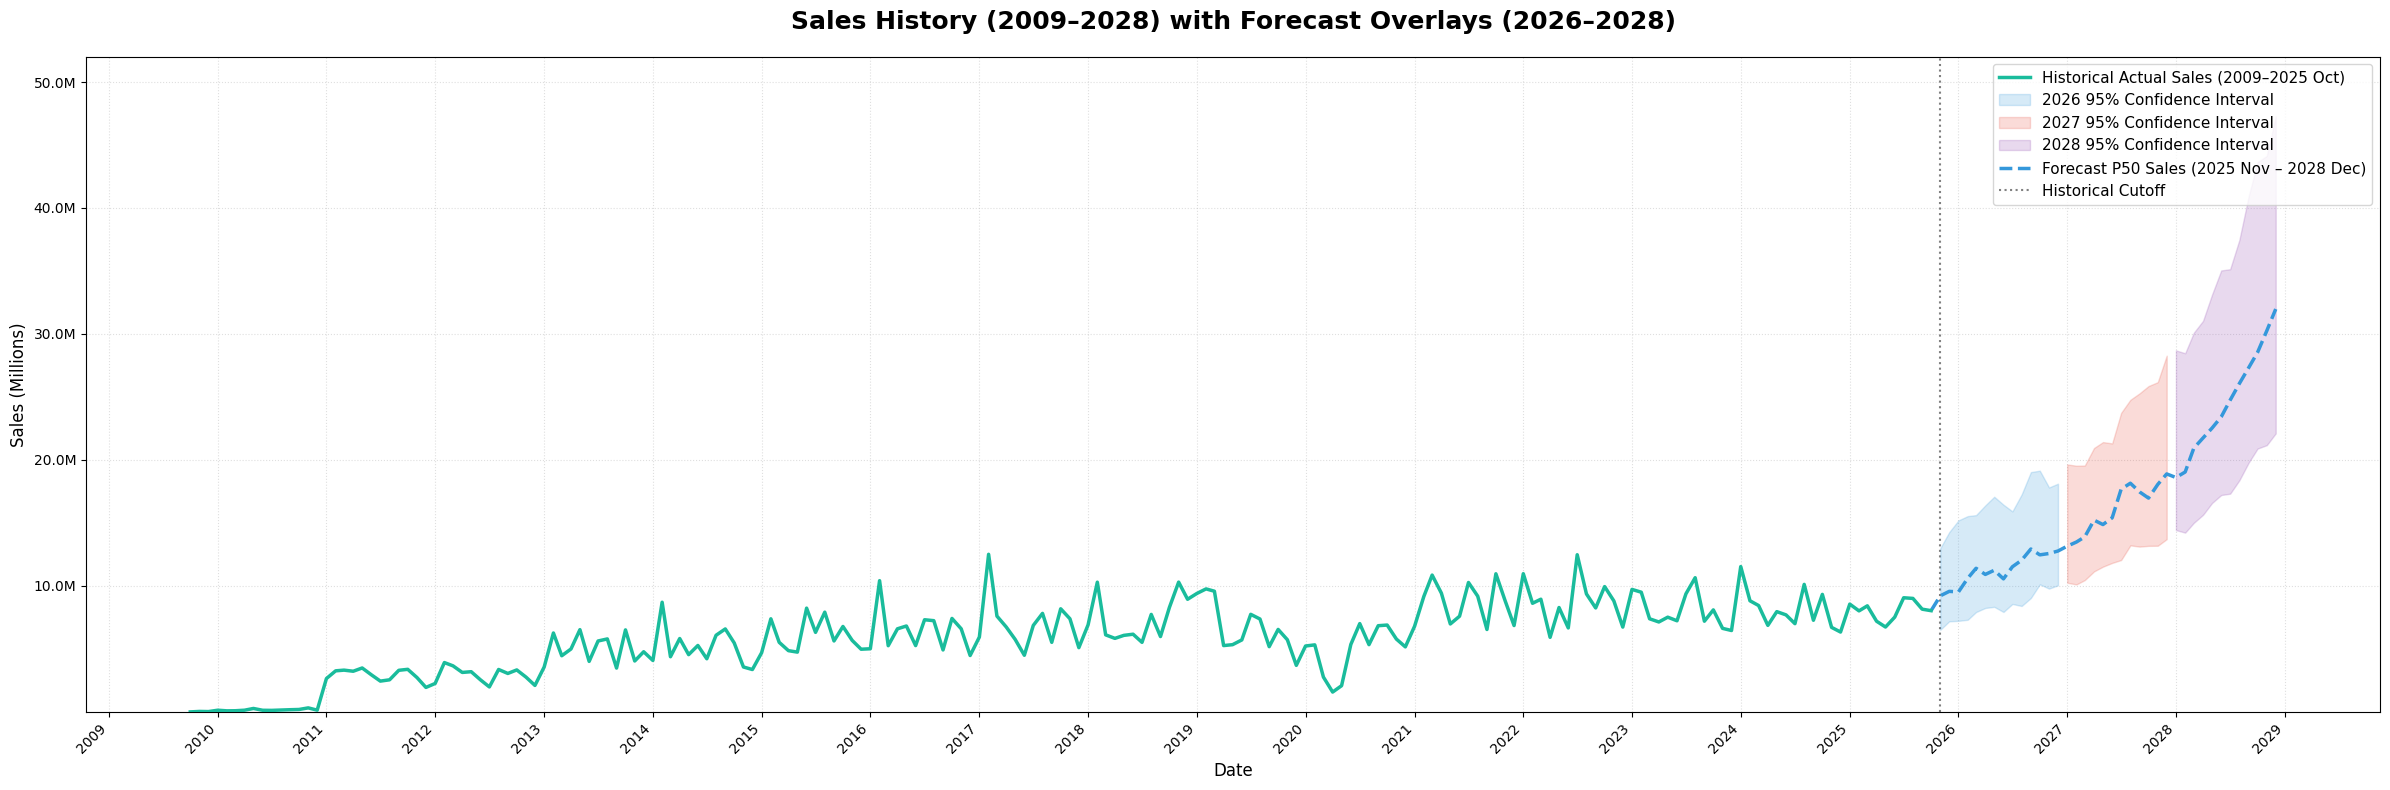

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np

# --- 1. Prepare Historical (Actual) Data (2009-01 to 2025-10) ---

# Assuming 'df_grouped' and 'SALES_COUNT_CLEAN' are correct for historical data
actuals_full = (
    df_grouped.groupby("DATE")["SALES_COUNT_CLEAN"]
    .sum()
    .reset_index()
    .rename(columns={"SALES_COUNT_CLEAN": "Total_Sales"})
)
actuals_full["Total_Sales_M"] = actuals_full["Total_Sales"] / 1_000_000
actuals_full["Source"] = "Actual"

train_cutoff = pd.to_datetime('2025-10-01')
actuals_full = actuals_full[actuals_full["DATE"] <= train_cutoff]


# --- 2. Prepare 2026 Forecast Data (2025-11 to 2026-12) ---

forecast_ci_2026 = (
    forecast_df
    .groupby("DATE")
    .agg({
        "FORECAST_P50": "sum",
        "FORECAST_P05": "sum",
        "FORECAST_P95": "sum"
    })
    .reset_index()
)
forecast_ci_2026["P50_M"] = forecast_ci_2026["FORECAST_P50"] / 1_000_000
forecast_ci_2026["P05_M"] = forecast_ci_2026["FORECAST_P05"] / 1_000_000
forecast_ci_2026["P95_M"] = forecast_ci_2026["FORECAST_P95"] / 1_000_000


# --- 3. Prepare 2027 Forecast Data (2027-01 to 2027-12) ---

forecast_ci_2027 = (
    forecast_df_2027
    .groupby("DATE")[["FORECAST_P50", "FORECAST_P05", "FORECAST_P95"]]
    .sum()
    .reset_index()
    .sort_values("DATE")
)
forecast_ci_2027["P50_M"] = forecast_ci_2027["FORECAST_P50"] / 1_000_000
forecast_ci_2027["P05_M"] = forecast_ci_2027["FORECAST_P05"] / 1_000_000
forecast_ci_2027["P95_M"] = forecast_ci_2027["FORECAST_P95"] / 1_000_000


# --- 4. Prepare 2028 Forecast Data (2028-01 to 2028-12) ---

forecast_ci_2028 = (
    forecast_df_2028
    .groupby("DATE")[["FORECAST_P50", "FORECAST_P05", "FORECAST_P95"]]
    .sum()
    .reset_index()
    .sort_values("DATE")
)
forecast_ci_2028["P50_M"] = forecast_ci_2028["FORECAST_P50"] / 1_000_000
forecast_ci_2028["P05_M"] = forecast_ci_2028["FORECAST_P05"] / 1_000_000
forecast_ci_2028["P95_M"] = forecast_ci_2028["FORECAST_P95"] / 1_000_000


# --- 5. Combine P50 Forecast Segments for Smooth Plotting ---

# Create a combined P50 series for a continuous forecast line (2025-11 to 2028-12)
combined_p50_forecast = pd.concat([
    forecast_ci_2026[["DATE", "P50_M"]].rename(columns={"P50_M": "Total_Sales_M"}),
    forecast_ci_2027[["DATE", "P50_M"]].rename(columns={"P50_M": "Total_Sales_M"}),
    forecast_ci_2028[["DATE", "P50_M"]].rename(columns={"P50_M": "Total_Sales_M"}) # <-- NEW ADDITION
]).sort_values("DATE").reset_index(drop=True)


# -------------------------------------------------------------
# --- 6. Plotting (Historical + 2026 CI + 2027 CI + 2028 CI + Continuous P50 Line) ---
# -------------------------------------------------------------

plt.figure(figsize=(24, 8))
ax = plt.gca()

cutoff_date_point = pd.to_datetime('2025-10-01')

# --- PLOT 1: Historical Segment (Teal) ---
actual_segment = actuals_full[actuals_full["DATE"] <= cutoff_date_point]

plt.plot(
    actual_segment["DATE"],
    actual_segment["Total_Sales_M"],
    label="Historical Actual Sales (2009–2025 Oct)",
    linewidth=2.5,
    color="#1abc9c", # Teal
    zorder=5
)

# --- PLOT 2: 2026 Forecast Confidence Interval (Blue) ---
plt.fill_between(
    forecast_ci_2026["DATE"],
    forecast_ci_2026["P05_M"],
    forecast_ci_2026["P95_M"],
    alpha=0.2,
    color="#3498db", # Light Blue
    label="2026 95% Confidence Interval",
    zorder=3
)

# --- PLOT 3: 2027 Forecast Confidence Interval (Red/Orange) ---
plt.fill_between(
    forecast_ci_2027["DATE"],
    forecast_ci_2027["P05_M"],
    forecast_ci_2027["P95_M"],
    alpha=0.2,
    color="#e74c3c", # Red/Orange
    label="2027 95% Confidence Interval",
    zorder=3
)

# --- PLOT 4: 2028 Forecast Confidence Interval (Deep Purple) ---
plt.fill_between(
    forecast_ci_2028["DATE"],
    forecast_ci_2028["P05_M"],
    forecast_ci_2028["P95_M"],
    alpha=0.2,
    color="#8e44ad", # Deep Purple <-- NEW CI BAND
    label="2028 95% Confidence Interval",
    zorder=3
)


# --- PLOT 5: Continuous P50 Forecast Line (Blue Dashed) ---
# Attach last actual point to the combined forecast segment for continuity
last_actual = actual_segment[actual_segment["DATE"] == cutoff_date_point]
if not last_actual.empty:
    continuous_forecast_segment = pd.concat(
        [last_actual[["DATE", "Total_Sales_M"]], combined_p50_forecast]
    ).drop_duplicates(subset=["DATE"]).sort_values("DATE")

plt.plot(
    continuous_forecast_segment["DATE"],
    continuous_forecast_segment["Total_Sales_M"],
    label="Forecast P50 Sales (2025 Nov – 2028 Dec)",
    linewidth=2.5,
    linestyle='--',
    color="#3498db", # Use Blue for the overall forecast line
    zorder=4
)

# --- PLOT 6: Cutoff Line ---
plt.axvline(
    x=pd.to_datetime('2025-10-31'),
    color='gray',
    linestyle=':',
    linewidth=1.5,
    label="Historical Cutoff"
)

# -------------------------
# --- Formatting and Aesthetics ---
# -------------------------

plt.title(
    "Sales History (2009–2028) with Forecast Overlays (2026–2028)",
    fontsize=18,
    weight="bold",
    pad=20
)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales (Millions)", fontsize=12)
plt.grid(alpha=0.4, linestyle=':')

# Use 'upper right' for the legend to avoid overlapping the initial data
plt.legend(fontsize=11, loc='upper right') 

# FORMAT Y-AXIS AS 1M, 2M, 3M, ...
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.1f}M"))

# Set clean bounds based on all data
y_min = max(0, actuals_full["Total_Sales_M"].min() * 0.9)
# Use the max of the P95 from 2026, 2027, and 2028 for the upper bound
y_max = max(
    forecast_ci_2026["P95_M"].max(), 
    forecast_ci_2027["P95_M"].max(),
    forecast_ci_2028["P95_M"].max() # <-- NEW MAX CHECK
) * 1.1
plt.ylim(y_min, y_max)

# X axis formatting (yearly ticks)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gcf().autofmt_xdate(rotation=45)

plt.tight_layout()
plt.show()

In [113]:
print("Forecasting and visualization for 2028 complete.")

Forecasting and visualization for 2028 complete.


In [114]:
# import pandas as pd

# # ----------------------------
# # 1. Load forecast files
# # ----------------------------
# path_2026 = "/home/azureuser/cloudfiles/code/Users/aishvary/forecast_2026_aish.csv"
# path_2027 = "/home/azureuser/cloudfiles/code/Users/aishvary/forecast_2027_aish.csv"
# path_2028 = "/home/azureuser/cloudfiles/code/Users/aishvary/forecast_2028_aish.csv"

# df_2026 = pd.read_csv(path_2026)
# df_2027 = pd.read_csv(path_2027)
# df_2028 = pd.read_csv(path_2028)

# # ----------------------------
# # 2. Combine them
# # ----------------------------
# combined_df = pd.concat([df_2026, df_2027, df_2028], ignore_index=True)

# # ----------------------------
# # 3. Convert DATE → datetime
# # ----------------------------
# combined_df["DATE"] = pd.to_datetime(combined_df["DATE"])

# # ----------------------------
# # 4. Sort for clean output
# # ----------------------------
# group_cols = ["REGION","COUNTRY","SALESORG","SILHOUETTE","GENDER","SPORT"]
# combined_df = combined_df.sort_values(["DATE"] + group_cols).reset_index(drop=True)

# # ----------------------------
# # 5. Save final fileimport pandas as pd

# # ----------------------------
# # 1. Load forecast files
# # ----------------------------
# path_2026 = "/home/azureuser/cloudfiles/code/Users/aishvary/forecast_2026_aish.csv"
# path_2027 = "/home/azureuser/cloudfiles/code/Users/aishvary/forecast_2027_aish.csv"
# path_2028 = "/home/azureuser/cloudfiles/code/Users/aishvary/forecast_2028_aish.csv"

# df_2026 = pd.read_csv(path_2026)
# df_2027 = pd.read_csv(path_2027)
# df_2028 = pd.read_csv(path_2028)

# # ----------------------------
# # 2. Add FORECAST_YEAR column
# # ----------------------------
# df_2026["FORECAST_YEAR"] = 2026
# df_2027["FORECAST_YEAR"] = 2027
# df_2028["FORECAST_YEAR"] = 2028

# # ----------------------------
# # 3. Combine them
# # ----------------------------
# combined_df = pd.concat([df_2026, df_2027, df_2028], ignore_index=True)

# # ----------------------------
# # 4. Convert DATE → datetime
# # ----------------------------
# combined_df["DATE"] = pd.to_datetime(combined_df["DATE"])

# # ----------------------------
# # 5. Sort for clean output
# # ----------------------------
# group_cols = ["REGION","COUNTRY","SALESORG","SILHOUETTE","GENDER","SPORT"]
# combined_df = combined_df.sort_values(["DATE"] + group_cols).reset_index(drop=True)

# # ----------------------------
# # 6. Save final file
# # ----------------------------
# numeric_cols = combined_df.select_dtypes(include=['number']).columns.tolist()
# combined_df[numeric_cols] = combined_df[numeric_cols].clip(lower=0)
# output_path = "/home/azureuser/cloudfiles/code/Users/aishvary/forecast_2026_27_28_combined.csv"
# combined_df.to_csv(output_path, index=False)

# print("Merged CSV saved:", output_path)
# print("Total rows:", len(combined_df))
# print("Columns:", combined_df.columns.tolist())

# # ----------------------------
# output_path = "/home/azureuser/cloudfiles/code/Users/aishvary/forecast_2026_27_28_combined.csv"
# combined_df.to_csv(output_path, index=False)

# print("Merged CSV saved:", output_path)
# print("Total rows:", len(combined_df))


In [115]:
import pandas as pd

# ----------------------------
# 1. Load forecast files
# ----------------------------
path_2025 = "/home/azureuser/cloudfiles/code/Users/aishvary/results_2025_aish.csv"
path_2026 = "/home/azureuser/cloudfiles/code/Users/aishvary/forecast_2026_aish.csv"
path_2027 = "/home/azureuser/cloudfiles/code/Users/aishvary/forecast_2027_aish.csv"
path_2028 = "/home/azureuser/cloudfiles/code/Users/aishvary/forecast_2028_aish.csv"

df_2025 = pd.read_csv(path_2025)
df_2026 = pd.read_csv(path_2026)
df_2027 = pd.read_csv(path_2027)
df_2028 = pd.read_csv(path_2028)

# ----------------------------
# 2. Add FORECAST_YEAR column
# ----------------------------
df_2025["FORECAST_YEAR"] = 2025
df_2026["FORECAST_YEAR"] = 2026
df_2027["FORECAST_YEAR"] = 2027
df_2028["FORECAST_YEAR"] = 2028

# ----------------------------
# 3. Combine them
# ----------------------------
combined_df = pd.concat([df_2025, df_2026, df_2027, df_2028], ignore_index=True)

# ----------------------------
# 4. Convert DATE → datetime
# ----------------------------
combined_df["DATE"] = pd.to_datetime(combined_df["DATE"])

# ----------------------------
# 5. Sort for clean output
# ----------------------------
group_cols = ["REGION","COUNTRY","SALESORG","SILHOUETTE","GENDER","SPORT"]
combined_df = combined_df.sort_values(["DATE"] + group_cols).reset_index(drop=True)


columns_to_remove = ['ERROR', 'APE']
columns_to_remove = [col for col in columns_to_remove if col in combined_df.columns]
if columns_to_remove:
    combined_df = combined_df.drop(columns=columns_to_remove)
    # print(f"Removed columns: {columns_to_remove}")


# ----------------------------
# 6. Save final combined CSV
# ----------------------------
numeric_cols = combined_df.select_dtypes(include=['number']).columns.tolist()
combined_df[numeric_cols] = combined_df[numeric_cols].clip(lower=0)
output_path = "/home/azureuser/cloudfiles/code/Users/aishvary/forecast_2025_26_27_28_combined_new.csv"
combined_df.to_csv(output_path, index=False)
print("Merged CSV saved with capped values")

print("Merged CSV saved:", output_path)
print("Total rows:", len(combined_df))
print("Columns:", combined_df.columns.tolist())


Merged CSV saved with capped values
Merged CSV saved: /home/azureuser/cloudfiles/code/Users/aishvary/forecast_2025_26_27_28_combined_new.csv
Total rows: 40425
Columns: ['DATE', 'REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT', 'ACTUAL_SALES', 'FORECAST_P50', 'FORECAST_P05', 'FORECAST_P95', 'CI_LOWER', 'CI_UPPER', 'CI_WIDTH', 'FORECAST_YEAR']


In [116]:
# # ========================================
# # Export Trained Models
# # ========================================

# # Directory to save models
# import os
# model_dir = "/home/azureuser/cloudfiles/code/Users/aishvary/models"
# os.makedirs(model_dir, exist_ok=True)

# # Save model_p50 (median quantile)
# model_p50_path = os.path.join(model_dir, "catboost_p50_model.cbm")
# model_p50.save_model(model_p50_path)
# print(f"✓ Model P50 saved to: {model_p50_path}")

# # Save model_p05 (lower quantile) 
# model_p05_path = os.path.join(model_dir, "catboost_p05_model.cbm")
# model_p05.save_model(model_p05_path)
# print(f"✓ Model P05 saved to: {model_p05_path}")

# # Save model_p95 (upper quantile)
# model_p95_path = os.path.join(model_dir, "catboost_p95_model.cbm")
# model_p95.save_model(model_p95_path)
# print(f"✓ Model P95 saved to: {model_p95_path}")

# # Optionally save as .txt format for human readability
# # model_p50.save_model(os.path.join(model_dir, "catboost_p50_model.txt"), format="CPP")
# # print("✓ Model P50 also saved as .txt format")

# print(f"\n✅ All 3 models exported successfully to: {model_dir}")

In [117]:
# # ------------------------------------------------
# # 7. CLOSE CONNECTION
# # ------------------------------------------------
# cursor.close()
# conn.close()
# print("All done! Connection closed.")